## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


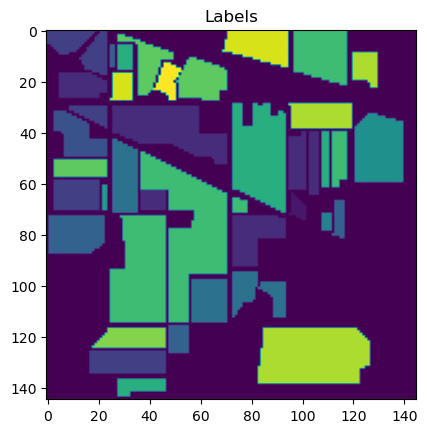

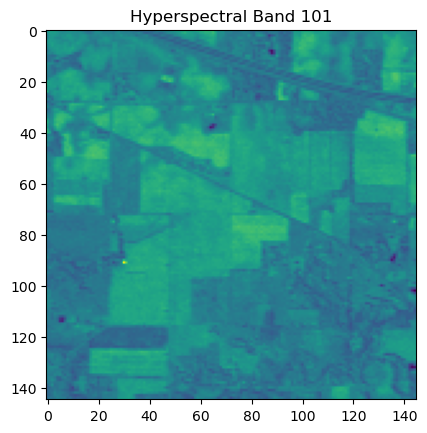

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(608, 5, 5, 200)
(70, 5, 5, 200)
(9571, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0812, PSNR: 10.2003


Epoch [1/50] Training Loss: 0.0656, PSNR: 11.3947
	[Val]   Batch [1/33] Loss: 0.0502, PSNR: 12.6597
	[Val]   Batch [10/33] Loss: 0.0496, PSNR: 12.3112
	[Val]   Batch [20/33] Loss: 0.0492, PSNR: 11.9078
	[Val]   Batch [30/33] Loss: 0.0480, PSNR: 12.2649
Epoch [1/50] Validation Loss: 0.0500, PSNR: 12.4706

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0488, PSNR: 12.3410


Epoch [2/50] Training Loss: 0.0402, PSNR: 13.5530
	[Val]   Batch [1/33] Loss: 0.0297, PSNR: 14.9381
	[Val]   Batch [10/33] Loss: 0.0293, PSNR: 14.6020
	[Val]   Batch [20/33] Loss: 0.0290, PSNR: 14.2036
	[Val]   Batch [30/33] Loss: 0.0285, PSNR: 14.5255
Epoch [2/50] Validation Loss: 0.0297, PSNR: 14.7323

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0302, PSNR: 14.8307


Epoch [3/50] Training Loss: 0.0235, PSNR: 15.8450
	[Val]   Batch [1/33] Loss: 0.0177, PSNR: 17.1772
	[Val]   Batch [10/33] Loss: 0.0173, PSNR: 16.8826
	[Val]   Batch [20/33] Loss: 0.0170, PSNR: 16.5221
	[Val]   Batch [30/33] Loss: 0.0167, PSNR: 16.8600
Epoch [3/50] Validation Loss: 0.0177, PSNR: 16.9759

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0178, PSNR: 16.8884


Epoch [4/50] Training Loss: 0.0142, PSNR: 18.0415
	[Val]   Batch [1/33] Loss: 0.0113, PSNR: 19.1320
	[Val]   Batch [10/33] Loss: 0.0109, PSNR: 18.9069
	[Val]   Batch [20/33] Loss: 0.0106, PSNR: 18.5788
	[Val]   Batch [30/33] Loss: 0.0103, PSNR: 18.9300
Epoch [4/50] Validation Loss: 0.0113, PSNR: 18.9414

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0104, PSNR: 19.2320


Epoch [5/50] Training Loss: 0.0094, PSNR: 19.8582
	[Val]   Batch [1/33] Loss: 0.0081, PSNR: 20.5656
	[Val]   Batch [10/33] Loss: 0.0077, PSNR: 20.4147
	[Val]   Batch [20/33] Loss: 0.0074, PSNR: 20.1288
	[Val]   Batch [30/33] Loss: 0.0072, PSNR: 20.4789
Epoch [5/50] Validation Loss: 0.0081, PSNR: 20.3812

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0084, PSNR: 20.2490


Epoch [6/50] Training Loss: 0.0068, PSNR: 21.2145
	[Val]   Batch [1/33] Loss: 0.0061, PSNR: 21.8235
	[Val]   Batch [10/33] Loss: 0.0056, PSNR: 21.7570
	[Val]   Batch [20/33] Loss: 0.0054, PSNR: 21.5203
	[Val]   Batch [30/33] Loss: 0.0052, PSNR: 21.8933
Epoch [6/50] Validation Loss: 0.0061, PSNR: 21.6562

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0052, PSNR: 22.5137


Epoch [7/50] Training Loss: 0.0053, PSNR: 22.2815
	[Val]   Batch [1/33] Loss: 0.0049, PSNR: 22.7716
	[Val]   Batch [10/33] Loss: 0.0044, PSNR: 22.7990
	[Val]   Batch [20/33] Loss: 0.0042, PSNR: 22.6047
	[Val]   Batch [30/33] Loss: 0.0041, PSNR: 22.9950
Epoch [7/50] Validation Loss: 0.0048, PSNR: 22.6363

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0041, PSNR: 23.6803


Epoch [8/50] Training Loss: 0.0043, PSNR: 23.1816
	[Val]   Batch [1/33] Loss: 0.0041, PSNR: 23.5748
	[Val]   Batch [10/33] Loss: 0.0036, PSNR: 23.6952
	[Val]   Batch [20/33] Loss: 0.0034, PSNR: 23.5423
	[Val]   Batch [30/33] Loss: 0.0032, PSNR: 23.9634
Epoch [8/50] Validation Loss: 0.0040, PSNR: 23.4781

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0039, PSNR: 23.4105


Epoch [9/50] Training Loss: 0.0037, PSNR: 23.9264
	[Val]   Batch [1/33] Loss: 0.0035, PSNR: 24.2768
	[Val]   Batch [10/33] Loss: 0.0030, PSNR: 24.5055
	[Val]   Batch [20/33] Loss: 0.0028, PSNR: 24.3875
	[Val]   Batch [30/33] Loss: 0.0026, PSNR: 24.8474
Epoch [9/50] Validation Loss: 0.0034, PSNR: 24.2335

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0030, PSNR: 24.4297


Epoch [10/50] Training Loss: 0.0032, PSNR: 24.5876
	[Val]   Batch [1/33] Loss: 0.0030, PSNR: 24.9107
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.2313
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.1452
	[Val]   Batch [30/33] Loss: 0.0022, PSNR: 25.6225
Epoch [10/50] Validation Loss: 0.0029, PSNR: 24.9097

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 24.6851


Epoch [11/50] Training Loss: 0.0028, PSNR: 25.1546
	[Val]   Batch [1/33] Loss: 0.0027, PSNR: 25.3416
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.7577
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.7225
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.2509
Epoch [11/50] Validation Loss: 0.0026, PSNR: 25.4099

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0034, PSNR: 23.6968


Epoch [12/50] Training Loss: 0.0025, PSNR: 25.5839
	[Val]   Batch [1/33] Loss: 0.0024, PSNR: 25.7886
	[Val]   Batch [10/33] Loss: 0.0020, PSNR: 26.2513
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.2405
	[Val]   Batch [30/33] Loss: 0.0017, PSNR: 26.7959
Epoch [12/50] Validation Loss: 0.0023, PSNR: 25.8789

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.5732


Epoch [13/50] Training Loss: 0.0023, PSNR: 25.9847
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.2268
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.7199
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.7315
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.2978
Epoch [13/50] Validation Loss: 0.0021, PSNR: 26.3292

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.6450


Epoch [14/50] Training Loss: 0.0021, PSNR: 26.3439
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.5011
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.9849
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.0132
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.6081
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.6020

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.7853


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.6880
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.0421
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.5185
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.5613
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.1707
Epoch [15/50] Validation Loss: 0.0017, PSNR: 27.1394

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 26.1813


Epoch [16/50] Training Loss: 0.0018, PSNR: 26.9982
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.4073
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.8754
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 27.9469
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.5711
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.5066

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.1456


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.3684
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.8551
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.2795
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.3769
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.0016
Epoch [17/50] Validation Loss: 0.0014, PSNR: 27.9369

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 28.1241


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.6979
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.2809
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.6542
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.7538
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.4267
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.3439

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.3746


Epoch [19/50] Training Loss: 0.0014, PSNR: 28.0104
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7362
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.0768
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.1798
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.8635
Epoch [19/50] Validation Loss: 0.0012, PSNR: 28.7723

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.9598


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2782
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.0746
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3438
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.4581
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.1754
Epoch [20/50] Validation Loss: 0.0011, PSNR: 29.0889

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 26.9855


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.5385
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.3343
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.5950
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.7381
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.4637
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.3614

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.7761


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.7938
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6510
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9162
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 30.0728
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7812
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.6894

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.1959


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.9941
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 29.9312
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.1750
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3579
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.1022
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.9676

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.7037


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.1499
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1744
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4226
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6305
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.3733
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.2214

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.1408


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2794
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3606
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.5901
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.8352
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.6136
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.4210

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.4016


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4296
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3015
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.5260
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7807
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.6052
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.3830
Early stopping triggered at epoch 26. No improvement for 3 epochs.


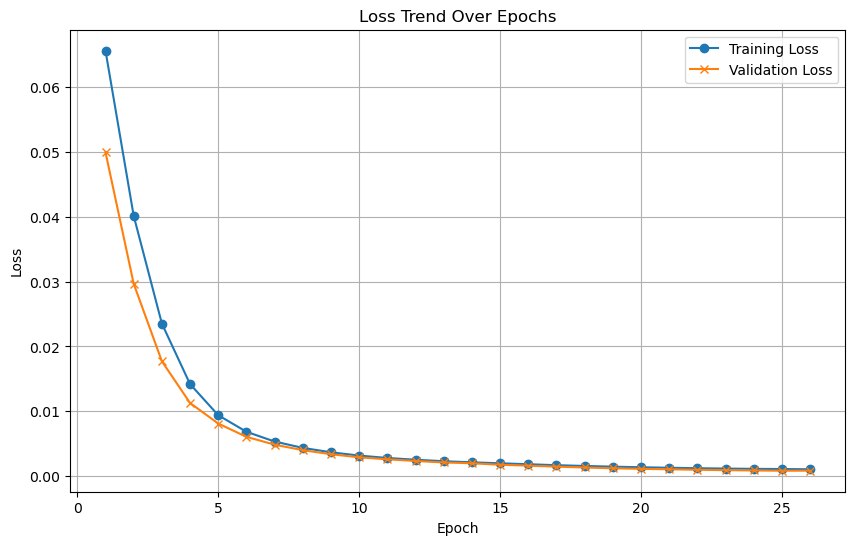

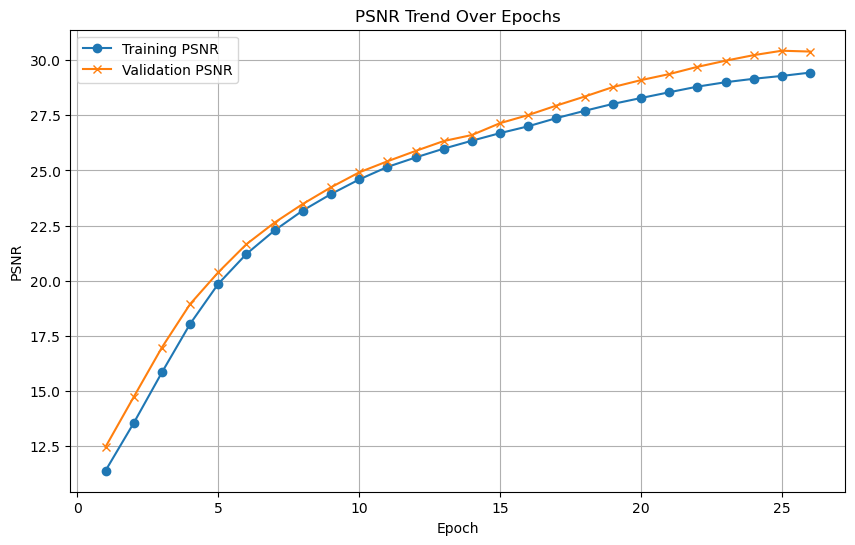

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/38 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7771
    Validation Batch [1/1], Loss: 2.7687
Validation Loss: 2.7687, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.7687. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7528
    Validation Batch [1/1], Loss: 2.7686
Validation Loss: 2.7686, Validation Accuracy: 7.14%
Validation loss improved from 2.7687 to 2.7686. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7397
    Validation Batch [1/1], Loss: 2.7685
Validation Loss: 2.7685, Validation Accuracy: 7.14%
Validation loss improved from 2.7686 to 2.7685. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7231
    Validation Batch [1/1], Loss: 2.7685
Validation Loss: 2.7685, Validation Accuracy: 7.14%
Validation loss improved from 2.7685 to 2.7685. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.7684
Validation Loss: 2.7684, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6530
    Validation Batch [1/1], Loss: 2.7685
Validation Loss: 2.7685, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6540
    Validation Batch [1/1], Loss: 2.7685
Validation Loss: 2.7685, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6358
    Validation Batch [1/1], Loss: 2.7685
Validation Loss: 2.7685, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6195
    Validation Batch [1/1], Loss: 2.7685
Validation Loss: 2.7685, Validati

    Validation Batch [1/1], Loss: 2.7681
Validation Loss: 2.7681, Validation Accuracy: 7.14%
Validation loss improved from 2.7682 to 2.7681. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.5700
    Validation Batch [1/1], Loss: 2.7678
Validation Loss: 2.7678, Validation Accuracy: 7.14%
Validation loss improved from 2.7681 to 2.7678. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5622
    Validation Batch [1/1], Loss: 2.7677
Validation Loss: 2.7677, Validation Accuracy: 7.14%
Validation loss improved from 2.7678 to 2.7677. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5398
    Validation Batch [1/1], Loss: 2.7673
Validation Loss: 2.7673, Validation Accuracy: 7.14%
Validation loss improved from 2.7677 to 2.7673. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5437
    Validati

Epoch [31/1000] completed, Average Training Loss: 2.4363
    Validation Batch [1/1], Loss: 2.7515
Validation Loss: 2.7515, Validation Accuracy: 14.29%
Validation loss improved from 2.7540 to 2.7515. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.4354
    Validation Batch [1/1], Loss: 2.7488
Validation Loss: 2.7488, Validation Accuracy: 18.57%
Validation loss improved from 2.7515 to 2.7488. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.4186
    Validation Batch [1/1], Loss: 2.7457
Validation Loss: 2.7457, Validation Accuracy: 14.29%
Validation loss improved from 2.7488 to 2.7457. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.4144
    Validation Batch [1/1], Loss: 2.7424
Validation Loss: 2.7424, Validation Accuracy: 14.29%
Validation loss improved from 2.7457 to 2.7424. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [3

Epoch [39/1000] completed, Average Training Loss: 2.4041
    Validation Batch [1/1], Loss: 2.7125
Validation Loss: 2.7125, Validation Accuracy: 14.29%
Validation loss improved from 2.7179 to 2.7125. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.3547
    Validation Batch [1/1], Loss: 2.7027
Validation Loss: 2.7027, Validation Accuracy: 14.29%
Validation loss improved from 2.7125 to 2.7027. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.3569
    Validation Batch [1/1], Loss: 2.6917
Validation Loss: 2.6917, Validation Accuracy: 14.29%
Validation loss improved from 2.7027 to 2.6917. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.3563
    Validation Batch [1/1], Loss: 2.6801
Validation Loss: 2.6801, Validation Accuracy: 14.29%
Validation loss improved from 2.6917 to 2.6801. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [4

Epoch [53/1000] completed, Average Training Loss: 2.2765
    Validation Batch [1/1], Loss: 2.4806
Validation Loss: 2.4806, Validation Accuracy: 24.29%
Validation loss improved from 2.5063 to 2.4806. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2634
    Validation Batch [1/1], Loss: 2.4613
Validation Loss: 2.4613, Validation Accuracy: 22.86%
Validation loss improved from 2.4806 to 2.4613. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.2641
    Validation Batch [1/1], Loss: 2.4466
Validation Loss: 2.4466, Validation Accuracy: 24.29%
Validation loss improved from 2.4613 to 2.4466. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.2551
    Validation Batch [1/1], Loss: 2.4215
Validation Loss: 2.4215, Validation Accuracy: 24.29%
Validation loss improved from 2.4466 to 2.4215. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [5

Epoch [62/1000] completed, Average Training Loss: 2.2031
    Validation Batch [1/1], Loss: 2.3215
Validation Loss: 2.3215, Validation Accuracy: 24.29%
Validation loss improved from 2.3301 to 2.3215. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.2054
    Validation Batch [1/1], Loss: 2.2908
Validation Loss: 2.2908, Validation Accuracy: 24.29%
Validation loss improved from 2.3215 to 2.2908. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.2025
    Validation Batch [1/1], Loss: 2.2637
Validation Loss: 2.2637, Validation Accuracy: 27.14%
Validation loss improved from 2.2908 to 2.2637. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 2.1800
    Validation Batch [1/1], Loss: 2.2525
Validation Loss: 2.2525, Validation Accuracy: 27.14%
Validation loss improved from 2.2637 to 2.2525. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.1581
Validation Loss: 2.1581, Validation Accuracy: 32.86%
Validation loss improved from 2.1608 to 2.1581. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.1019
    Validation Batch [1/1], Loss: 2.1350
Validation Loss: 2.1350, Validation Accuracy: 34.29%
Validation loss improved from 2.1581 to 2.1350. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.1155
    Validation Batch [1/1], Loss: 2.1211
Validation Loss: 2.1211, Validation Accuracy: 35.71%
Validation loss improved from 2.1350 to 2.1211. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 2.1062
    Validation Batch [1/1], Loss: 2.1381
Validation Loss: 2.1381, Validation Accuracy: 32.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.0954
    Validation Batch [1

Epoch [86/1000] completed, Average Training Loss: 2.0279
    Validation Batch [1/1], Loss: 2.0551
Validation Loss: 2.0551, Validation Accuracy: 37.14%
Validation loss improved from 2.0841 to 2.0551. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 2.0466
    Validation Batch [1/1], Loss: 2.0401
Validation Loss: 2.0401, Validation Accuracy: 34.29%
Validation loss improved from 2.0551 to 2.0401. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 2.0299
    Validation Batch [1/1], Loss: 2.0484
Validation Loss: 2.0484, Validation Accuracy: 27.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 2.0051
    Validation Batch [1/1], Loss: 2.0609
Validation Loss: 2.0609, Validation Accuracy: 24.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Tra

Epoch [97/1000] completed, Average Training Loss: 1.9599
    Validation Batch [1/1], Loss: 2.0113
Validation Loss: 2.0113, Validation Accuracy: 35.71%
Validation loss improved from 2.0310 to 2.0113. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.9443
    Validation Batch [1/1], Loss: 2.0371
Validation Loss: 2.0371, Validation Accuracy: 41.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.9293
    Validation Batch [1/1], Loss: 2.0595
Validation Loss: 2.0595, Validation Accuracy: 41.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.9507
    Validation Batch [1/1], Loss: 2.0732
Validation Loss: 2.0732, Validation Accuracy: 35.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss:

Epoch [108/1000] completed, Average Training Loss: 1.8788
    Validation Batch [1/1], Loss: 1.9412
Validation Loss: 1.9412, Validation Accuracy: 50.00%
Validation loss improved from 1.9422 to 1.9412. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.8769
    Validation Batch [1/1], Loss: 1.9984
Validation Loss: 1.9984, Validation Accuracy: 48.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.8565
    Validation Batch [1/1], Loss: 2.0963
Validation Loss: 2.0963, Validation Accuracy: 47.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.8522
    Validation Batch [1/1], Loss: 2.1407
Validation Loss: 2.1407, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training 

Epoch [120/1000] completed, Average Training Loss: 1.7847
    Validation Batch [1/1], Loss: 1.9055
Validation Loss: 1.9055, Validation Accuracy: 45.71%
Validation loss improved from 1.9234 to 1.9055. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.7881
    Validation Batch [1/1], Loss: 1.8980
Validation Loss: 1.8980, Validation Accuracy: 50.00%
Validation loss improved from 1.9055 to 1.8980. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.7654
    Validation Batch [1/1], Loss: 1.9062
Validation Loss: 1.9062, Validation Accuracy: 48.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.7398
    Validation Batch [1/1], Loss: 1.9097
Validation Loss: 1.9097, Validation Accuracy: 44.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Av

    Validation Batch [1/1], Loss: 1.8113
Validation Loss: 1.8113, Validation Accuracy: 55.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.6821
    Validation Batch [1/1], Loss: 1.8284
Validation Loss: 1.8284, Validation Accuracy: 55.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.6901
    Validation Batch [1/1], Loss: 1.8530
Validation Loss: 1.8530, Validation Accuracy: 48.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.7151
    Validation Batch [1/1], Loss: 1.8246
Validation Loss: 1.8246, Validation Accuracy: 47.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 1.6906
    Validation Batch [1/1], Loss: 1.8389
Validation Loss: 1.

Epoch [141/1000] completed, Average Training Loss: 1.6417
    Validation Batch [1/1], Loss: 1.8289
Validation Loss: 1.8289, Validation Accuracy: 54.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.5943
    Validation Batch [1/1], Loss: 1.7834
Validation Loss: 1.7834, Validation Accuracy: 52.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.6155
    Validation Batch [1/1], Loss: 1.7283
Validation Loss: 1.7283, Validation Accuracy: 57.14%
Validation loss improved from 1.7607 to 1.7283. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.5775
    Validation Batch [1/1], Loss: 1.7145
Validation Loss: 1.7145, Validation Accuracy: 58.57%
Validation loss improved from 1.7283 to 1.7145. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Av

    Validation Batch [1/1], Loss: 1.6557
Validation Loss: 1.6557, Validation Accuracy: 58.57%
Validation loss improved from 1.6657 to 1.6557. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.5252
    Validation Batch [1/1], Loss: 1.6525
Validation Loss: 1.6525, Validation Accuracy: 54.29%
Validation loss improved from 1.6557 to 1.6525. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.5209
    Validation Batch [1/1], Loss: 1.6523
Validation Loss: 1.6523, Validation Accuracy: 57.14%
Validation loss improved from 1.6525 to 1.6523. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.5102
    Validation Batch [1/1], Loss: 1.6291
Validation Loss: 1.6291, Validation Accuracy: 55.71%
Validation loss improved from 1.6523 to 1.6291. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.4888


Epoch [163/1000] completed, Average Training Loss: 1.4303
    Validation Batch [1/1], Loss: 1.5527
Validation Loss: 1.5527, Validation Accuracy: 61.43%
Validation loss improved from 1.5909 to 1.5527. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.4246
    Validation Batch [1/1], Loss: 1.5510
Validation Loss: 1.5510, Validation Accuracy: 62.86%
Validation loss improved from 1.5527 to 1.5510. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.4142
    Validation Batch [1/1], Loss: 1.5621
Validation Loss: 1.5621, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.4710
    Validation Batch [1/1], Loss: 1.6124
Validation Loss: 1.6124, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Av

Epoch [176/1000] completed, Average Training Loss: 1.3236
    Validation Batch [1/1], Loss: 1.4692
Validation Loss: 1.4692, Validation Accuracy: 62.86%
Validation loss improved from 1.4786 to 1.4692. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.3236
    Validation Batch [1/1], Loss: 1.4795
Validation Loss: 1.4795, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.3101
    Validation Batch [1/1], Loss: 1.4601
Validation Loss: 1.4601, Validation Accuracy: 67.14%
Validation loss improved from 1.4692 to 1.4601. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.3000
    Validation Batch [1/1], Loss: 1.4432
Validation Loss: 1.4432, Validation Accuracy: 65.71%
Validation loss improved from 1.4601 to 1.4432. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000

Epoch [186/1000] completed, Average Training Loss: 1.2755
    Validation Batch [1/1], Loss: 1.5651
Validation Loss: 1.5651, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.2610
    Validation Batch [1/1], Loss: 1.4647
Validation Loss: 1.4647, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 1.2449
    Validation Batch [1/1], Loss: 1.4258
Validation Loss: 1.4258, Validation Accuracy: 60.00%
Validation loss improved from 1.4432 to 1.4258. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 1.2574
    Validation Batch [1/1], Loss: 1.4198
Validation Loss: 1.4198, Validation Accuracy: 60.00%
Validation loss improved from 1.4258 to 1.4198. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Av

Epoch [198/1000] completed, Average Training Loss: 1.1904
    Validation Batch [1/1], Loss: 1.2894
Validation Loss: 1.2894, Validation Accuracy: 67.14%
Validation loss improved from 1.3660 to 1.2894. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 1.1487
    Validation Batch [1/1], Loss: 1.4525
Validation Loss: 1.4525, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 1.1503
    Validation Batch [1/1], Loss: 1.4164
Validation Loss: 1.4164, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 1.1457
    Validation Batch [1/1], Loss: 1.3045
Validation Loss: 1.3045, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.3157
Validation Loss: 1.3157, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 1.0862
    Validation Batch [1/1], Loss: 1.3386
Validation Loss: 1.3386, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 1.0579
    Validation Batch [1/1], Loss: 1.2665
Validation Loss: 1.2665, Validation Accuracy: 70.00%
Validation loss improved from 1.2667 to 1.2665. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 1.0876
    Validation Batch [1/1], Loss: 1.2444
Validation Loss: 1.2444, Validation Accuracy: 64.29%
Validation loss improved from 1.2665 to 1.2444. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 1.0849
    Validation Batch [1/1], Lo

Epoch [221/1000] completed, Average Training Loss: 1.0066
    Validation Batch [1/1], Loss: 1.3539
Validation Loss: 1.3539, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.9838
    Validation Batch [1/1], Loss: 1.2280
Validation Loss: 1.2280, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 1.0035
    Validation Batch [1/1], Loss: 1.2012
Validation Loss: 1.2012, Validation Accuracy: 75.71%
Validation loss improved from 1.2150 to 1.2012. Saving model...

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.9592
    Validation Batch [1/1], Loss: 1.1759
Validation Loss: 1.1759, Validation Accuracy: 75.71%
Validation loss improved from 1.2012 to 1.1759. Saving model...

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Av

Epoch [232/1000] completed, Average Training Loss: 0.9483
    Validation Batch [1/1], Loss: 1.2226
Validation Loss: 1.2226, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.9317
    Validation Batch [1/1], Loss: 1.1886
Validation Loss: 1.1886, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.9216
    Validation Batch [1/1], Loss: 1.2044
Validation Loss: 1.2044, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.9253
    Validation Batch [1/1], Loss: 1.1116
Validation Loss: 1.1116, Validation Accuracy: 80.00%
Validation loss improved from 1.1254 to 1.1116. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.1195
Validation Loss: 1.1195, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.8644
    Validation Batch [1/1], Loss: 1.0459
Validation Loss: 1.0459, Validation Accuracy: 75.71%
Validation loss improved from 1.0795 to 1.0459. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.8398
    Validation Batch [1/1], Loss: 1.0952
Validation Loss: 1.0952, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.8192
    Validation Batch [1/1], Loss: 1.0545
Validation Loss: 1.0545, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.8455
    Validation Batch [1/1], Loss: 1.1115
Vali

Epoch [255/1000] completed, Average Training Loss: 0.8128
    Validation Batch [1/1], Loss: 1.0094
Validation Loss: 1.0094, Validation Accuracy: 72.86%
Validation loss improved from 1.0131 to 1.0094. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.7905
    Validation Batch [1/1], Loss: 0.9818
Validation Loss: 0.9818, Validation Accuracy: 78.57%
Validation loss improved from 1.0094 to 0.9818. Saving model...

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.7900
    Validation Batch [1/1], Loss: 1.0028
Validation Loss: 1.0028, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.7636
    Validation Batch [1/1], Loss: 0.9737
Validation Loss: 0.9737, Validation Accuracy: 81.43%
Validation loss improved from 0.9818 to 0.9737. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000

Epoch [267/1000] completed, Average Training Loss: 0.7272
    Validation Batch [1/1], Loss: 1.0130
Validation Loss: 1.0130, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.7317
    Validation Batch [1/1], Loss: 1.0029
Validation Loss: 1.0029, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.7039
    Validation Batch [1/1], Loss: 1.3538
Validation Loss: 1.3538, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.7281
    Validation Batch [1/1], Loss: 0.9075
Validation Loss: 0.9075, Validation Accuracy: 78.57%
Validation loss improved from 0.9737 to 0.9075. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Trainin

Epoch [279/1000] completed, Average Training Loss: 0.6665
    Validation Batch [1/1], Loss: 0.8746
Validation Loss: 0.8746, Validation Accuracy: 85.71%
Validation loss improved from 0.8881 to 0.8746. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.6561
    Validation Batch [1/1], Loss: 0.8978
Validation Loss: 0.8978, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.6413
    Validation Batch [1/1], Loss: 0.9680
Validation Loss: 0.9680, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.6357
    Validation Batch [1/1], Loss: 0.9855
Validation Loss: 0.9855, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training 

Epoch [291/1000] completed, Average Training Loss: 0.6074
    Validation Batch [1/1], Loss: 0.9487
Validation Loss: 0.9487, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.5885
    Validation Batch [1/1], Loss: 1.0507
Validation Loss: 1.0507, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.5972
    Validation Batch [1/1], Loss: 1.1899
Validation Loss: 1.1899, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.5948
    Validation Batch [1/1], Loss: 0.8269
Validation Loss: 0.8269, Validation Accuracy: 81.43%
Validation loss improved from 0.8668 to 0.8269. Saving model...

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training 

Epoch [301/1000] completed, Average Training Loss: 0.5560
    Validation Batch [1/1], Loss: 1.0147
Validation Loss: 1.0147, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.5168
    Validation Batch [1/1], Loss: 0.9655
Validation Loss: 0.9655, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.5345
    Validation Batch [1/1], Loss: 1.0182
Validation Loss: 1.0182, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.5468
    Validation Batch [1/1], Loss: 0.8867
Validation Loss: 0.8867, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.5230
  

Epoch [307/1000] completed, Average Training Loss: 0.5053
    Validation Batch [1/1], Loss: 1.0080
Validation Loss: 1.0080, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.5086
    Validation Batch [1/1], Loss: 0.8871
Validation Loss: 0.8871, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.5181
    Validation Batch [1/1], Loss: 0.8604
Validation Loss: 0.8604, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.5002
    Validation Batch [1/1], Loss: 0.9112
Validation Loss: 0.9112, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.4752
 

Epoch [312/1000] completed, Average Training Loss: 0.5040
    Validation Batch [1/1], Loss: 0.7727
Validation Loss: 0.7727, Validation Accuracy: 81.43%
Validation loss improved from 0.7789 to 0.7727. Saving model...

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.4979
    Validation Batch [1/1], Loss: 0.8649
Validation Loss: 0.8649, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.5121
    Validation Batch [1/1], Loss: 0.7746
Validation Loss: 0.7746, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.4834
    Validation Batch [1/1], Loss: 0.7416
Validation Loss: 0.7416, Validation Accuracy: 84.29%
Validation loss improved from 0.7727 to 0.7416. Saving model...

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Av

Epoch [331/1000] completed, Average Training Loss: 0.4183
    Validation Batch [1/1], Loss: 0.7402
Validation Loss: 0.7402, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.4054
    Validation Batch [1/1], Loss: 0.7635
Validation Loss: 0.7635, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.4586
    Validation Batch [1/1], Loss: 0.7381
Validation Loss: 0.7381, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.4169
    Validation Batch [1/1], Loss: 0.8278
Validation Loss: 0.8278, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.4250
  

Epoch [336/1000] completed, Average Training Loss: 0.3859
    Validation Batch [1/1], Loss: 0.6723
Validation Loss: 0.6723, Validation Accuracy: 87.14%
Validation loss improved from 0.6788 to 0.6723. Saving model...

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.4222
    Validation Batch [1/1], Loss: 0.9785
Validation Loss: 0.9785, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.4155
    Validation Batch [1/1], Loss: 0.9062
Validation Loss: 0.9062, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.3949
    Validation Batch [1/1], Loss: 0.7533
Validation Loss: 0.7533, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.7834
Validation Loss: 0.7834, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.3425
    Validation Batch [1/1], Loss: 0.7036
Validation Loss: 0.7036, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.3252
    Validation Batch [1/1], Loss: 0.6809
Validation Loss: 0.6809, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.3460
    Validation Batch [1/1], Loss: 0.8520
Validation Loss: 0.8520, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [358/1000] - Training


Epoch [358/1000] completed, Average Training Loss: 0.3487
    Validation Batch [1/1], Loss: 1.0496
Validation Loss: 1.0496, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.3360
    Validation Batch [1/1], Loss: 0.7993
Validation Loss: 0.7993, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.3126
    Validation Batch [1/1], Loss: 0.7918
Validation Loss: 0.7918, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.3364
    Validation Batch [1/1], Loss: 0.9297
Validation Loss: 0.9297, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.334

Epoch [378/1000] completed, Average Training Loss: 0.2887


    Validation Batch [1/1], Loss: 0.8211
Validation Loss: 0.8211, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.2620
    Validation Batch [1/1], Loss: 0.6878
Validation Loss: 0.6878, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.2738
    Validation Batch [1/1], Loss: 0.7202
Validation Loss: 0.7202, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.2629
    Validation Batch [1/1], Loss: 0.6732
Validation Loss: 0.6732, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2736
    Validation Batch [1/1], Loss: 0.7216
Validation Loss: 0.

Epoch [401/1000] completed, Average Training Loss: 0.2133
    Validation Batch [1/1], Loss: 0.5877
Validation Loss: 0.5877, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.2292
    Validation Batch [1/1], Loss: 0.5541
Validation Loss: 0.5541, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.2266
    Validation Batch [1/1], Loss: 0.6251
Validation Loss: 0.6251, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.2373
    Validation Batch [1/1], Loss: 0.7105
Validation Loss: 0.7105, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.221

    Validation Batch [1/1], Loss: 1.4322
Validation Loss: 1.4322, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.2094
    Validation Batch [1/1], Loss: 0.7015
Validation Loss: 0.7015, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1907
    Validation Batch [1/1], Loss: 0.7967
Validation Loss: 0.7967, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.2061
    Validation Batch [1/1], Loss: 0.8392
Validation Loss: 0.8392, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.1824
    Validation Batch [1/1], Loss: 0.7275
Validation Loss

Epoch [447/1000] completed, Average Training Loss: 0.1625
    Validation Batch [1/1], Loss: 0.6279
Validation Loss: 0.6279, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1523
    Validation Batch [1/1], Loss: 0.5303
Validation Loss: 0.5303, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1659
    Validation Batch [1/1], Loss: 0.6413
Validation Loss: 0.6413, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.1621
    Validation Batch [1/1], Loss: 0.8146
Validation Loss: 0.8146, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.153

Epoch [469/1000] completed, Average Training Loss: 0.1429
    Validation Batch [1/1], Loss: 0.6015
Validation Loss: 0.6015, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.1291
    Validation Batch [1/1], Loss: 0.5258
Validation Loss: 0.5258, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1256
    Validation Batch [1/1], Loss: 0.5918
Validation Loss: 0.5918, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1225
    Validation Batch [1/1], Loss: 0.6451
Validation Loss: 0.6451, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1422
  

    Validation Batch [1/1], Loss: 0.6006
Validation Loss: 0.6006, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.1171
    Validation Batch [1/1], Loss: 0.7949
Validation Loss: 0.7949, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1258
    Validation Batch [1/1], Loss: 0.6612
Validation Loss: 0.6612, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.1195
    Validation Batch [1/1], Loss: 0.5275
Validation Loss: 0.5275, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.1237
    Validation Batch [1/1], Loss: 0.5411
Validation Loss

Epoch [515/1000] completed, Average Training Loss: 0.1035
    Validation Batch [1/1], Loss: 0.5689
Validation Loss: 0.5689, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0982
    Validation Batch [1/1], Loss: 0.5569
Validation Loss: 0.5569, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0859
    Validation Batch [1/1], Loss: 0.5635
Validation Loss: 0.5635, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0957
    Validation Batch [1/1], Loss: 0.4846
Validation Loss: 0.4846, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.104

Epoch [539/1000] completed, Average Training Loss: 0.1045
    Validation Batch [1/1], Loss: 0.6254
Validation Loss: 0.6254, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.6074
Validation Loss: 0.6074, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0860
    Validation Batch [1/1], Loss: 0.5649
Validation Loss: 0.5649, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0931
    Validation Batch [1/1], Loss: 0.5029
Validation Loss: 0.5029, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.090

Epoch [563/1000] completed, Average Training Loss: 0.0751
    Validation Batch [1/1], Loss: 0.7528
Validation Loss: 0.7528, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 0.5287
Validation Loss: 0.5287, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.0866
    Validation Batch [1/1], Loss: 0.6747
Validation Loss: 0.6747, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.0691
    Validation Batch [1/1], Loss: 1.1028
Validation Loss: 1.1028, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.082

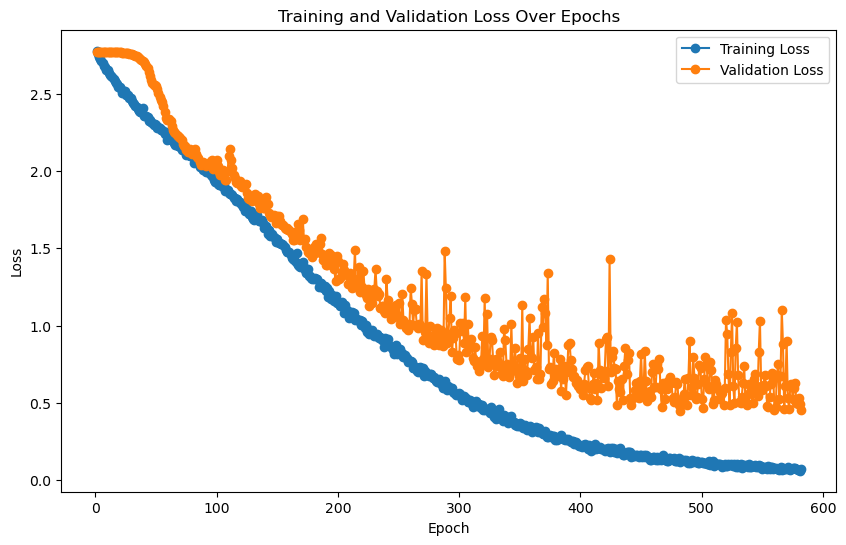

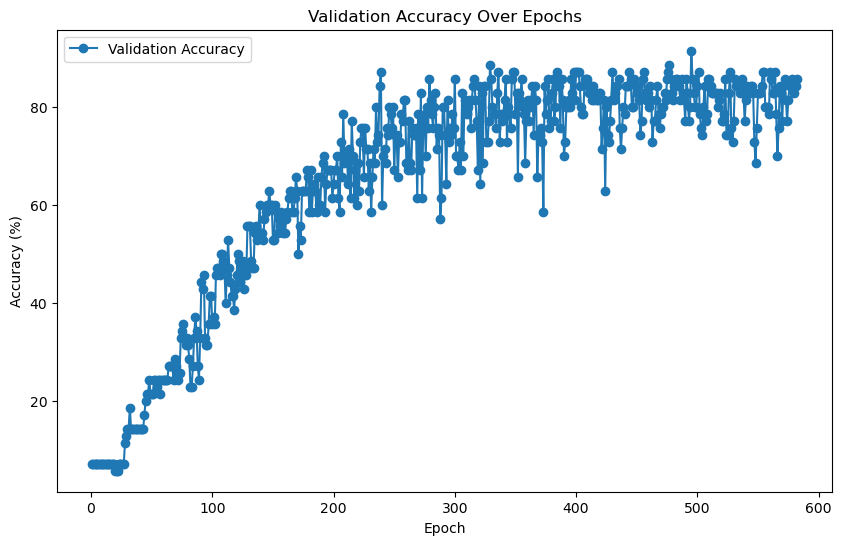


Evaluating on the test set...
    Test Batch [1/38], Loss: 1.2703

Final Test Loss: 0.8485, Test Accuracy: 75.84%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...


Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/38 for test dataset.
  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.


Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (9571, 64), Test labels shape: (9571,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 57.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.25      0.20      0.22         5
           2       0.50      0.20      0.29         5
           3       0.80      0.80      0.80         5
           4       1.00      0.40      0.57         5
           5       0.40      0.40      0.40         5
           6       0.00      0.00      0.00         0
           7       1.00      0.60      0.75         5
           9       0.50      0.60  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (9571, 64)
Test labels shape: (9571,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8356  |  Val Loss: 2.6939
Validation loss improved from inf to 2.6939.
[Epoch 2/1000] Train Loss: 2.6941  |  Val Loss: 2.6226
Validation loss improved from 2.6939 to 2.6226.
[Epoch 3/1000] Train Loss: 2.6119  |  Val Loss: 2.5663
Validation loss improved from 2.6226 to 2.5663.
[Epoch 4/1000] Train Loss: 2.5301  |  Val Loss: 2.4996
Validation loss improved from 2.5663 to 2.4996.
[Epoch 5/1000] Train Loss: 2.4509  |  Val Loss: 2.4263
Validation loss improved from 2.4996 to 2.4263.
[Epoch 6/1000] Train Loss: 2.3647  |  Val Loss: 2.3521
Validation loss improved from 2.4263 to 2.3521.
[Epoch 7/1000] Train Loss: 2.2753  |  Val Loss: 2.2708
Validation loss improved from 2.3521 to 2.2708.
[Epoch 8/1000] Train Loss: 2.1975  |  Val Loss: 2.1917
Validation loss improved from 2.2708 to 2.1917.
[Epoch 9/1000] Train Loss: 2.1014  |  Val Loss: 2.1341
Validation loss improved from 2.1917 to 2.1341.
[Epoch 10/1000] Train Loss: 2.0204  |  Val Loss: 2.0484
Validation loss impr

[Epoch 15/1000] Train Loss: 1.6283  |  Val Loss: 1.7394
Validation loss improved from 1.7805 to 1.7394.
[Epoch 16/1000] Train Loss: 1.5623  |  Val Loss: 1.6921
Validation loss improved from 1.7394 to 1.6921.
[Epoch 17/1000] Train Loss: 1.5033  |  Val Loss: 1.6484
Validation loss improved from 1.6921 to 1.6484.
[Epoch 18/1000] Train Loss: 1.4558  |  Val Loss: 1.6325
Validation loss improved from 1.6484 to 1.6325.
[Epoch 19/1000] Train Loss: 1.3969  |  Val Loss: 1.6003
Validation loss improved from 1.6325 to 1.6003.


[Epoch 20/1000] Train Loss: 1.3615  |  Val Loss: 1.5741
Validation loss improved from 1.6003 to 1.5741.
[Epoch 21/1000] Train Loss: 1.3249  |  Val Loss: 1.5493
Validation loss improved from 1.5741 to 1.5493.
[Epoch 22/1000] Train Loss: 1.2876  |  Val Loss: 1.5392
Validation loss improved from 1.5493 to 1.5392.
[Epoch 23/1000] Train Loss: 1.2657  |  Val Loss: 1.5187
Validation loss improved from 1.5392 to 1.5187.
[Epoch 24/1000] Train Loss: 1.2279  |  Val Loss: 1.4920
Validation loss improved from 1.5187 to 1.4920.
[Epoch 25/1000] Train Loss: 1.2020  |  Val Loss: 1.4971
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 26/1000] Train Loss: 1.1788  |  Val Loss: 1.4625
Validation loss improved from 1.4920 to 1.4625.
[Epoch 27/1000] Train Loss: 1.1575  |  Val Loss: 1.4437
Validation loss improved from 1.4625 to 1.4437.
[Epoch 28/1000] Train Loss: 1.1360  |  Val Loss: 1.4666
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 1.1071  |  Val Loss: 1.4

[Epoch 32/1000] Train Loss: 1.0647  |  Val Loss: 1.4264
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 33/1000] Train Loss: 1.0458  |  Val Loss: 1.3988
Validation loss improved from 1.4204 to 1.3988.
[Epoch 34/1000] Train Loss: 1.0203  |  Val Loss: 1.4245
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 1.0121  |  Val Loss: 1.4267
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 36/1000] Train Loss: 1.0071  |  Val Loss: 1.3974
Validation loss improved from 1.3988 to 1.3974.
[Epoch 37/1000] Train Loss: 0.9658  |  Val Loss: 1.3881
Validation loss improved from 1.3974 to 1.3881.
[Epoch 38/1000] Train Loss: 0.9669  |  Val Loss: 1.4110
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.9663  |  Val Loss: 1.3690
Validation loss improved from 1.3881 to 1.3690.
[Epoch 40/1000] Train Loss: 0.9404  |  Val Loss: 1.3810
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 0.9216  |  Val Loss: 1.4082
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 42/1000] Train Loss: 0.9207  |  Val Loss: 1.3957
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 43/1000] Train Loss: 0.8924  |  Val Loss: 1.3505
Validation loss improved from 1.3690 to 1.3505.
[Epoch 44/1000] Train Loss: 0.8894  |  Val Loss: 1.3611
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 0.8782

[Epoch 51/1000] Train Loss: 0.8101  |  Val Loss: 1.3767
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 52/1000] Train Loss: 0.8042  |  Val Loss: 1.3274
Validation loss improved from 1.3372 to 1.3274.
[Epoch 53/1000] Train Loss: 0.7961  |  Val Loss: 1.3609
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 54/1000] Train Loss: 0.7952  |  Val Loss: 1.3497
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 55/1000] Train Loss: 0.7737  |  Val Loss: 1.3266
Validation loss improved from 1.3274 to 1.3266.
[Epoch 56/1000] Train Loss: 0.7778  |  Val Loss: 1.3429
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.7543  |  Val Loss: 1.3733
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.7503  |  Val Loss: 1.3457
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 59/1000] Train Loss: 0.7363  |  Val Loss: 1.3327
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 60/1000] Train Loss: 0.7402  |  Val Loss: 1.3350
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 61/1000] Train Loss: 0.7191  |  Val Loss: 1.3372
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 62/1000] Train Loss: 0.7111  |  Val Loss: 1.3383
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 63/1000] 

[Epoch 69/1000] Train Loss: 0.6593  |  Val Loss: 1.3260
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 70/1000] Train Loss: 0.6445  |  Val Loss: 1.3252
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 71/1000] Train Loss: 0.6413  |  Val Loss: 1.3389
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 72/1000] Train Loss: 0.6365  |  Val Loss: 1.3529
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 73/1000] Train Loss: 0.6367  |  Val Loss: 1.3416
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 74/1000] Train Loss: 0.6285  |  Val Loss: 1.3412
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 75/1000] Train Loss: 0.6382  |  Val Loss: 1.3529
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 76/1000] Train Loss: 0.6284  |  Val Loss: 1.3485
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 77/1000] Train Loss: 0.6247  |  Val Loss: 1.3737
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 78/1000] Train Loss: 0.6203  |  Val Loss: 1.3720
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 79/1000] Train Loss: 0.6034  |  Val Loss: 1.3348
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 80/1000] Train Loss: 0.5988  |  Val Loss: 1.3382
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 81/1000] Train Loss: 0.5903  |  Val Loss: 1.3748
!! Validation loss did NOT improve !! Patience: 15/100
[Epo

[Epoch 86/1000] Train Loss: 0.5595  |  Val Loss: 1.3369
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 87/1000] Train Loss: 0.5610  |  Val Loss: 1.3996
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 88/1000] Train Loss: 0.5441  |  Val Loss: 1.4010
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 89/1000] Train Loss: 0.5404  |  Val Loss: 1.3716
!! Validation loss did NOT improve !! Patience: 23/100


[Epoch 90/1000] Train Loss: 0.5498  |  Val Loss: 1.3749
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 91/1000] Train Loss: 0.5295  |  Val Loss: 1.3534
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 92/1000] Train Loss: 0.5202  |  Val Loss: 1.3738
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 93/1000] Train Loss: 0.5242  |  Val Loss: 1.3783
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 94/1000] Train Loss: 0.5110  |  Val Loss: 1.4232
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 95/1000] Train Loss: 0.5230  |  Val Loss: 1.4035
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 96/1000] Train Loss: 0.5099  |  Val Loss: 1.3826
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 97/1000] Train Loss: 0.5016  |  Val Loss: 1.4201
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 98/1000] Train Loss: 0.4989  |  Val Loss: 1.4040
!! Validation loss did NOT improve !! Patience: 32/100
[

[Epoch 107/1000] Train Loss: 0.4877  |  Val Loss: 1.4816
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 108/1000] Train Loss: 0.4624  |  Val Loss: 1.4064
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 109/1000] Train Loss: 0.4621  |  Val Loss: 1.4431
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 110/1000] Train Loss: 0.4508  |  Val Loss: 1.4807
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 111/1000] Train Loss: 0.4497  |  Val Loss: 1.4361
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 112/1000] Train Loss: 0.4351  |  Val Loss: 1.4510
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 113/1000] Train Loss: 0.4317  |  Val Loss: 1.4579
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 114/1000] Train Loss: 0.4345  |  Val Loss: 1.4728
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 115/1000] Train Loss: 0.4263  |  Val Loss: 1.4565
!! Validation loss did NOT improve !! Patience:

[Epoch 125/1000] Train Loss: 0.3970  |  Val Loss: 1.5079
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 126/1000] Train Loss: 0.3858  |  Val Loss: 1.5052
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 127/1000] Train Loss: 0.3948  |  Val Loss: 1.4959
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 128/1000] Train Loss: 0.3941  |  Val Loss: 1.5130
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 129/1000] Train Loss: 0.3923  |  Val Loss: 1.5227
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 130/1000] Train Loss: 0.3893  |  Val Loss: 1.5354
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 131/1000] Train Loss: 0.3855  |  Val Loss: 1.4996
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 132/1000] Train Loss: 0.3660  |  Val Loss: 1.5507
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 133/1000] Train Loss: 0.3662  |  Val Loss: 1.5421
!! Validation loss did NOT improve !! Patience:

[Epoch 145/1000] Train Loss: 0.3441  |  Val Loss: 1.5812
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 146/1000] Train Loss: 0.3485  |  Val Loss: 1.6032
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 147/1000] Train Loss: 0.3467  |  Val Loss: 1.6064
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 148/1000] Train Loss: 0.3300  |  Val Loss: 1.6734
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 149/1000] Train Loss: 0.3255  |  Val Loss: 1.6093
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 150/1000] Train Loss: 0.3310  |  Val Loss: 1.6677
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 151/1000] Train Loss: 0.3345  |  Val Loss: 1.6221
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 152/1000] Train Loss: 0.3180  |  Val Loss: 1.5880
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 153/1000] Train Loss: 0.3216  |  Val Loss: 1.6566
!! Validation loss did NOT improve !! Patience:

[Epoch 164/1000] Train Loss: 0.2980  |  Val Loss: 1.6879
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 165/1000] Train Loss: 0.2956  |  Val Loss: 1.7101
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 166/1000] Train Loss: 0.2918  |  Val Loss: 1.7329
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 166 !!
No improvement for 100 epochs.


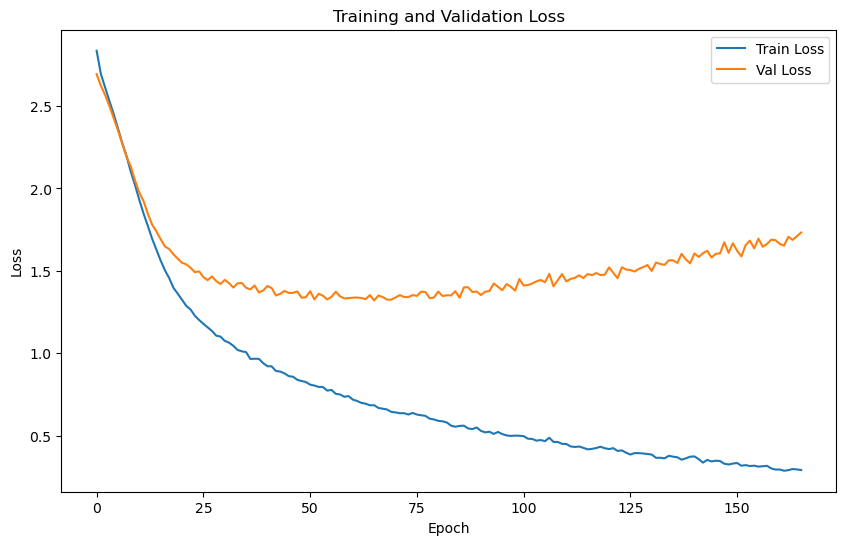

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.0231 | Test Accuracy: 48.59%


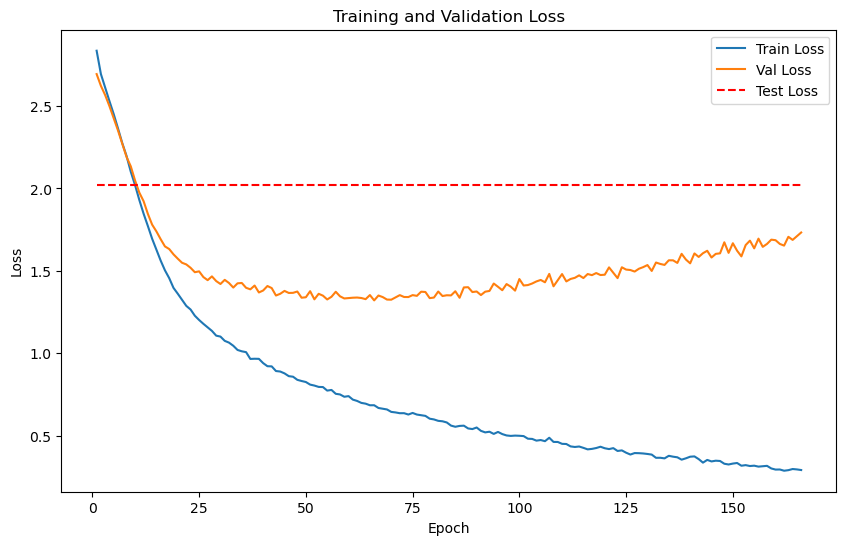

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.1285
Epoch [1/2000], Avg Train Loss: 9.1285
Epoch [1/2000], Avg Val Loss: 5.2884
Validation loss improved from inf to 5.2884. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.1302
Epoch [2/2000], Avg Train Loss: 9.1302
Epoch [2/2000], Avg Val Loss: 5.2294
Validation loss improved from 5.2884 to 5.2294. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.0916
Epoch [3/2000], Avg Train Loss: 9.0916
Epoch [3/2000], Avg Val Loss: 5.1715
Validation loss improved from 5.2294 to 5.1715. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.9485
Epoch [4/2000], Avg Train Loss: 8.9485
Epoch [4/2000], Avg Val Loss: 5.1151
Validation loss improved from 5.1715 to 5.1151. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.8500
Epoch [5/2000], Avg Train Loss: 8.8500
Epoch [5/2000], Avg Val Loss: 5.0600
Validation loss improved from 5.1151 to 5.0600. Saving mode

    Batch [1/1], Train Loss: 8.2567
Epoch [13/2000], Avg Train Loss: 8.2567
Epoch [13/2000], Avg Val Loss: 4.6629
Validation loss improved from 4.7084 to 4.6629. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 8.1281
Epoch [14/2000], Avg Train Loss: 8.1281
Epoch [14/2000], Avg Val Loss: 4.6188
Validation loss improved from 4.6629 to 4.6188. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 8.1723
Epoch [15/2000], Avg Train Loss: 8.1723
Epoch [15/2000], Avg Val Loss: 4.5758
Validation loss improved from 4.6188 to 4.5758. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 8.0728
Epoch [16/2000], Avg Train Loss: 8.0728
Epoch [16/2000], Avg Val Loss: 4.5339
Validation loss improved from 4.5758 to 4.5339. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 8.0050
Epoch [17/2000], Avg Train Loss: 8.0050
Epoch [17/2000], Avg Val Loss: 4.4932
Validation loss improved from 4.5339 to 4.

    Batch [1/1], Train Loss: 7.5274
Epoch [23/2000], Avg Train Loss: 7.5274
Epoch [23/2000], Avg Val Loss: 4.2736
Validation loss improved from 4.3073 to 4.2736. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.5292
Epoch [24/2000], Avg Train Loss: 7.5292
Epoch [24/2000], Avg Val Loss: 4.2408
Validation loss improved from 4.2736 to 4.2408. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.5192
Epoch [25/2000], Avg Train Loss: 7.5192
Epoch [25/2000], Avg Val Loss: 4.2090
Validation loss improved from 4.2408 to 4.2090. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.4966
Epoch [26/2000], Avg Train Loss: 7.4966
Epoch [26/2000], Avg Val Loss: 4.1783
Validation loss improved from 4.2090 to 4.1783. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.4355
Epoch [27/2000], Avg Train Loss: 7.4355
Epoch [27/2000], Avg Val Loss: 4.1485
Validation loss improved from 4.1783 to 4.

Epoch [36/2000], Avg Val Loss: 3.9243
Validation loss improved from 3.9457 to 3.9243. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.7296
Epoch [37/2000], Avg Train Loss: 6.7296
Epoch [37/2000], Avg Val Loss: 3.9039
Validation loss improved from 3.9243 to 3.9039. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.7436
Epoch [38/2000], Avg Train Loss: 6.7436
Epoch [38/2000], Avg Val Loss: 3.8843
Validation loss improved from 3.9039 to 3.8843. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.7567
Epoch [39/2000], Avg Train Loss: 6.7567
Epoch [39/2000], Avg Val Loss: 3.8654
Validation loss improved from 3.8843 to 3.8654. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.6484
Epoch [40/2000], Avg Train Loss: 6.6484
Epoch [40/2000], Avg Val Loss: 3.8473
Validation loss improved from 3.8654 to 3.8473. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.2984
Epoch [48/2000], Avg Train Loss: 6.2984
Epoch [48/2000], Avg Val Loss: 3.7266
Validation loss improved from 3.7395 to 3.7266. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.3051
Epoch [49/2000], Avg Train Loss: 6.3051
Epoch [49/2000], Avg Val Loss: 3.7144
Validation loss improved from 3.7266 to 3.7144. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.2772
Epoch [50/2000], Avg Train Loss: 6.2772
Epoch [50/2000], Avg Val Loss: 3.7027
Validation loss improved from 3.7144 to 3.7027. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.2850
Epoch [51/2000], Avg Train Loss: 6.2850
Epoch [51/2000], Avg Val Loss: 3.6914
Validation loss improved from 3.7027 to 3.6914. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.1866
Epoch [52/2000], Avg Train Loss: 6.1866
Epoch [52/2000], Avg Val Loss: 3.6807
Validation loss improved from 3.6914 to 3.

    Batch [1/1], Train Loss: 5.9081
Epoch [61/2000], Avg Train Loss: 5.9081
Epoch [61/2000], Avg Val Loss: 3.6023
Validation loss improved from 3.6095 to 3.6023. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.9270
Epoch [62/2000], Avg Train Loss: 5.9270
Epoch [62/2000], Avg Val Loss: 3.5954
Validation loss improved from 3.6023 to 3.5954. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.9029
Epoch [63/2000], Avg Train Loss: 5.9029
Epoch [63/2000], Avg Val Loss: 3.5889
Validation loss improved from 3.5954 to 3.5889. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.9199
Epoch [64/2000], Avg Train Loss: 5.9199
Epoch [64/2000], Avg Val Loss: 3.5826
Validation loss improved from 3.5889 to 3.5826. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.8213
Epoch [65/2000], Avg Train Loss: 5.8213
Epoch [65/2000], Avg Val Loss: 3.5767
Validation loss improved from 3.5826 to 3.

    Batch [1/1], Train Loss: 5.6922
Epoch [74/2000], Avg Train Loss: 5.6922
Epoch [74/2000], Avg Val Loss: 3.5332
Validation loss improved from 3.5372 to 3.5332. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.7668
Epoch [75/2000], Avg Train Loss: 5.7668
Epoch [75/2000], Avg Val Loss: 3.5293
Validation loss improved from 3.5332 to 3.5293. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.6801
Epoch [76/2000], Avg Train Loss: 5.6801
Epoch [76/2000], Avg Val Loss: 3.5255
Validation loss improved from 3.5293 to 3.5255. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.7124
Epoch [77/2000], Avg Train Loss: 5.7124
Epoch [77/2000], Avg Val Loss: 3.5219
Validation loss improved from 3.5255 to 3.5219. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.6731
Epoch [78/2000], Avg Train Loss: 5.6731
Epoch [78/2000], Avg Val Loss: 3.5184
Validation loss improved from 3.5219 to 3.

    Batch [1/1], Train Loss: 5.6122
Epoch [84/2000], Avg Train Loss: 5.6122
Epoch [84/2000], Avg Val Loss: 3.4995
Validation loss improved from 3.5024 to 3.4995. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.5965
Epoch [85/2000], Avg Train Loss: 5.5965
Epoch [85/2000], Avg Val Loss: 3.4967
Validation loss improved from 3.4995 to 3.4967. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 5.6017
Epoch [86/2000], Avg Train Loss: 5.6017
Epoch [86/2000], Avg Val Loss: 3.4940
Validation loss improved from 3.4967 to 3.4940. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.5832
Epoch [87/2000], Avg Train Loss: 5.5832
Epoch [87/2000], Avg Val Loss: 3.4914
Validation loss improved from 3.4940 to 3.4914. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.5306
Epoch [88/2000], Avg Train Loss: 5.5306
Epoch [88/2000], Avg Val Loss: 3.4889
Validation loss improved from 3.4914 to 3.

    Batch [1/1], Train Loss: 5.5165
Epoch [96/2000], Avg Train Loss: 5.5165
Epoch [96/2000], Avg Val Loss: 3.4712
Validation loss improved from 3.4732 to 3.4712. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.5144
Epoch [97/2000], Avg Train Loss: 5.5144
Epoch [97/2000], Avg Val Loss: 3.4692
Validation loss improved from 3.4712 to 3.4692. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 5.4750
Epoch [98/2000], Avg Train Loss: 5.4750
Epoch [98/2000], Avg Val Loss: 3.4673
Validation loss improved from 3.4692 to 3.4673. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 5.4899
Epoch [99/2000], Avg Train Loss: 5.4899
Epoch [99/2000], Avg Val Loss: 3.4654
Validation loss improved from 3.4673 to 3.4654. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 5.5314
Epoch [100/2000], Avg Train Loss: 5.5314
Epoch [100/2000], Avg Val Loss: 3.4636
Validation loss improved from 3.4654 to

Epoch [106/2000], Avg Val Loss: 3.4534
Validation loss improved from 3.4550 to 3.4534. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 5.4760
Epoch [107/2000], Avg Train Loss: 5.4760
Epoch [107/2000], Avg Val Loss: 3.4517
Validation loss improved from 3.4534 to 3.4517. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.3749
Epoch [108/2000], Avg Train Loss: 5.3749
Epoch [108/2000], Avg Val Loss: 3.4501
Validation loss improved from 3.4517 to 3.4501. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.4272
Epoch [109/2000], Avg Train Loss: 5.4272
Epoch [109/2000], Avg Val Loss: 3.4485
Validation loss improved from 3.4501 to 3.4485. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.3789
Epoch [110/2000], Avg Train Loss: 5.3789
Epoch [110/2000], Avg Val Loss: 3.4468
Validation loss improved from 3.4485 to 3.4468. Saving model...

LOG: Epoch [111/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.3492
Epoch [119/2000], Avg Train Loss: 5.3492
Epoch [119/2000], Avg Val Loss: 3.4337
Validation loss improved from 3.4351 to 3.4337. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 5.3370
Epoch [120/2000], Avg Train Loss: 5.3370
Epoch [120/2000], Avg Val Loss: 3.4324
Validation loss improved from 3.4337 to 3.4324. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 5.3276
Epoch [121/2000], Avg Train Loss: 5.3276
Epoch [121/2000], Avg Val Loss: 3.4310
Validation loss improved from 3.4324 to 3.4310. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 5.3175
Epoch [122/2000], Avg Train Loss: 5.3175
Epoch [122/2000], Avg Val Loss: 3.4297
Validation loss improved from 3.4310 to 3.4297. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 5.3261
Epoch [123/2000], Avg Train Loss: 5.3261
Epoch [123/2000], Avg Val Loss: 3.4284
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2969
Epoch [130/2000], Avg Train Loss: 5.2969
Epoch [130/2000], Avg Val Loss: 3.4197
Validation loss improved from 3.4209 to 3.4197. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 5.2797
Epoch [131/2000], Avg Train Loss: 5.2797
Epoch [131/2000], Avg Val Loss: 3.4184
Validation loss improved from 3.4197 to 3.4184. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 5.2933
Epoch [132/2000], Avg Train Loss: 5.2933
Epoch [132/2000], Avg Val Loss: 3.4172
Validation loss improved from 3.4184 to 3.4172. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 5.2634
Epoch [133/2000], Avg Train Loss: 5.2634
Epoch [133/2000], Avg Val Loss: 3.4160
Validation loss improved from 3.4172 to 3.4160. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 5.2594
Epoch [134/2000], Avg Train Loss: 5.2594
Epoch [134/2000], Avg Val Loss: 3.4148
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2219
Epoch [143/2000], Avg Train Loss: 5.2219
Epoch [143/2000], Avg Val Loss: 3.4046
Validation loss improved from 3.4057 to 3.4046. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 5.2242
Epoch [144/2000], Avg Train Loss: 5.2242
Epoch [144/2000], Avg Val Loss: 3.4035
Validation loss improved from 3.4046 to 3.4035. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.2769
Epoch [145/2000], Avg Train Loss: 5.2769
Epoch [145/2000], Avg Val Loss: 3.4024
Validation loss improved from 3.4035 to 3.4024. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.2348
Epoch [146/2000], Avg Train Loss: 5.2348
Epoch [146/2000], Avg Val Loss: 3.4013
Validation loss improved from 3.4024 to 3.4013. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.2323
Epoch [147/2000], Avg Train Loss: 5.2323
Epoch [147/2000], Avg Val Loss: 3.4002
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2220
Epoch [156/2000], Avg Train Loss: 5.2220
Epoch [156/2000], Avg Val Loss: 3.3904
Validation loss improved from 3.3914 to 3.3904. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 5.1806
Epoch [157/2000], Avg Train Loss: 5.1806
Epoch [157/2000], Avg Val Loss: 3.3893
Validation loss improved from 3.3904 to 3.3893. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 5.2074
Epoch [158/2000], Avg Train Loss: 5.2074
Epoch [158/2000], Avg Val Loss: 3.3882
Validation loss improved from 3.3893 to 3.3882. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 5.1511
Epoch [159/2000], Avg Train Loss: 5.1511
Epoch [159/2000], Avg Val Loss: 3.3872
Validation loss improved from 3.3882 to 3.3872. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 5.2046
Epoch [160/2000], Avg Train Loss: 5.2046
Epoch [160/2000], Avg Val Loss: 3.3862
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1690
Epoch [166/2000], Avg Train Loss: 5.1690
Epoch [166/2000], Avg Val Loss: 3.3800
Validation loss improved from 3.3810 to 3.3800. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 5.1705
Epoch [167/2000], Avg Train Loss: 5.1705
Epoch [167/2000], Avg Val Loss: 3.3790
Validation loss improved from 3.3800 to 3.3790. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 5.2029
Epoch [168/2000], Avg Train Loss: 5.2029
Epoch [168/2000], Avg Val Loss: 3.3780
Validation loss improved from 3.3790 to 3.3780. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 5.1717
Epoch [169/2000], Avg Train Loss: 5.1717
Epoch [169/2000], Avg Val Loss: 3.3769
Validation loss improved from 3.3780 to 3.3769. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 5.1938
Epoch [170/2000], Avg Train Loss: 5.1938
Epoch [170/2000], Avg Val Loss: 3.3759
Validation loss improved fro

Epoch [178/2000], Avg Val Loss: 3.3682
Validation loss improved from 3.3691 to 3.3682. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 5.1521
Epoch [179/2000], Avg Train Loss: 5.1521
Epoch [179/2000], Avg Val Loss: 3.3672
Validation loss improved from 3.3682 to 3.3672. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 5.1062
Epoch [180/2000], Avg Train Loss: 5.1062
Epoch [180/2000], Avg Val Loss: 3.3663
Validation loss improved from 3.3672 to 3.3663. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 5.1249
Epoch [181/2000], Avg Train Loss: 5.1249
Epoch [181/2000], Avg Val Loss: 3.3653
Validation loss improved from 3.3663 to 3.3653. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 5.1269
Epoch [182/2000], Avg Train Loss: 5.1269
Epoch [182/2000], Avg Val Loss: 3.3644
Validation loss improved from 3.3653 to 3.3644. Saving model...

LOG: Epoch [183/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.1059
Epoch [192/2000], Avg Train Loss: 5.1059
Epoch [192/2000], Avg Val Loss: 3.3553
Validation loss improved from 3.3562 to 3.3553. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 5.0620
Epoch [193/2000], Avg Train Loss: 5.0620
Epoch [193/2000], Avg Val Loss: 3.3544
Validation loss improved from 3.3553 to 3.3544. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 5.1067
Epoch [194/2000], Avg Train Loss: 5.1067
Epoch [194/2000], Avg Val Loss: 3.3535
Validation loss improved from 3.3544 to 3.3535. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 5.0832
Epoch [195/2000], Avg Train Loss: 5.0832
Epoch [195/2000], Avg Val Loss: 3.3526
Validation loss improved from 3.3535 to 3.3526. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 5.0963
Epoch [196/2000], Avg Train Loss: 5.0963
Epoch [196/2000], Avg Val Loss: 3.3518
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0964
Epoch [203/2000], Avg Train Loss: 5.0964
Epoch [203/2000], Avg Val Loss: 3.3459
Validation loss improved from 3.3467 to 3.3459. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 5.0523
Epoch [204/2000], Avg Train Loss: 5.0523
Epoch [204/2000], Avg Val Loss: 3.3451
Validation loss improved from 3.3459 to 3.3451. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 5.0416
Epoch [205/2000], Avg Train Loss: 5.0416
Epoch [205/2000], Avg Val Loss: 3.3443
Validation loss improved from 3.3451 to 3.3443. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 5.0839
Epoch [206/2000], Avg Train Loss: 5.0839
Epoch [206/2000], Avg Val Loss: 3.3435
Validation loss improved from 3.3443 to 3.3435. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 5.0777
Epoch [207/2000], Avg Train Loss: 5.0777
Epoch [207/2000], Avg Val Loss: 3.3428
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0298
Epoch [216/2000], Avg Train Loss: 5.0298
Epoch [216/2000], Avg Val Loss: 3.3357
Validation loss improved from 3.3365 to 3.3357. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 5.0360
Epoch [217/2000], Avg Train Loss: 5.0360
Epoch [217/2000], Avg Val Loss: 3.3349
Validation loss improved from 3.3357 to 3.3349. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 5.0603
Epoch [218/2000], Avg Train Loss: 5.0603
Epoch [218/2000], Avg Val Loss: 3.3341
Validation loss improved from 3.3349 to 3.3341. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 5.0669
Epoch [219/2000], Avg Train Loss: 5.0669
Epoch [219/2000], Avg Val Loss: 3.3333
Validation loss improved from 3.3341 to 3.3333. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 5.0501
Epoch [220/2000], Avg Train Loss: 5.0501
Epoch [220/2000], Avg Val Loss: 3.3326
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0004
Epoch [228/2000], Avg Train Loss: 5.0004
Epoch [228/2000], Avg Val Loss: 3.3265
Validation loss improved from 3.3273 to 3.3265. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.9976
Epoch [229/2000], Avg Train Loss: 4.9976
Epoch [229/2000], Avg Val Loss: 3.3257
Validation loss improved from 3.3265 to 3.3257. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.9783
Epoch [230/2000], Avg Train Loss: 4.9783
Epoch [230/2000], Avg Val Loss: 3.3249
Validation loss improved from 3.3257 to 3.3249. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 5.0285
Epoch [231/2000], Avg Train Loss: 5.0285
Epoch [231/2000], Avg Val Loss: 3.3240
Validation loss improved from 3.3249 to 3.3240. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.9640
Epoch [232/2000], Avg Train Loss: 4.9640
Epoch [232/2000], Avg Val Loss: 3.3232
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0126
Epoch [238/2000], Avg Train Loss: 5.0126
Epoch [238/2000], Avg Val Loss: 3.3184
Validation loss improved from 3.3192 to 3.3184. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.9978
Epoch [239/2000], Avg Train Loss: 4.9978
Epoch [239/2000], Avg Val Loss: 3.3176
Validation loss improved from 3.3184 to 3.3176. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 4.9776
Epoch [240/2000], Avg Train Loss: 4.9776
Epoch [240/2000], Avg Val Loss: 3.3168
Validation loss improved from 3.3176 to 3.3168. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 4.9927
Epoch [241/2000], Avg Train Loss: 4.9927
Epoch [241/2000], Avg Val Loss: 3.3160
Validation loss improved from 3.3168 to 3.3160. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 4.9709
Epoch [242/2000], Avg Train Loss: 4.9709
Epoch [242/2000], Avg Val Loss: 3.3152
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9577
Epoch [251/2000], Avg Train Loss: 4.9577
Epoch [251/2000], Avg Val Loss: 3.3085
Validation loss improved from 3.3092 to 3.3085. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 4.9957
Epoch [252/2000], Avg Train Loss: 4.9957
Epoch [252/2000], Avg Val Loss: 3.3078
Validation loss improved from 3.3085 to 3.3078. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.9916
Epoch [253/2000], Avg Train Loss: 4.9916
Epoch [253/2000], Avg Val Loss: 3.3072
Validation loss improved from 3.3078 to 3.3072. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 5.0081
Epoch [254/2000], Avg Train Loss: 5.0081
Epoch [254/2000], Avg Val Loss: 3.3065
Validation loss improved from 3.3072 to 3.3065. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.9903
Epoch [255/2000], Avg Train Loss: 4.9903
Epoch [255/2000], Avg Val Loss: 3.3059
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9275
Epoch [264/2000], Avg Train Loss: 4.9275
Epoch [264/2000], Avg Val Loss: 3.2998
Validation loss improved from 3.3005 to 3.2998. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.9630
Epoch [265/2000], Avg Train Loss: 4.9630
Epoch [265/2000], Avg Val Loss: 3.2991
Validation loss improved from 3.2998 to 3.2991. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.9555
Epoch [266/2000], Avg Train Loss: 4.9555
Epoch [266/2000], Avg Val Loss: 3.2984
Validation loss improved from 3.2991 to 3.2984. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.9533
Epoch [267/2000], Avg Train Loss: 4.9533
Epoch [267/2000], Avg Val Loss: 3.2977
Validation loss improved from 3.2984 to 3.2977. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.9040
Epoch [268/2000], Avg Train Loss: 4.9040
Epoch [268/2000], Avg Val Loss: 3.2970
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9539
Epoch [275/2000], Avg Train Loss: 4.9539
Epoch [275/2000], Avg Val Loss: 3.2921
Validation loss improved from 3.2928 to 3.2921. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.9165
Epoch [276/2000], Avg Train Loss: 4.9165
Epoch [276/2000], Avg Val Loss: 3.2914
Validation loss improved from 3.2921 to 3.2914. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.9259
Epoch [277/2000], Avg Train Loss: 4.9259
Epoch [277/2000], Avg Val Loss: 3.2907
Validation loss improved from 3.2914 to 3.2907. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 4.9768
Epoch [278/2000], Avg Train Loss: 4.9768
Epoch [278/2000], Avg Val Loss: 3.2901
Validation loss improved from 3.2907 to 3.2901. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 4.8850
Epoch [279/2000], Avg Train Loss: 4.8850
Epoch [279/2000], Avg Val Loss: 3.2894
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9042
Epoch [290/2000], Avg Train Loss: 4.9042
Epoch [290/2000], Avg Val Loss: 3.2820
Validation loss improved from 3.2826 to 3.2820. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.9098
Epoch [291/2000], Avg Train Loss: 4.9098
Epoch [291/2000], Avg Val Loss: 3.2814
Validation loss improved from 3.2820 to 3.2814. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.9286
Epoch [292/2000], Avg Train Loss: 4.9286
Epoch [292/2000], Avg Val Loss: 3.2808
Validation loss improved from 3.2814 to 3.2808. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.8962
Epoch [293/2000], Avg Train Loss: 4.8962
Epoch [293/2000], Avg Val Loss: 3.2802
Validation loss improved from 3.2808 to 3.2802. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.8962
Epoch [294/2000], Avg Train Loss: 4.8962
Epoch [294/2000], Avg Val Loss: 3.2795
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8855
Epoch [303/2000], Avg Train Loss: 4.8855
Epoch [303/2000], Avg Val Loss: 3.2737
Validation loss improved from 3.2744 to 3.2737. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.8750
Epoch [304/2000], Avg Train Loss: 4.8750
Epoch [304/2000], Avg Val Loss: 3.2731
Validation loss improved from 3.2737 to 3.2731. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.9045
Epoch [305/2000], Avg Train Loss: 4.9045
Epoch [305/2000], Avg Val Loss: 3.2724
Validation loss improved from 3.2731 to 3.2724. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.9002
Epoch [306/2000], Avg Train Loss: 4.9002
Epoch [306/2000], Avg Val Loss: 3.2718
Validation loss improved from 3.2724 to 3.2718. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.9086
Epoch [307/2000], Avg Train Loss: 4.9086
Epoch [307/2000], Avg Val Loss: 3.2712
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8616
Epoch [310/2000], Avg Train Loss: 4.8616
Epoch [310/2000], Avg Val Loss: 3.2694
Validation loss improved from 3.2700 to 3.2694. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 4.8874
Epoch [311/2000], Avg Train Loss: 4.8874
Epoch [311/2000], Avg Val Loss: 3.2688
Validation loss improved from 3.2694 to 3.2688. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 4.8762
Epoch [312/2000], Avg Train Loss: 4.8762
Epoch [312/2000], Avg Val Loss: 3.2683
Validation loss improved from 3.2688 to 3.2683. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.8856
Epoch [313/2000], Avg Train Loss: 4.8856
Epoch [313/2000], Avg Val Loss: 3.2677
Validation loss improved from 3.2683 to 3.2677. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.8299
Epoch [314/2000], Avg Train Loss: 4.8299
Epoch [314/2000], Avg Val Loss: 3.2672
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8668
Epoch [326/2000], Avg Train Loss: 4.8668
Epoch [326/2000], Avg Val Loss: 3.2607
Validation loss improved from 3.2612 to 3.2607. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.8739
Epoch [327/2000], Avg Train Loss: 4.8739
Epoch [327/2000], Avg Val Loss: 3.2602
Validation loss improved from 3.2607 to 3.2602. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.8648
Epoch [328/2000], Avg Train Loss: 4.8648
Epoch [328/2000], Avg Val Loss: 3.2596
Validation loss improved from 3.2602 to 3.2596. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.8622
Epoch [329/2000], Avg Train Loss: 4.8622
Epoch [329/2000], Avg Val Loss: 3.2590
Validation loss improved from 3.2596 to 3.2590. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.8292
Epoch [330/2000], Avg Train Loss: 4.8292
Epoch [330/2000], Avg Val Loss: 3.2584
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8486
Epoch [339/2000], Avg Train Loss: 4.8486
Epoch [339/2000], Avg Val Loss: 3.2533
Validation loss improved from 3.2539 to 3.2533. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.8207
Epoch [340/2000], Avg Train Loss: 4.8207
Epoch [340/2000], Avg Val Loss: 3.2528
Validation loss improved from 3.2533 to 3.2528. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.8573
Epoch [341/2000], Avg Train Loss: 4.8573
Epoch [341/2000], Avg Val Loss: 3.2522
Validation loss improved from 3.2528 to 3.2522. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.8414
Epoch [342/2000], Avg Train Loss: 4.8414
Epoch [342/2000], Avg Val Loss: 3.2517
Validation loss improved from 3.2522 to 3.2517. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 4.8531
Epoch [343/2000], Avg Train Loss: 4.8531
Epoch [343/2000], Avg Val Loss: 3.2512
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8098
Epoch [346/2000], Avg Train Loss: 4.8098
Epoch [346/2000], Avg Val Loss: 3.2496
Validation loss improved from 3.2502 to 3.2496. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.8181
Epoch [347/2000], Avg Train Loss: 4.8181
Epoch [347/2000], Avg Val Loss: 3.2491
Validation loss improved from 3.2496 to 3.2491. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.8119
Epoch [348/2000], Avg Train Loss: 4.8119
Epoch [348/2000], Avg Val Loss: 3.2486
Validation loss improved from 3.2491 to 3.2486. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.8324
Epoch [349/2000], Avg Train Loss: 4.8324
Epoch [349/2000], Avg Val Loss: 3.2480
Validation loss improved from 3.2486 to 3.2480. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.8257
Epoch [350/2000], Avg Train Loss: 4.8257
Epoch [350/2000], Avg Val Loss: 3.2475
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8062
Epoch [361/2000], Avg Train Loss: 4.8062
Epoch [361/2000], Avg Val Loss: 3.2417
Validation loss improved from 3.2421 to 3.2417. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 4.7981
Epoch [362/2000], Avg Train Loss: 4.7981
Epoch [362/2000], Avg Val Loss: 3.2412
Validation loss improved from 3.2417 to 3.2412. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 4.8320
Epoch [363/2000], Avg Train Loss: 4.8320
Epoch [363/2000], Avg Val Loss: 3.2408
Validation loss improved from 3.2412 to 3.2408. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 4.8123
Epoch [364/2000], Avg Train Loss: 4.8123
Epoch [364/2000], Avg Val Loss: 3.2403
Validation loss improved from 3.2408 to 3.2403. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 4.8099
Epoch [365/2000], Avg Train Loss: 4.8099
Epoch [365/2000], Avg Val Loss: 3.2399
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8037
Epoch [374/2000], Avg Train Loss: 4.8037
Epoch [374/2000], Avg Val Loss: 3.2357
Validation loss improved from 3.2362 to 3.2357. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.7463
Epoch [375/2000], Avg Train Loss: 4.7463
Epoch [375/2000], Avg Val Loss: 3.2352
Validation loss improved from 3.2357 to 3.2352. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.8075
Epoch [376/2000], Avg Train Loss: 4.8075
Epoch [376/2000], Avg Val Loss: 3.2347
Validation loss improved from 3.2352 to 3.2347. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.7996
Epoch [377/2000], Avg Train Loss: 4.7996
Epoch [377/2000], Avg Val Loss: 3.2343
Validation loss improved from 3.2347 to 3.2343. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.7852
Epoch [378/2000], Avg Train Loss: 4.7852
Epoch [378/2000], Avg Val Loss: 3.2338
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7745
Epoch [382/2000], Avg Train Loss: 4.7745
Epoch [382/2000], Avg Val Loss: 3.2322
Validation loss improved from 3.2326 to 3.2322. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.8078
Epoch [383/2000], Avg Train Loss: 4.8078
Epoch [383/2000], Avg Val Loss: 3.2318
Validation loss improved from 3.2322 to 3.2318. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.7696
Epoch [384/2000], Avg Train Loss: 4.7696
Epoch [384/2000], Avg Val Loss: 3.2314
Validation loss improved from 3.2318 to 3.2314. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.8283
Epoch [385/2000], Avg Train Loss: 4.8283
Epoch [385/2000], Avg Val Loss: 3.2310
Validation loss improved from 3.2314 to 3.2310. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.7725
Epoch [386/2000], Avg Train Loss: 4.7725
Epoch [386/2000], Avg Val Loss: 3.2306
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7852
Epoch [397/2000], Avg Train Loss: 4.7852
Epoch [397/2000], Avg Val Loss: 3.2258
Validation loss improved from 3.2263 to 3.2258. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.7541
Epoch [398/2000], Avg Train Loss: 4.7541
Epoch [398/2000], Avg Val Loss: 3.2253
Validation loss improved from 3.2258 to 3.2253. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 4.7273
Epoch [399/2000], Avg Train Loss: 4.7273
Epoch [399/2000], Avg Val Loss: 3.2248
Validation loss improved from 3.2253 to 3.2248. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 4.7523
Epoch [400/2000], Avg Train Loss: 4.7523
Epoch [400/2000], Avg Val Loss: 3.2242
Validation loss improved from 3.2248 to 3.2242. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 4.8010
Epoch [401/2000], Avg Train Loss: 4.8010
Epoch [401/2000], Avg Val Loss: 3.2237
Validation loss improved fro

Epoch [410/2000], Avg Val Loss: 3.2199
Validation loss improved from 3.2203 to 3.2199. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.7504
Epoch [411/2000], Avg Train Loss: 4.7504
Epoch [411/2000], Avg Val Loss: 3.2195
Validation loss improved from 3.2199 to 3.2195. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.7743
Epoch [412/2000], Avg Train Loss: 4.7743
Epoch [412/2000], Avg Val Loss: 3.2191
Validation loss improved from 3.2195 to 3.2191. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.7447
Epoch [413/2000], Avg Train Loss: 4.7447
Epoch [413/2000], Avg Val Loss: 3.2188
Validation loss improved from 3.2191 to 3.2188. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.7379
Epoch [414/2000], Avg Train Loss: 4.7379
Epoch [414/2000], Avg Val Loss: 3.2185
Validation loss improved from 3.2188 to 3.2185. Saving model...

LOG: Epoch [415/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7701
Epoch [418/2000], Avg Train Loss: 4.7701
Epoch [418/2000], Avg Val Loss: 3.2168
Validation loss improved from 3.2172 to 3.2168. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 4.7571
Epoch [419/2000], Avg Train Loss: 4.7571
Epoch [419/2000], Avg Val Loss: 3.2164
Validation loss improved from 3.2168 to 3.2164. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.7644
Epoch [420/2000], Avg Train Loss: 4.7644
Epoch [420/2000], Avg Val Loss: 3.2160
Validation loss improved from 3.2164 to 3.2160. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 4.7501
Epoch [421/2000], Avg Train Loss: 4.7501
Epoch [421/2000], Avg Val Loss: 3.2156
Validation loss improved from 3.2160 to 3.2156. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.7573
Epoch [422/2000], Avg Train Loss: 4.7573
Epoch [422/2000], Avg Val Loss: 3.2152
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7487
Epoch [431/2000], Avg Train Loss: 4.7487
Epoch [431/2000], Avg Val Loss: 3.2115
Validation loss improved from 3.2120 to 3.2115. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 4.7530
Epoch [432/2000], Avg Train Loss: 4.7530
Epoch [432/2000], Avg Val Loss: 3.2111
Validation loss improved from 3.2115 to 3.2111. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 4.7684
Epoch [433/2000], Avg Train Loss: 4.7684
Epoch [433/2000], Avg Val Loss: 3.2107
Validation loss improved from 3.2111 to 3.2107. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 4.7035
Epoch [434/2000], Avg Train Loss: 4.7035
Epoch [434/2000], Avg Val Loss: 3.2103
Validation loss improved from 3.2107 to 3.2103. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 4.7185
Epoch [435/2000], Avg Train Loss: 4.7185
Epoch [435/2000], Avg Val Loss: 3.2098
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7015
Epoch [448/2000], Avg Train Loss: 4.7015
Epoch [448/2000], Avg Val Loss: 3.2048
Validation loss improved from 3.2052 to 3.2048. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.7199
Epoch [449/2000], Avg Train Loss: 4.7199
Epoch [449/2000], Avg Val Loss: 3.2044
Validation loss improved from 3.2048 to 3.2044. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.7100
Epoch [450/2000], Avg Train Loss: 4.7100
Epoch [450/2000], Avg Val Loss: 3.2040
Validation loss improved from 3.2044 to 3.2040. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 4.7102
Epoch [451/2000], Avg Train Loss: 4.7102
Epoch [451/2000], Avg Val Loss: 3.2036
Validation loss improved from 3.2040 to 3.2036. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 4.7346
Epoch [452/2000], Avg Train Loss: 4.7346
Epoch [452/2000], Avg Val Loss: 3.2032
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7363
Epoch [458/2000], Avg Train Loss: 4.7363
Epoch [458/2000], Avg Val Loss: 3.2007
Validation loss improved from 3.2011 to 3.2007. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 4.7288
Epoch [459/2000], Avg Train Loss: 4.7288
Epoch [459/2000], Avg Val Loss: 3.2003
Validation loss improved from 3.2007 to 3.2003. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.7199
Epoch [460/2000], Avg Train Loss: 4.7199
Epoch [460/2000], Avg Val Loss: 3.1998
Validation loss improved from 3.2003 to 3.1998. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.6958
Epoch [461/2000], Avg Train Loss: 4.6958
Epoch [461/2000], Avg Val Loss: 3.1995
Validation loss improved from 3.1998 to 3.1995. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.6897
Epoch [462/2000], Avg Train Loss: 4.6897
Epoch [462/2000], Avg Val Loss: 3.1991
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7309
Epoch [469/2000], Avg Train Loss: 4.7309
Epoch [469/2000], Avg Val Loss: 3.1968
Validation loss improved from 3.1970 to 3.1968. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 4.7618
Epoch [470/2000], Avg Train Loss: 4.7618
Epoch [470/2000], Avg Val Loss: 3.1965
Validation loss improved from 3.1968 to 3.1965. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 4.7434
Epoch [471/2000], Avg Train Loss: 4.7434
Epoch [471/2000], Avg Val Loss: 3.1962
Validation loss improved from 3.1965 to 3.1962. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.7008
Epoch [472/2000], Avg Train Loss: 4.7008
Epoch [472/2000], Avg Val Loss: 3.1959
Validation loss improved from 3.1962 to 3.1959. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 4.7181
Epoch [473/2000], Avg Train Loss: 4.7181
Epoch [473/2000], Avg Val Loss: 3.1956
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6723
Epoch [485/2000], Avg Train Loss: 4.6723
Epoch [485/2000], Avg Val Loss: 3.1915
Validation loss improved from 3.1919 to 3.1915. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.6544
Epoch [486/2000], Avg Train Loss: 4.6544
Epoch [486/2000], Avg Val Loss: 3.1911
Validation loss improved from 3.1915 to 3.1911. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.6396
Epoch [487/2000], Avg Train Loss: 4.6396
Epoch [487/2000], Avg Val Loss: 3.1907
Validation loss improved from 3.1911 to 3.1907. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.6826
Epoch [488/2000], Avg Train Loss: 4.6826
Epoch [488/2000], Avg Val Loss: 3.1903
Validation loss improved from 3.1907 to 3.1903. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.6891
Epoch [489/2000], Avg Train Loss: 4.6891
Epoch [489/2000], Avg Val Loss: 3.1900
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6754
Epoch [496/2000], Avg Train Loss: 4.6754
Epoch [496/2000], Avg Val Loss: 3.1877
Validation loss improved from 3.1880 to 3.1877. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 4.6785
Epoch [497/2000], Avg Train Loss: 4.6785
Epoch [497/2000], Avg Val Loss: 3.1874
Validation loss improved from 3.1877 to 3.1874. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 4.6971
Epoch [498/2000], Avg Train Loss: 4.6971
Epoch [498/2000], Avg Val Loss: 3.1871
Validation loss improved from 3.1874 to 3.1871. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 4.6812
Epoch [499/2000], Avg Train Loss: 4.6812
Epoch [499/2000], Avg Val Loss: 3.1868
Validation loss improved from 3.1871 to 3.1868. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 4.6982
Epoch [500/2000], Avg Train Loss: 4.6982
Epoch [500/2000], Avg Val Loss: 3.1865
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6755
Epoch [504/2000], Avg Train Loss: 4.6755
Epoch [504/2000], Avg Val Loss: 3.1850
Validation loss improved from 3.1854 to 3.1850. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 4.7026
Epoch [505/2000], Avg Train Loss: 4.7026
Epoch [505/2000], Avg Val Loss: 3.1846
Validation loss improved from 3.1850 to 3.1846. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.6524
Epoch [506/2000], Avg Train Loss: 4.6524
Epoch [506/2000], Avg Val Loss: 3.1842
Validation loss improved from 3.1846 to 3.1842. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.6572
Epoch [507/2000], Avg Train Loss: 4.6572
Epoch [507/2000], Avg Val Loss: 3.1838
Validation loss improved from 3.1842 to 3.1838. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 4.6971
Epoch [508/2000], Avg Train Loss: 4.6971
Epoch [508/2000], Avg Val Loss: 3.1834
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6661
Epoch [521/2000], Avg Train Loss: 4.6661
Epoch [521/2000], Avg Val Loss: 3.1786
Validation loss improved from 3.1789 to 3.1786. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.6628
Epoch [522/2000], Avg Train Loss: 4.6628
Epoch [522/2000], Avg Val Loss: 3.1782
Validation loss improved from 3.1786 to 3.1782. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 4.6513
Epoch [523/2000], Avg Train Loss: 4.6513
Epoch [523/2000], Avg Val Loss: 3.1779
Validation loss improved from 3.1782 to 3.1779. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.6485
Epoch [524/2000], Avg Train Loss: 4.6485
Epoch [524/2000], Avg Val Loss: 3.1776
Validation loss improved from 3.1779 to 3.1776. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.6394
Epoch [525/2000], Avg Train Loss: 4.6394
Epoch [525/2000], Avg Val Loss: 3.1772
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6499
Epoch [535/2000], Avg Train Loss: 4.6499
Epoch [535/2000], Avg Val Loss: 3.1742
Validation loss improved from 3.1744 to 3.1742. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 4.6499
Epoch [536/2000], Avg Train Loss: 4.6499
Epoch [536/2000], Avg Val Loss: 3.1739
Validation loss improved from 3.1742 to 3.1739. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 4.6632
Epoch [537/2000], Avg Train Loss: 4.6632
Epoch [537/2000], Avg Val Loss: 3.1736
Validation loss improved from 3.1739 to 3.1736. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.6349
Epoch [538/2000], Avg Train Loss: 4.6349
Epoch [538/2000], Avg Val Loss: 3.1733
Validation loss improved from 3.1736 to 3.1733. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 4.6346
Epoch [539/2000], Avg Train Loss: 4.6346
Epoch [539/2000], Avg Val Loss: 3.1730
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6263
Epoch [544/2000], Avg Train Loss: 4.6263
Epoch [544/2000], Avg Val Loss: 3.1713
Validation loss improved from 3.1717 to 3.1713. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 4.6154
Epoch [545/2000], Avg Train Loss: 4.6154
Epoch [545/2000], Avg Val Loss: 3.1710
Validation loss improved from 3.1713 to 3.1710. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 4.6357
Epoch [546/2000], Avg Train Loss: 4.6357
Epoch [546/2000], Avg Val Loss: 3.1707
Validation loss improved from 3.1710 to 3.1707. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 4.6283
Epoch [547/2000], Avg Train Loss: 4.6283
Epoch [547/2000], Avg Val Loss: 3.1704
Validation loss improved from 3.1707 to 3.1704. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.6423
Epoch [548/2000], Avg Train Loss: 4.6423
Epoch [548/2000], Avg Val Loss: 3.1700
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6255
Epoch [561/2000], Avg Train Loss: 4.6255
Epoch [561/2000], Avg Val Loss: 3.1656
Validation loss improved from 3.1660 to 3.1656. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 4.6095
Epoch [562/2000], Avg Train Loss: 4.6095
Epoch [562/2000], Avg Val Loss: 3.1653
Validation loss improved from 3.1656 to 3.1653. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 4.6309
Epoch [563/2000], Avg Train Loss: 4.6309
Epoch [563/2000], Avg Val Loss: 3.1650
Validation loss improved from 3.1653 to 3.1650. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 4.6280
Epoch [564/2000], Avg Train Loss: 4.6280
Epoch [564/2000], Avg Val Loss: 3.1646
Validation loss improved from 3.1650 to 3.1646. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 4.6154
Epoch [565/2000], Avg Train Loss: 4.6154
Epoch [565/2000], Avg Val Loss: 3.1643
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6323
Epoch [574/2000], Avg Train Loss: 4.6323
Epoch [574/2000], Avg Val Loss: 3.1611
Validation loss improved from 3.1615 to 3.1611. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 4.6362
Epoch [575/2000], Avg Train Loss: 4.6362
Epoch [575/2000], Avg Val Loss: 3.1608
Validation loss improved from 3.1611 to 3.1608. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 4.6014
Epoch [576/2000], Avg Train Loss: 4.6014
Epoch [576/2000], Avg Val Loss: 3.1605
Validation loss improved from 3.1608 to 3.1605. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 4.6363
Epoch [577/2000], Avg Train Loss: 4.6363
Epoch [577/2000], Avg Val Loss: 3.1602
Validation loss improved from 3.1605 to 3.1602. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 4.5971
Epoch [578/2000], Avg Train Loss: 4.5971
Epoch [578/2000], Avg Val Loss: 3.1599
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6197
Epoch [582/2000], Avg Train Loss: 4.6197
Epoch [582/2000], Avg Val Loss: 3.1588
Validation loss improved from 3.1590 to 3.1588. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.5971
Epoch [583/2000], Avg Train Loss: 4.5971
Epoch [583/2000], Avg Val Loss: 3.1585
Validation loss improved from 3.1588 to 3.1585. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 4.6340
Epoch [584/2000], Avg Train Loss: 4.6340
Epoch [584/2000], Avg Val Loss: 3.1582
Validation loss improved from 3.1585 to 3.1582. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 4.6353
Epoch [585/2000], Avg Train Loss: 4.6353
Epoch [585/2000], Avg Val Loss: 3.1579
Validation loss improved from 3.1582 to 3.1579. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 4.6054
Epoch [586/2000], Avg Train Loss: 4.6054
Epoch [586/2000], Avg Val Loss: 3.1575
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5756
Epoch [595/2000], Avg Train Loss: 4.5756
Epoch [595/2000], Avg Val Loss: 3.1545
Validation loss improved from 3.1548 to 3.1545. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 4.5912
Epoch [596/2000], Avg Train Loss: 4.5912
Epoch [596/2000], Avg Val Loss: 3.1541
Validation loss improved from 3.1545 to 3.1541. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 4.5973
Epoch [597/2000], Avg Train Loss: 4.5973
Epoch [597/2000], Avg Val Loss: 3.1538
Validation loss improved from 3.1541 to 3.1538. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.5817
Epoch [598/2000], Avg Train Loss: 4.5817
Epoch [598/2000], Avg Val Loss: 3.1535
Validation loss improved from 3.1538 to 3.1535. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 4.6227
Epoch [599/2000], Avg Train Loss: 4.6227
Epoch [599/2000], Avg Val Loss: 3.1532
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5734
Epoch [612/2000], Avg Train Loss: 4.5734
Epoch [612/2000], Avg Val Loss: 3.1497
Validation loss improved from 3.1500 to 3.1497. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 4.6093
Epoch [613/2000], Avg Train Loss: 4.6093
Epoch [613/2000], Avg Val Loss: 3.1494
Validation loss improved from 3.1497 to 3.1494. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 4.6223
Epoch [614/2000], Avg Train Loss: 4.6223
Epoch [614/2000], Avg Val Loss: 3.1491
Validation loss improved from 3.1494 to 3.1491. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 4.5944
Epoch [615/2000], Avg Train Loss: 4.5944
Epoch [615/2000], Avg Val Loss: 3.1488
Validation loss improved from 3.1491 to 3.1488. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 4.5951
Epoch [616/2000], Avg Train Loss: 4.5951
Epoch [616/2000], Avg Val Loss: 3.1485
Validation loss improved fro

Epoch [619/2000], Avg Val Loss: 3.1479
Validation loss improved from 3.1480 to 3.1479. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.5826
Epoch [620/2000], Avg Train Loss: 4.5826
Epoch [620/2000], Avg Val Loss: 3.1477
Validation loss improved from 3.1479 to 3.1477. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.5932
Epoch [621/2000], Avg Train Loss: 4.5932
Epoch [621/2000], Avg Val Loss: 3.1475
Validation loss improved from 3.1477 to 3.1475. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 4.5706
Epoch [622/2000], Avg Train Loss: 4.5706
Epoch [622/2000], Avg Val Loss: 3.1473
Validation loss improved from 3.1475 to 3.1473. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 4.5956
Epoch [623/2000], Avg Train Loss: 4.5956
Epoch [623/2000], Avg Val Loss: 3.1471
Validation loss improved from 3.1473 to 3.1471. Saving model...

LOG: Epoch [624/2000] - Training
    Bat

Epoch [632/2000], Avg Val Loss: 3.1450
Validation loss improved from 3.1452 to 3.1450. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.5903
Epoch [633/2000], Avg Train Loss: 4.5903
Epoch [633/2000], Avg Val Loss: 3.1449
Validation loss improved from 3.1450 to 3.1449. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 4.5650
Epoch [634/2000], Avg Train Loss: 4.5650
Epoch [634/2000], Avg Val Loss: 3.1447
Validation loss improved from 3.1449 to 3.1447. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 4.5794
Epoch [635/2000], Avg Train Loss: 4.5794
Epoch [635/2000], Avg Val Loss: 3.1445
Validation loss improved from 3.1447 to 3.1445. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 4.5901
Epoch [636/2000], Avg Train Loss: 4.5901
Epoch [636/2000], Avg Val Loss: 3.1443
Validation loss improved from 3.1445 to 3.1443. Saving model...

LOG: Epoch [637/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5523
Epoch [649/2000], Avg Train Loss: 4.5523
Epoch [649/2000], Avg Val Loss: 3.1413
Validation loss improved from 3.1415 to 3.1413. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 4.5808
Epoch [650/2000], Avg Train Loss: 4.5808
Epoch [650/2000], Avg Val Loss: 3.1410
Validation loss improved from 3.1413 to 3.1410. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 4.5728
Epoch [651/2000], Avg Train Loss: 4.5728
Epoch [651/2000], Avg Val Loss: 3.1406
Validation loss improved from 3.1410 to 3.1406. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 4.5597
Epoch [652/2000], Avg Train Loss: 4.5597
Epoch [652/2000], Avg Val Loss: 3.1403
Validation loss improved from 3.1406 to 3.1403. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 4.5731
Epoch [653/2000], Avg Train Loss: 4.5731
Epoch [653/2000], Avg Val Loss: 3.1400
Validation loss improved fro

Epoch [657/2000], Avg Val Loss: 3.1391
Validation loss improved from 3.1393 to 3.1391. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.5629
Epoch [658/2000], Avg Train Loss: 4.5629
Epoch [658/2000], Avg Val Loss: 3.1388
Validation loss improved from 3.1391 to 3.1388. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 4.5560
Epoch [659/2000], Avg Train Loss: 4.5560
Epoch [659/2000], Avg Val Loss: 3.1386
Validation loss improved from 3.1388 to 3.1386. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 4.5953
Epoch [660/2000], Avg Train Loss: 4.5953
Epoch [660/2000], Avg Val Loss: 3.1384
Validation loss improved from 3.1386 to 3.1384. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 4.5692
Epoch [661/2000], Avg Train Loss: 4.5692
Epoch [661/2000], Avg Val Loss: 3.1382
Validation loss improved from 3.1384 to 3.1382. Saving model...

LOG: Epoch [662/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5585
Epoch [671/2000], Avg Train Loss: 4.5585
Epoch [671/2000], Avg Val Loss: 3.1358
Validation loss improved from 3.1360 to 3.1358. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 4.5741
Epoch [672/2000], Avg Train Loss: 4.5741
Epoch [672/2000], Avg Val Loss: 3.1355
Validation loss improved from 3.1358 to 3.1355. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 4.5498
Epoch [673/2000], Avg Train Loss: 4.5498
Epoch [673/2000], Avg Val Loss: 3.1353
Validation loss improved from 3.1355 to 3.1353. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 4.5492
Epoch [674/2000], Avg Train Loss: 4.5492
Epoch [674/2000], Avg Val Loss: 3.1351
Validation loss improved from 3.1353 to 3.1351. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 4.5444
Epoch [675/2000], Avg Train Loss: 4.5444
Epoch [675/2000], Avg Val Loss: 3.1349
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5366
Epoch [686/2000], Avg Train Loss: 4.5366
Epoch [686/2000], Avg Val Loss: 3.1314
Validation loss improved from 3.1317 to 3.1314. Saving model...

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 4.5677
Epoch [687/2000], Avg Train Loss: 4.5677
Epoch [687/2000], Avg Val Loss: 3.1311
Validation loss improved from 3.1314 to 3.1311. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 4.5235
Epoch [688/2000], Avg Train Loss: 4.5235
Epoch [688/2000], Avg Val Loss: 3.1309
Validation loss improved from 3.1311 to 3.1309. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 4.5565
Epoch [689/2000], Avg Train Loss: 4.5565
Epoch [689/2000], Avg Val Loss: 3.1305
Validation loss improved from 3.1309 to 3.1305. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 4.5081
Epoch [690/2000], Avg Train Loss: 4.5081
Epoch [690/2000], Avg Val Loss: 3.1302
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5510
Epoch [694/2000], Avg Train Loss: 4.5510
Epoch [694/2000], Avg Val Loss: 3.1292
Validation loss improved from 3.1294 to 3.1292. Saving model...

LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 4.5478
Epoch [695/2000], Avg Train Loss: 4.5478
Epoch [695/2000], Avg Val Loss: 3.1289
Validation loss improved from 3.1292 to 3.1289. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.5504
Epoch [696/2000], Avg Train Loss: 4.5504
Epoch [696/2000], Avg Val Loss: 3.1287
Validation loss improved from 3.1289 to 3.1287. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 4.5391
Epoch [697/2000], Avg Train Loss: 4.5391
Epoch [697/2000], Avg Val Loss: 3.1284
Validation loss improved from 3.1287 to 3.1284. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 4.5099
Epoch [698/2000], Avg Train Loss: 4.5099
Epoch [698/2000], Avg Val Loss: 3.1282
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5204
Epoch [705/2000], Avg Train Loss: 4.5204
Epoch [705/2000], Avg Val Loss: 3.1269
Validation loss improved from 3.1271 to 3.1269. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 4.5139
Epoch [706/2000], Avg Train Loss: 4.5139
Epoch [706/2000], Avg Val Loss: 3.1267
Validation loss improved from 3.1269 to 3.1267. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 4.5713
Epoch [707/2000], Avg Train Loss: 4.5713
Epoch [707/2000], Avg Val Loss: 3.1264
Validation loss improved from 3.1267 to 3.1264. Saving model...

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 4.5392
Epoch [708/2000], Avg Train Loss: 4.5392
Epoch [708/2000], Avg Val Loss: 3.1262
Validation loss improved from 3.1264 to 3.1262. Saving model...

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 4.5321
Epoch [709/2000], Avg Train Loss: 4.5321
Epoch [709/2000], Avg Val Loss: 3.1259
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5162
Epoch [724/2000], Avg Train Loss: 4.5162
Epoch [724/2000], Avg Val Loss: 3.1237
Validation loss improved from 3.1239 to 3.1237. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 4.5310
Epoch [725/2000], Avg Train Loss: 4.5310
Epoch [725/2000], Avg Val Loss: 3.1236
Validation loss improved from 3.1237 to 3.1236. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 4.5212
Epoch [726/2000], Avg Train Loss: 4.5212
Epoch [726/2000], Avg Val Loss: 3.1234
Validation loss improved from 3.1236 to 3.1234. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 4.4843
Epoch [727/2000], Avg Train Loss: 4.4843
Epoch [727/2000], Avg Val Loss: 3.1233
Validation loss improved from 3.1234 to 3.1233. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 4.5594
Epoch [728/2000], Avg Train Loss: 4.5594
Epoch [728/2000], Avg Val Loss: 3.1231
Validation loss improved fro

Epoch [731/2000], Avg Val Loss: 3.1224
Validation loss improved from 3.1227 to 3.1224. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 4.5164
Epoch [732/2000], Avg Train Loss: 4.5164
Epoch [732/2000], Avg Val Loss: 3.1222
Validation loss improved from 3.1224 to 3.1222. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 4.5353
Epoch [733/2000], Avg Train Loss: 4.5353
Epoch [733/2000], Avg Val Loss: 3.1220
Validation loss improved from 3.1222 to 3.1220. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 4.5131
Epoch [734/2000], Avg Train Loss: 4.5131
Epoch [734/2000], Avg Val Loss: 3.1218
Validation loss improved from 3.1220 to 3.1218. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 4.5066
Epoch [735/2000], Avg Train Loss: 4.5066
Epoch [735/2000], Avg Val Loss: 3.1216
Validation loss improved from 3.1218 to 3.1216. Saving model...

LOG: Epoch [736/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5306
Epoch [739/2000], Avg Train Loss: 4.5306
Epoch [739/2000], Avg Val Loss: 3.1209
Validation loss improved from 3.1211 to 3.1209. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 4.4969
Epoch [740/2000], Avg Train Loss: 4.4969
Epoch [740/2000], Avg Val Loss: 3.1207
Validation loss improved from 3.1209 to 3.1207. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.5200
Epoch [741/2000], Avg Train Loss: 4.5200
Epoch [741/2000], Avg Val Loss: 3.1204
Validation loss improved from 3.1207 to 3.1204. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 4.4886
Epoch [742/2000], Avg Train Loss: 4.4886
Epoch [742/2000], Avg Val Loss: 3.1202
Validation loss improved from 3.1204 to 3.1202. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.5100
Epoch [743/2000], Avg Train Loss: 4.5100
Epoch [743/2000], Avg Val Loss: 3.1200
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5094
Epoch [761/2000], Avg Train Loss: 4.5094
Epoch [761/2000], Avg Val Loss: 3.1164
Validation loss improved from 3.1165 to 3.1164. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 4.5321
Epoch [762/2000], Avg Train Loss: 4.5321
Epoch [762/2000], Avg Val Loss: 3.1163
Validation loss improved from 3.1164 to 3.1163. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 4.5054
Epoch [763/2000], Avg Train Loss: 4.5054
Epoch [763/2000], Avg Val Loss: 3.1161
Validation loss improved from 3.1163 to 3.1161. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 4.5314
Epoch [764/2000], Avg Train Loss: 4.5314
Epoch [764/2000], Avg Val Loss: 3.1159
Validation loss improved from 3.1161 to 3.1159. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.4857
Epoch [765/2000], Avg Train Loss: 4.4857
Epoch [765/2000], Avg Val Loss: 3.1157
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5178
Epoch [770/2000], Avg Train Loss: 4.5178
Epoch [770/2000], Avg Val Loss: 3.1150
Validation loss improved from 3.1152 to 3.1150. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 4.4832
Epoch [771/2000], Avg Train Loss: 4.4832
Epoch [771/2000], Avg Val Loss: 3.1147
Validation loss improved from 3.1150 to 3.1147. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 4.5228
Epoch [772/2000], Avg Train Loss: 4.5228
Epoch [772/2000], Avg Val Loss: 3.1145
Validation loss improved from 3.1147 to 3.1145. Saving model...

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 4.4697
Epoch [773/2000], Avg Train Loss: 4.4697
Epoch [773/2000], Avg Val Loss: 3.1143
Validation loss improved from 3.1145 to 3.1143. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 4.4854
Epoch [774/2000], Avg Train Loss: 4.4854
Epoch [774/2000], Avg Val Loss: 3.1140
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5143
Epoch [778/2000], Avg Train Loss: 4.5143
Epoch [778/2000], Avg Val Loss: 3.1132
Validation loss improved from 3.1134 to 3.1132. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 4.4638
Epoch [779/2000], Avg Train Loss: 4.4638
Epoch [779/2000], Avg Val Loss: 3.1129
Validation loss improved from 3.1132 to 3.1129. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 4.5030
Epoch [780/2000], Avg Train Loss: 4.5030
Epoch [780/2000], Avg Val Loss: 3.1127
Validation loss improved from 3.1129 to 3.1127. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 4.4709
Epoch [781/2000], Avg Train Loss: 4.4709
Epoch [781/2000], Avg Val Loss: 3.1124
Validation loss improved from 3.1127 to 3.1124. Saving model...

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 4.4950
Epoch [782/2000], Avg Train Loss: 4.4950
Epoch [782/2000], Avg Val Loss: 3.1122
Validation loss improved fro

Epoch [799/2000], Avg Val Loss: 3.1084
Validation loss improved from 3.1087 to 3.1084. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 4.4349
Epoch [800/2000], Avg Train Loss: 4.4349
Epoch [800/2000], Avg Val Loss: 3.1082
Validation loss improved from 3.1084 to 3.1082. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 4.4841
Epoch [801/2000], Avg Train Loss: 4.4841
Epoch [801/2000], Avg Val Loss: 3.1080
Validation loss improved from 3.1082 to 3.1080. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 4.4924
Epoch [802/2000], Avg Train Loss: 4.4924
Epoch [802/2000], Avg Val Loss: 3.1078
Validation loss improved from 3.1080 to 3.1078. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 4.5188
Epoch [803/2000], Avg Train Loss: 4.5188
Epoch [803/2000], Avg Val Loss: 3.1076
Validation loss improved from 3.1078 to 3.1076. Saving model...

LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 4.4853
Epoch [804/2000], Avg Train Loss: 4.4853
Epoch [804/2000], Avg Val Loss: 3.1074
Validation loss improved from 3.1076 to 3.1074. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 4.4634
Epoch [805/2000], Avg Train Loss: 4.4634
Epoch [805/2000], Avg Val Loss: 3.1072
Validation loss improved from 3.1074 to 3.1072. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 4.4686
Epoch [806/2000], Avg Train Loss: 4.4686
Epoch [806/2000], Avg Val Loss: 3.1069
Validation loss improved from 3.1072 to 3.1069. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 4.4786
Epoch [807/2000], Avg Train Loss: 4.4786
Epoch [807/2000], Avg Val Loss: 3.1066
Validation loss improved from 3.1069 to 3.1066. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 4.4287
Epoch [808/2000], Avg Train Loss: 4.4287
Epoch [808/2000], Avg Val Loss: 3.1064
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4817
Epoch [813/2000], Avg Train Loss: 4.4817
Epoch [813/2000], Avg Val Loss: 3.1054
Validation loss improved from 3.1055 to 3.1054. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 4.4765
Epoch [814/2000], Avg Train Loss: 4.4765
Epoch [814/2000], Avg Val Loss: 3.1052
Validation loss improved from 3.1054 to 3.1052. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 4.4726
Epoch [815/2000], Avg Train Loss: 4.4726
Epoch [815/2000], Avg Val Loss: 3.1050
Validation loss improved from 3.1052 to 3.1050. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 4.4866
Epoch [816/2000], Avg Train Loss: 4.4866
Epoch [816/2000], Avg Val Loss: 3.1048
Validation loss improved from 3.1050 to 3.1048. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 4.4467
Epoch [817/2000], Avg Train Loss: 4.4467
Epoch [817/2000], Avg Val Loss: 3.1045
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4415
Epoch [836/2000], Avg Train Loss: 4.4415
Epoch [836/2000], Avg Val Loss: 3.1003
Validation loss improved from 3.1004 to 3.1003. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 4.4825
Epoch [837/2000], Avg Train Loss: 4.4825
Epoch [837/2000], Avg Val Loss: 3.1001
Validation loss improved from 3.1003 to 3.1001. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 4.4841
Epoch [838/2000], Avg Train Loss: 4.4841
Epoch [838/2000], Avg Val Loss: 3.1000
Validation loss improved from 3.1001 to 3.1000. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 4.4659
Epoch [839/2000], Avg Train Loss: 4.4659
Epoch [839/2000], Avg Val Loss: 3.0998
Validation loss improved from 3.1000 to 3.0998. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 4.4626
Epoch [840/2000], Avg Train Loss: 4.4626
Epoch [840/2000], Avg Val Loss: 3.0995
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4320
Epoch [844/2000], Avg Train Loss: 4.4320
Epoch [844/2000], Avg Val Loss: 3.0982
Validation loss improved from 3.0985 to 3.0982. Saving model...

LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 4.4706
Epoch [845/2000], Avg Train Loss: 4.4706
Epoch [845/2000], Avg Val Loss: 3.0980
Validation loss improved from 3.0982 to 3.0980. Saving model...

LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 4.4579
Epoch [846/2000], Avg Train Loss: 4.4579
Epoch [846/2000], Avg Val Loss: 3.0979
Validation loss improved from 3.0980 to 3.0979. Saving model...

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 4.4574
Epoch [847/2000], Avg Train Loss: 4.4574
Epoch [847/2000], Avg Val Loss: 3.0977
Validation loss improved from 3.0979 to 3.0977. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 4.4067
Epoch [848/2000], Avg Train Loss: 4.4067
Epoch [848/2000], Avg Val Loss: 3.0976
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4532
Epoch [852/2000], Avg Train Loss: 4.4532
Epoch [852/2000], Avg Val Loss: 3.0972
Validation loss improved from 3.0973 to 3.0972. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 4.4642
Epoch [853/2000], Avg Train Loss: 4.4642
Epoch [853/2000], Avg Val Loss: 3.0971
Validation loss improved from 3.0972 to 3.0971. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 4.4514
Epoch [854/2000], Avg Train Loss: 4.4514
Epoch [854/2000], Avg Val Loss: 3.0970
Validation loss improved from 3.0971 to 3.0970. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 4.4448
Epoch [855/2000], Avg Train Loss: 4.4448
Epoch [855/2000], Avg Val Loss: 3.0969
Validation loss improved from 3.0970 to 3.0969. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 4.4559
Epoch [856/2000], Avg Train Loss: 4.4559
Epoch [856/2000], Avg Val Loss: 3.0968
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4470
Epoch [857/2000], Avg Train Loss: 4.4470
Epoch [857/2000], Avg Val Loss: 3.0967
Validation loss improved from 3.0968 to 3.0967. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 4.4261
Epoch [858/2000], Avg Train Loss: 4.4261
Epoch [858/2000], Avg Val Loss: 3.0967
Validation loss improved from 3.0967 to 3.0967. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 4.4527
Epoch [859/2000], Avg Train Loss: 4.4527
Epoch [859/2000], Avg Val Loss: 3.0967
Validation loss improved from 3.0967 to 3.0967. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 4.4564
Epoch [860/2000], Avg Train Loss: 4.4564
Epoch [860/2000], Avg Val Loss: 3.0967
Validation loss improved from 3.0967 to 3.0967. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 4.4340
Epoch [861/2000], Avg Train Loss: 4.4340
Epoch [861/2000], Avg Val Loss: 3.0967
Validation loss did not impr

    Batch [1/1], Train Loss: 4.4751
Epoch [866/2000], Avg Train Loss: 4.4751
Epoch [866/2000], Avg Val Loss: 3.0964
Validation loss improved from 3.0964 to 3.0964. Saving model...

LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 4.4350
Epoch [867/2000], Avg Train Loss: 4.4350
Epoch [867/2000], Avg Val Loss: 3.0963
Validation loss improved from 3.0964 to 3.0963. Saving model...

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 4.4237
Epoch [868/2000], Avg Train Loss: 4.4237
Epoch [868/2000], Avg Val Loss: 3.0961
Validation loss improved from 3.0963 to 3.0961. Saving model...

LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 4.4430
Epoch [869/2000], Avg Train Loss: 4.4430
Epoch [869/2000], Avg Val Loss: 3.0961
Validation loss improved from 3.0961 to 3.0961. Saving model...

LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 4.4621
Epoch [870/2000], Avg Train Loss: 4.4621
Epoch [870/2000], Avg Val Loss: 3.0960
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4283
Epoch [874/2000], Avg Train Loss: 4.4283
Epoch [874/2000], Avg Val Loss: 3.0960
Validation loss did not improve. Patience: 2/100

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 4.4664
Epoch [875/2000], Avg Train Loss: 4.4664
Epoch [875/2000], Avg Val Loss: 3.0961
Validation loss did not improve. Patience: 3/100

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 4.4479
Epoch [876/2000], Avg Train Loss: 4.4479
Epoch [876/2000], Avg Val Loss: 3.0961
Validation loss did not improve. Patience: 4/100

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 4.4545
Epoch [877/2000], Avg Train Loss: 4.4545
Epoch [877/2000], Avg Val Loss: 3.0962
Validation loss did not improve. Patience: 5/100

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 4.4366
Epoch [878/2000], Avg Train Loss: 4.4366
Epoch [878/2000], Avg Val Loss: 3.0962
Validation loss did not improve. Patience: 6/100

LOG: Epoch [879/2000] - Training
    B

    Batch [1/1], Train Loss: 4.4306
Epoch [893/2000], Avg Train Loss: 4.4306
Epoch [893/2000], Avg Val Loss: 3.0937
Validation loss improved from 3.0939 to 3.0937. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 4.3949
Epoch [894/2000], Avg Train Loss: 4.3949
Epoch [894/2000], Avg Val Loss: 3.0936
Validation loss improved from 3.0937 to 3.0936. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 4.4095
Epoch [895/2000], Avg Train Loss: 4.4095
Epoch [895/2000], Avg Val Loss: 3.0935
Validation loss improved from 3.0936 to 3.0935. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 4.4072
Epoch [896/2000], Avg Train Loss: 4.4072
Epoch [896/2000], Avg Val Loss: 3.0935
Validation loss improved from 3.0935 to 3.0935. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 4.4103
Epoch [897/2000], Avg Train Loss: 4.4103
Epoch [897/2000], Avg Val Loss: 3.0934
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4488
Epoch [904/2000], Avg Train Loss: 4.4488
Epoch [904/2000], Avg Val Loss: 3.0927
Validation loss improved from 3.0928 to 3.0927. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 4.4295
Epoch [905/2000], Avg Train Loss: 4.4295
Epoch [905/2000], Avg Val Loss: 3.0927
Validation loss improved from 3.0927 to 3.0927. Saving model...

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 4.4529
Epoch [906/2000], Avg Train Loss: 4.4529
Epoch [906/2000], Avg Val Loss: 3.0927
Validation loss improved from 3.0927 to 3.0927. Saving model...

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 4.3995
Epoch [907/2000], Avg Train Loss: 4.3995
Epoch [907/2000], Avg Val Loss: 3.0927
Validation loss did not improve. Patience: 1/100

LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 4.4203
Epoch [908/2000], Avg Train Loss: 4.4203
Epoch [908/2000], Avg Val Loss: 3.0927
Validation loss did not improve. Patience: 

Epoch [911/2000], Avg Val Loss: 3.0929
Validation loss did not improve. Patience: 5/100

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 4.4185
Epoch [912/2000], Avg Train Loss: 4.4185
Epoch [912/2000], Avg Val Loss: 3.0929
Validation loss did not improve. Patience: 6/100

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 4.4478
Epoch [913/2000], Avg Train Loss: 4.4478
Epoch [913/2000], Avg Val Loss: 3.0930
Validation loss did not improve. Patience: 7/100

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 4.3800
Epoch [914/2000], Avg Train Loss: 4.3800
Epoch [914/2000], Avg Val Loss: 3.0930
Validation loss did not improve. Patience: 8/100

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 4.4519
Epoch [915/2000], Avg Train Loss: 4.4519
Epoch [915/2000], Avg Val Loss: 3.0931
Validation loss did not improve. Patience: 9/100

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 4.4086
Epoch [916/2000], Avg Train Loss: 4.4086
Epoch

    Batch [1/1], Train Loss: 4.4258
Epoch [930/2000], Avg Train Loss: 4.4258
Epoch [930/2000], Avg Val Loss: 3.0917
Validation loss improved from 3.0920 to 3.0917. Saving model...

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 4.3923
Epoch [931/2000], Avg Train Loss: 4.3923
Epoch [931/2000], Avg Val Loss: 3.0914
Validation loss improved from 3.0917 to 3.0914. Saving model...

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 4.3762
Epoch [932/2000], Avg Train Loss: 4.3762
Epoch [932/2000], Avg Val Loss: 3.0911
Validation loss improved from 3.0914 to 3.0911. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 4.4118
Epoch [933/2000], Avg Train Loss: 4.4118
Epoch [933/2000], Avg Val Loss: 3.0909
Validation loss improved from 3.0911 to 3.0909. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 4.3913
Epoch [934/2000], Avg Train Loss: 4.3913
Epoch [934/2000], Avg Val Loss: 3.0907
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3803
Epoch [941/2000], Avg Train Loss: 4.3803
Epoch [941/2000], Avg Val Loss: 3.0889
Validation loss improved from 3.0893 to 3.0889. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 4.3950
Epoch [942/2000], Avg Train Loss: 4.3950
Epoch [942/2000], Avg Val Loss: 3.0886
Validation loss improved from 3.0889 to 3.0886. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 4.4320
Epoch [943/2000], Avg Train Loss: 4.4320
Epoch [943/2000], Avg Val Loss: 3.0882
Validation loss improved from 3.0886 to 3.0882. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 4.4205
Epoch [944/2000], Avg Train Loss: 4.4205
Epoch [944/2000], Avg Val Loss: 3.0878
Validation loss improved from 3.0882 to 3.0878. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 4.3850
Epoch [945/2000], Avg Train Loss: 4.3850


Epoch [945/2000], Avg Val Loss: 3.0874
Validation loss improved from 3.0878 to 3.0874. Saving model...

LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 4.4291
Epoch [946/2000], Avg Train Loss: 4.4291
Epoch [946/2000], Avg Val Loss: 3.0869
Validation loss improved from 3.0874 to 3.0869. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 4.4109
Epoch [947/2000], Avg Train Loss: 4.4109
Epoch [947/2000], Avg Val Loss: 3.0866
Validation loss improved from 3.0869 to 3.0866. Saving model...

LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 4.4114
Epoch [948/2000], Avg Train Loss: 4.4114
Epoch [948/2000], Avg Val Loss: 3.0863
Validation loss improved from 3.0866 to 3.0863. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 4.3748
Epoch [949/2000], Avg Train Loss: 4.3748
Epoch [949/2000], Avg Val Loss: 3.0860
Validation loss improved from 3.0863 to 3.0860. Saving model...

LOG: Epoch [950/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3927
Epoch [969/2000], Avg Train Loss: 4.3927
Epoch [969/2000], Avg Val Loss: 3.0843
Validation loss did not improve. Patience: 5/100

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 4.4029
Epoch [970/2000], Avg Train Loss: 4.4029
Epoch [970/2000], Avg Val Loss: 3.0844
Validation loss did not improve. Patience: 6/100

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 4.3592
Epoch [971/2000], Avg Train Loss: 4.3592
Epoch [971/2000], Avg Val Loss: 3.0845
Validation loss did not improve. Patience: 7/100

LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 4.4126
Epoch [972/2000], Avg Train Loss: 4.4126
Epoch [972/2000], Avg Val Loss: 3.0847
Validation loss did not improve. Patience: 8/100

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 4.4212
Epoch [973/2000], Avg Train Loss: 4.4212
Epoch [973/2000], Avg Val Loss: 3.0848
Validation loss did not improve. Patience: 9/100

LOG: Epoch [974/2000] - Training
    B

    Batch [1/1], Train Loss: 4.3635
Epoch [980/2000], Avg Train Loss: 4.3635
Epoch [980/2000], Avg Val Loss: 3.0847
Validation loss did not improve. Patience: 16/100

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 4.3890
Epoch [981/2000], Avg Train Loss: 4.3890
Epoch [981/2000], Avg Val Loss: 3.0847
Validation loss did not improve. Patience: 17/100

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 4.3876
Epoch [982/2000], Avg Train Loss: 4.3876
Epoch [982/2000], Avg Val Loss: 3.0846
Validation loss did not improve. Patience: 18/100

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 4.3786
Epoch [983/2000], Avg Train Loss: 4.3786
Epoch [983/2000], Avg Val Loss: 3.0847
Validation loss did not improve. Patience: 19/100

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 4.3893
Epoch [984/2000], Avg Train Loss: 4.3893
Epoch [984/2000], Avg Val Loss: 3.0846
Validation loss did not improve. Patience: 20/100

LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 4.3947
Epoch [987/2000], Avg Train Loss: 4.3947
Epoch [987/2000], Avg Val Loss: 3.0842
Validation loss did not improve. Patience: 23/100

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 4.3564
Epoch [988/2000], Avg Train Loss: 4.3564
Epoch [988/2000], Avg Val Loss: 3.0840
Validation loss did not improve. Patience: 24/100

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 4.3705
Epoch [989/2000], Avg Train Loss: 4.3705
Epoch [989/2000], Avg Val Loss: 3.0838
Validation loss improved from 3.0839 to 3.0838. Saving model...

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 4.3439
Epoch [990/2000], Avg Train Loss: 4.3439
Epoch [990/2000], Avg Val Loss: 3.0837
Validation loss improved from 3.0838 to 3.0837. Saving model...

LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 4.3724
Epoch [991/2000], Avg Train Loss: 4.3724
Epoch [991/2000], Avg Val Loss: 3.0836
Validation loss improved from 3.0837 to 3.0836. Saving m

    Batch [1/1], Train Loss: 4.3556
Epoch [1009/2000], Avg Train Loss: 4.3556
Epoch [1009/2000], Avg Val Loss: 3.0805
Validation loss improved from 3.0807 to 3.0805. Saving model...

LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 4.3533
Epoch [1010/2000], Avg Train Loss: 4.3533
Epoch [1010/2000], Avg Val Loss: 3.0804
Validation loss improved from 3.0805 to 3.0804. Saving model...

LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 4.3354
Epoch [1011/2000], Avg Train Loss: 4.3354
Epoch [1011/2000], Avg Val Loss: 3.0803
Validation loss improved from 3.0804 to 3.0803. Saving model...

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 4.3934
Epoch [1012/2000], Avg Train Loss: 4.3934
Epoch [1012/2000], Avg Val Loss: 3.0801
Validation loss improved from 3.0803 to 3.0801. Saving model...

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 4.3962
Epoch [1013/2000], Avg Train Loss: 4.3962
Epoch [1013/2000], Avg Val Loss: 3.0799
Validation los

    Batch [1/1], Train Loss: 4.3511
Epoch [1017/2000], Avg Train Loss: 4.3511
Epoch [1017/2000], Avg Val Loss: 3.0798
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 4.3861
Epoch [1018/2000], Avg Train Loss: 4.3861
Epoch [1018/2000], Avg Val Loss: 3.0798
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 4.3899
Epoch [1019/2000], Avg Train Loss: 4.3899
Epoch [1019/2000], Avg Val Loss: 3.0799
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 4.3773
Epoch [1020/2000], Avg Train Loss: 4.3773
Epoch [1020/2000], Avg Val Loss: 3.0799
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 4.3933
Epoch [1021/2000], Avg Train Loss: 4.3933
Epoch [1021/2000], Avg Val Loss: 3.0799
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1022/2000] -

Epoch [1022/2000], Avg Val Loss: 3.0799
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 4.3820
Epoch [1023/2000], Avg Train Loss: 4.3820
Epoch [1023/2000], Avg Val Loss: 3.0800
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 4.4076
Epoch [1024/2000], Avg Train Loss: 4.4076
Epoch [1024/2000], Avg Val Loss: 3.0801
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 4.3861
Epoch [1025/2000], Avg Train Loss: 4.3861
Epoch [1025/2000], Avg Val Loss: 3.0801
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 4.3390
Epoch [1026/2000], Avg Train Loss: 4.3390
Epoch [1026/2000], Avg Val Loss: 3.0802
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 4.3721
Epoch [1027/2000], Avg Train Lo

    Batch [1/1], Train Loss: 4.3090
Epoch [1046/2000], Avg Train Loss: 4.3090
Epoch [1046/2000], Avg Val Loss: 3.0805
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 4.3834
Epoch [1047/2000], Avg Train Loss: 4.3834
Epoch [1047/2000], Avg Val Loss: 3.0804
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 4.3345
Epoch [1048/2000], Avg Train Loss: 4.3345
Epoch [1048/2000], Avg Val Loss: 3.0803
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 4.3584
Epoch [1049/2000], Avg Train Loss: 4.3584
Epoch [1049/2000], Avg Val Loss: 3.0803
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 4.3640
Epoch [1050/2000], Avg Train Loss: 4.3640
Epoch [1050/2000], Avg Val Loss: 3.0803
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1051/20

    Batch [1/1], Train Loss: 4.3517
Epoch [1054/2000], Avg Train Loss: 4.3517
Epoch [1054/2000], Avg Val Loss: 3.0799
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 4.3217
Epoch [1055/2000], Avg Train Loss: 4.3217
Epoch [1055/2000], Avg Val Loss: 3.0800
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 4.3623
Epoch [1056/2000], Avg Train Loss: 4.3623
Epoch [1056/2000], Avg Val Loss: 3.0799
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 4.3518
Epoch [1057/2000], Avg Train Loss: 4.3518
Epoch [1057/2000], Avg Val Loss: 3.0800
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 4.3300
Epoch [1058/2000], Avg Train Loss: 4.3300
Epoch [1058/2000], Avg Val Loss: 3.0800
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1059/20

    Batch [1/1], Train Loss: 4.3292
Epoch [1082/2000], Avg Train Loss: 4.3292
Epoch [1082/2000], Avg Val Loss: 3.0795
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 4.3688
Epoch [1083/2000], Avg Train Loss: 4.3688
Epoch [1083/2000], Avg Val Loss: 3.0795
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 4.3597
Epoch [1084/2000], Avg Train Loss: 4.3597
Epoch [1084/2000], Avg Val Loss: 3.0797
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 4.3510
Epoch [1085/2000], Avg Train Loss: 4.3510
Epoch [1085/2000], Avg Val Loss: 3.0798
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 4.3276
Epoch [1086/2000], Avg Train Loss: 4.3276
Epoch [1086/2000], Avg Val Loss: 3.0798
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1087/200

    Batch [1/1], Train Loss: 4.3426
Epoch [1090/2000], Avg Train Loss: 4.3426
Epoch [1090/2000], Avg Val Loss: 3.0796
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 4.3407
Epoch [1091/2000], Avg Train Loss: 4.3407
Epoch [1091/2000], Avg Val Loss: 3.0794
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 4.3194
Epoch [1092/2000], Avg Train Loss: 4.3194
Epoch [1092/2000], Avg Val Loss: 3.0791
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 4.3670
Epoch [1093/2000], Avg Train Loss: 4.3670
Epoch [1093/2000], Avg Val Loss: 3.0790
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 4.3450
Epoch [1094/2000], Avg Train Loss: 4.3450
Epoch [1094/2000], Avg Val Loss: 3.0789
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1095/20

    Batch [1/1], Train Loss: 4.3401
Epoch [1118/2000], Avg Train Loss: 4.3401
Epoch [1118/2000], Avg Val Loss: 3.0794
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 4.3192
Epoch [1119/2000], Avg Train Loss: 4.3192
Epoch [1119/2000], Avg Val Loss: 3.0794
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 4.3176
Epoch [1120/2000], Avg Train Loss: 4.3176
Epoch [1120/2000], Avg Val Loss: 3.0795
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 4.3614
Epoch [1121/2000], Avg Train Loss: 4.3614
Epoch [1121/2000], Avg Val Loss: 3.0795
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 4.2862
Epoch [1122/2000], Avg Train Loss: 4.2862
Epoch [1122/2000], Avg Val Loss: 3.0795
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1123/20

    Batch [1/1], Train Loss: 4.3361
Epoch [1125/2000], Avg Train Loss: 4.3361
Epoch [1125/2000], Avg Val Loss: 3.0797
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 4.3285
Epoch [1126/2000], Avg Train Loss: 4.3285
Epoch [1126/2000], Avg Val Loss: 3.0798
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 4.3206
Epoch [1127/2000], Avg Train Loss: 4.3206
Epoch [1127/2000], Avg Val Loss: 3.0799
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 4.3321
Epoch [1128/2000], Avg Train Loss: 4.3321
Epoch [1128/2000], Avg Val Loss: 3.0800
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 4.3340
Epoch [1129/2000], Avg Train Loss: 4.3340
Epoch [1129/2000], Avg Val Loss: 3.0801
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1130/20

Epoch [1158/2000], Avg Val Loss: 3.0753
Validation loss improved from 3.0753 to 3.0753. Saving model...

LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 4.3031
Epoch [1159/2000], Avg Train Loss: 4.3031
Epoch [1159/2000], Avg Val Loss: 3.0751
Validation loss improved from 3.0753 to 3.0751. Saving model...

LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 4.3042
Epoch [1160/2000], Avg Train Loss: 4.3042
Epoch [1160/2000], Avg Val Loss: 3.0751
Validation loss improved from 3.0751 to 3.0751. Saving model...

LOG: Epoch [1161/2000] - Training
    Batch [1/1], Train Loss: 4.3391
Epoch [1161/2000], Avg Train Loss: 4.3391
Epoch [1161/2000], Avg Val Loss: 3.0751
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1162/2000] - Training
    Batch [1/1], Train Loss: 4.3122
Epoch [1162/2000], Avg Train Loss: 4.3122
Epoch [1162/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 4.2740
Epoch [1197/2000], Avg Train Loss: 4.2740
Epoch [1197/2000], Avg Val Loss: 3.0731
Validation loss improved from 3.0731 to 3.0731. Saving model...

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 4.2429
Epoch [1198/2000], Avg Train Loss: 4.2429
Epoch [1198/2000], Avg Val Loss: 3.0731
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 4.3139
Epoch [1199/2000], Avg Train Loss: 4.3139
Epoch [1199/2000], Avg Val Loss: 3.0730
Validation loss improved from 3.0731 to 3.0730. Saving model...

LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 4.2810
Epoch [1200/2000], Avg Train Loss: 4.2810
Epoch [1200/2000], Avg Val Loss: 3.0729
Validation loss improved from 3.0730 to 3.0729. Saving model...

LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 4.2810
Epoch [1201/2000], Avg Train Loss: 4.2810
Epoch [1201/2000], Avg Val Loss: 3.0726
Validation loss improved from

    Batch [1/1], Train Loss: 4.2698
Epoch [1233/2000], Avg Train Loss: 4.2698
Epoch [1233/2000], Avg Val Loss: 3.0709
Validation loss improved from 3.0713 to 3.0709. Saving model...

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 4.2637
Epoch [1234/2000], Avg Train Loss: 4.2637
Epoch [1234/2000], Avg Val Loss: 3.0705
Validation loss improved from 3.0709 to 3.0705. Saving model...

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 4.2914
Epoch [1235/2000], Avg Train Loss: 4.2914
Epoch [1235/2000], Avg Val Loss: 3.0700
Validation loss improved from 3.0705 to 3.0700. Saving model...

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 4.3035
Epoch [1236/2000], Avg Train Loss: 4.3035
Epoch [1236/2000], Avg Val Loss: 3.0696
Validation loss improved from 3.0700 to 3.0696. Saving model...

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 4.2691
Epoch [1237/2000], Avg Train Loss: 4.2691
Epoch [1237/2000], Avg Val Loss: 3.0693
Validation los

Epoch [1270/2000], Avg Val Loss: 3.0679
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 4.2630
Epoch [1271/2000], Avg Train Loss: 4.2630
Epoch [1271/2000], Avg Val Loss: 3.0680
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 4.2738
Epoch [1272/2000], Avg Train Loss: 4.2738
Epoch [1272/2000], Avg Val Loss: 3.0681
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 4.2399
Epoch [1273/2000], Avg Train Loss: 4.2399
Epoch [1273/2000], Avg Val Loss: 3.0680
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 4.2652
Epoch [1274/2000], Avg Train Loss: 4.2652
Epoch [1274/2000], Avg Val Loss: 3.0680
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 4.2287
Epoch [1275/2000], Avg Trai

    Batch [1/1], Train Loss: 4.2182
Epoch [1307/2000], Avg Train Loss: 4.2182
Epoch [1307/2000], Avg Val Loss: 3.0606
Validation loss improved from 3.0608 to 3.0606. Saving model...

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 4.2640
Epoch [1308/2000], Avg Train Loss: 4.2640
Epoch [1308/2000], Avg Val Loss: 3.0604
Validation loss improved from 3.0606 to 3.0604. Saving model...

LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 4.2645
Epoch [1309/2000], Avg Train Loss: 4.2645
Epoch [1309/2000], Avg Val Loss: 3.0602
Validation loss improved from 3.0604 to 3.0602. Saving model...

LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 4.2277
Epoch [1310/2000], Avg Train Loss: 4.2277
Epoch [1310/2000], Avg Val Loss: 3.0602
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 4.2448
Epoch [1311/2000], Avg Train Loss: 4.2448
Epoch [1311/2000], Avg Val Loss: 3.0604
Validation loss did not impro

    Batch [1/1], Train Loss: 4.2408
Epoch [1342/2000], Avg Train Loss: 4.2408
Epoch [1342/2000], Avg Val Loss: 3.0669
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 4.2293
Epoch [1343/2000], Avg Train Loss: 4.2293
Epoch [1343/2000], Avg Val Loss: 3.0670
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 4.2084
Epoch [1344/2000], Avg Train Loss: 4.2084
Epoch [1344/2000], Avg Val Loss: 3.0671
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 4.2427
Epoch [1345/2000], Avg Train Loss: 4.2427
Epoch [1345/2000], Avg Val Loss: 3.0670
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 4.2393
Epoch [1346/2000], Avg Train Loss: 4.2393
Epoch [1346/2000], Avg Val Loss: 3.0667
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1347/20

    Batch [1/1], Train Loss: 4.2481
Epoch [1378/2000], Avg Train Loss: 4.2481
Epoch [1378/2000], Avg Val Loss: 3.0651
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 4.2142
Epoch [1379/2000], Avg Train Loss: 4.2142
Epoch [1379/2000], Avg Val Loss: 3.0648
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 4.2324
Epoch [1380/2000], Avg Train Loss: 4.2324
Epoch [1380/2000], Avg Val Loss: 3.0644
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1381/2000] - Training
    Batch [1/1], Train Loss: 4.2080
Epoch [1381/2000], Avg Train Loss: 4.2080
Epoch [1381/2000], Avg Val Loss: 3.0641
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1382/2000] - Training
    Batch [1/1], Train Loss: 4.2609
Epoch [1382/2000], Avg Train Loss: 4.2609
Epoch [1382/2000], Avg Val Loss: 3.0636
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1383/20

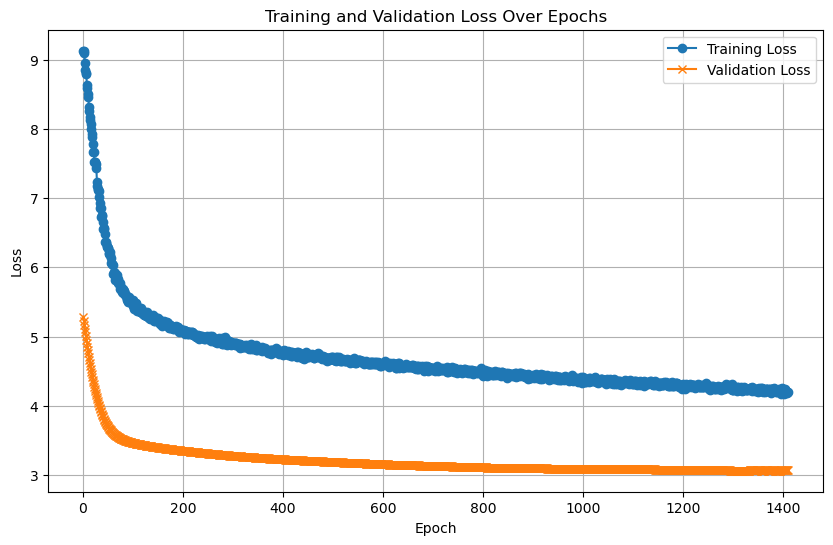

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/38], Loss: 4.9596
Test Batch [20/38], Loss: 4.9369
Test Batch [30/38], Loss: 4.8897

Test Loss: 5.0133


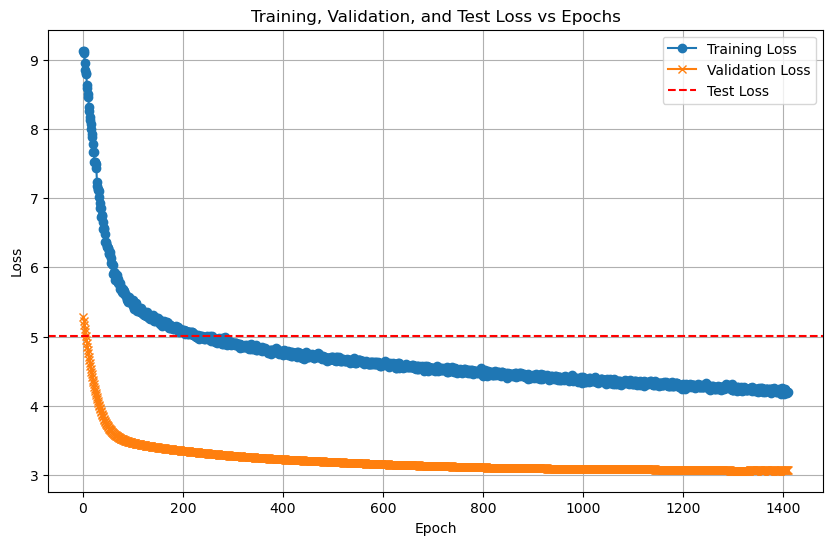

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/38 for test dataset.


  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 64.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.33      0.20      0.25         5
           2       0.50      0.20      0.29         5
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5
           5       0.80      0.80      0.80         5
           7       0.80      0.80      0.80         5
           9       0.50      0.60      0.55         5
          10       0.40      0.40      0.40         5
          11       0.25      0.40      0.31         5
          12       0.62      1.00      0.77         5
          13       0.80      0.80      0.80         5
          14       0.60      0.60      0.60         5
          15       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8519  |  Val Loss: 2.8259
Validation loss improved from inf to 2.8259.


[Epoch 2/1000] Train Loss: 2.8258  |  Val Loss: 2.8042
Validation loss improved from 2.8259 to 2.8042.
[Epoch 3/1000] Train Loss: 2.8050  |  Val Loss: 2.7841
Validation loss improved from 2.8042 to 2.7841.
[Epoch 4/1000] Train Loss: 2.7852  |  Val Loss: 2.7659
Validation loss improved from 2.7841 to 2.7659.
[Epoch 5/1000] Train Loss: 2.7678  |  Val Loss: 2.7502
Validation loss improved from 2.7659 to 2.7502.


[Epoch 6/1000] Train Loss: 2.7520  |  Val Loss: 2.7362
Validation loss improved from 2.7502 to 2.7362.
[Epoch 7/1000] Train Loss: 2.7373  |  Val Loss: 2.7230
Validation loss improved from 2.7362 to 2.7230.
[Epoch 8/1000] Train Loss: 2.7232  |  Val Loss: 2.7093
Validation loss improved from 2.7230 to 2.7093.
[Epoch 9/1000] Train Loss: 2.7098  |  Val Loss: 2.6969
Validation loss improved from 2.7093 to 2.6969.
[Epoch 10/1000] Train Loss: 2.6972  |  Val Loss: 2.6855
Validation loss improved from 2.6969 to 2.6855.
[Epoch 11/1000] Train Loss: 2.6857  |  Val Loss: 2.6743
Validation loss improved from 2.6855 to 2.6743.
[Epoch 12/1000] Train Loss: 2.6745  |  Val Loss: 2.6634
Validation loss improved from 2.6743 to 2.6634.
[Epoch 13/1000] Train Loss: 2.6634  |  Val Loss: 2.6524
Validation loss improved from 2.6634 to 2.6524.
[Epoch 14/1000] Train Loss: 2.6517  |  Val Loss: 2.6415
Validation loss improved from 2.6524 to 2.6415.
[Epoch 15/1000] Train Loss: 2.6408  |  Val Loss: 2.6300
Validation l

[Epoch 17/1000] Train Loss: 2.6182  |  Val Loss: 2.6068
Validation loss improved from 2.6186 to 2.6068.
[Epoch 18/1000] Train Loss: 2.6054  |  Val Loss: 2.5948
Validation loss improved from 2.6068 to 2.5948.
[Epoch 19/1000] Train Loss: 2.5921  |  Val Loss: 2.5823
Validation loss improved from 2.5948 to 2.5823.
[Epoch 20/1000] Train Loss: 2.5778  |  Val Loss: 2.5686
Validation loss improved from 2.5823 to 2.5686.
[Epoch 21/1000] Train Loss: 2.5629  |  Val Loss: 2.5545
Validation loss improved from 2.5686 to 2.5545.


[Epoch 22/1000] Train Loss: 2.5477  |  Val Loss: 2.5389
Validation loss improved from 2.5545 to 2.5389.
[Epoch 23/1000] Train Loss: 2.5315  |  Val Loss: 2.5221
Validation loss improved from 2.5389 to 2.5221.
[Epoch 24/1000] Train Loss: 2.5160  |  Val Loss: 2.5043
Validation loss improved from 2.5221 to 2.5043.
[Epoch 25/1000] Train Loss: 2.4984  |  Val Loss: 2.4878
Validation loss improved from 2.5043 to 2.4878.


[Epoch 26/1000] Train Loss: 2.4811  |  Val Loss: 2.4706
Validation loss improved from 2.4878 to 2.4706.
[Epoch 27/1000] Train Loss: 2.4638  |  Val Loss: 2.4525
Validation loss improved from 2.4706 to 2.4525.
[Epoch 28/1000] Train Loss: 2.4462  |  Val Loss: 2.4344
Validation loss improved from 2.4525 to 2.4344.
[Epoch 29/1000] Train Loss: 2.4280  |  Val Loss: 2.4163
Validation loss improved from 2.4344 to 2.4163.
[Epoch 30/1000] Train Loss: 2.4092  |  Val Loss: 2.3985
Validation loss improved from 2.4163 to 2.3985.
[Epoch 31/1000] Train Loss: 2.3908  |  Val Loss: 2.3800
Validation loss improved from 2.3985 to 2.3800.
[Epoch 32/1000] Train Loss: 2.3724  |  Val Loss: 2.3618
Validation loss improved from 2.3800 to 2.3618.
[Epoch 33/1000] Train Loss: 2.3547  |  Val Loss: 2.3439
Validation loss improved from 2.3618 to 2.3439.
[Epoch 34/1000] Train Loss: 2.3364  |  Val Loss: 2.3266
Validation loss improved from 2.3439 to 2.3266.
[Epoch 35/1000] Train Loss: 2.3177  |  Val Loss: 2.3090
Validati

[Epoch 37/1000] Train Loss: 2.2810  |  Val Loss: 2.2731
Validation loss improved from 2.2912 to 2.2731.
[Epoch 38/1000] Train Loss: 2.2628  |  Val Loss: 2.2560
Validation loss improved from 2.2731 to 2.2560.
[Epoch 39/1000] Train Loss: 2.2447  |  Val Loss: 2.2397
Validation loss improved from 2.2560 to 2.2397.
[Epoch 40/1000] Train Loss: 2.2270  |  Val Loss: 2.2236
Validation loss improved from 2.2397 to 2.2236.


[Epoch 41/1000] Train Loss: 2.2097  |  Val Loss: 2.2074
Validation loss improved from 2.2236 to 2.2074.
[Epoch 42/1000] Train Loss: 2.1929  |  Val Loss: 2.1911
Validation loss improved from 2.2074 to 2.1911.
[Epoch 43/1000] Train Loss: 2.1759  |  Val Loss: 2.1753
Validation loss improved from 2.1911 to 2.1753.
[Epoch 44/1000] Train Loss: 2.1599  |  Val Loss: 2.1602
Validation loss improved from 2.1753 to 2.1602.
[Epoch 45/1000] Train Loss: 2.1438  |  Val Loss: 2.1450
Validation loss improved from 2.1602 to 2.1450.


[Epoch 46/1000] Train Loss: 2.1277  |  Val Loss: 2.1301
Validation loss improved from 2.1450 to 2.1301.
[Epoch 47/1000] Train Loss: 2.1119  |  Val Loss: 2.1151
Validation loss improved from 2.1301 to 2.1151.
[Epoch 48/1000] Train Loss: 2.0962  |  Val Loss: 2.1004
Validation loss improved from 2.1151 to 2.1004.
[Epoch 49/1000] Train Loss: 2.0805  |  Val Loss: 2.0862
Validation loss improved from 2.1004 to 2.0862.
[Epoch 50/1000] Train Loss: 2.0649  |  Val Loss: 2.0719
Validation loss improved from 2.0862 to 2.0719.
[Epoch 51/1000] Train Loss: 2.0492  |  Val Loss: 2.0578
Validation loss improved from 2.0719 to 2.0578.
[Epoch 52/1000] Train Loss: 2.0342  |  Val Loss: 2.0433
Validation loss improved from 2.0578 to 2.0433.
[Epoch 53/1000] Train Loss: 2.0184  |  Val Loss: 2.0280
Validation loss improved from 2.0433 to 2.0280.
[Epoch 54/1000] Train Loss: 2.0028  |  Val Loss: 2.0139
Validation loss improved from 2.0280 to 2.0139.
[Epoch 55/1000] Train Loss: 1.9878  |  Val Loss: 1.9996
Validati

[Epoch 56/1000] Train Loss: 1.9730  |  Val Loss: 1.9860
Validation loss improved from 1.9996 to 1.9860.
[Epoch 57/1000] Train Loss: 1.9584  |  Val Loss: 1.9716
Validation loss improved from 1.9860 to 1.9716.
[Epoch 58/1000] Train Loss: 1.9435  |  Val Loss: 1.9576
Validation loss improved from 1.9716 to 1.9576.
[Epoch 59/1000] Train Loss: 1.9291  |  Val Loss: 1.9435
Validation loss improved from 1.9576 to 1.9435.


[Epoch 60/1000] Train Loss: 1.9149  |  Val Loss: 1.9299
Validation loss improved from 1.9435 to 1.9299.
[Epoch 61/1000] Train Loss: 1.9007  |  Val Loss: 1.9164
Validation loss improved from 1.9299 to 1.9164.
[Epoch 62/1000] Train Loss: 1.8865  |  Val Loss: 1.9022
Validation loss improved from 1.9164 to 1.9022.
[Epoch 63/1000] Train Loss: 1.8727  |  Val Loss: 1.8883
Validation loss improved from 1.9022 to 1.8883.


[Epoch 64/1000] Train Loss: 1.8589  |  Val Loss: 1.8753
Validation loss improved from 1.8883 to 1.8753.
[Epoch 65/1000] Train Loss: 1.8456  |  Val Loss: 1.8621
Validation loss improved from 1.8753 to 1.8621.
[Epoch 66/1000] Train Loss: 1.8315  |  Val Loss: 1.8488
Validation loss improved from 1.8621 to 1.8488.
[Epoch 67/1000] Train Loss: 1.8180  |  Val Loss: 1.8369
Validation loss improved from 1.8488 to 1.8369.
[Epoch 68/1000] Train Loss: 1.8051  |  Val Loss: 1.8240
Validation loss improved from 1.8369 to 1.8240.
[Epoch 69/1000] Train Loss: 1.7911  |  Val Loss: 1.8116
Validation loss improved from 1.8240 to 1.8116.
[Epoch 70/1000] Train Loss: 1.7779  |  Val Loss: 1.7994
Validation loss improved from 1.8116 to 1.7994.
[Epoch 71/1000] Train Loss: 1.7644  |  Val Loss: 1.7868
Validation loss improved from 1.7994 to 1.7868.
[Epoch 72/1000] Train Loss: 1.7512  |  Val Loss: 1.7746
Validation loss improved from 1.7868 to 1.7746.
[Epoch 73/1000] Train Loss: 1.7381  |  Val Loss: 1.7623
Validati

[Epoch 74/1000] Train Loss: 1.7250  |  Val Loss: 1.7498
Validation loss improved from 1.7623 to 1.7498.
[Epoch 75/1000] Train Loss: 1.7116  |  Val Loss: 1.7380
Validation loss improved from 1.7498 to 1.7380.
[Epoch 76/1000] Train Loss: 1.6983  |  Val Loss: 1.7260
Validation loss improved from 1.7380 to 1.7260.
[Epoch 77/1000] Train Loss: 1.6855  |  Val Loss: 1.7143
Validation loss improved from 1.7260 to 1.7143.
[Epoch 78/1000] Train Loss: 1.6724  |  Val Loss: 1.7029
Validation loss improved from 1.7143 to 1.7029.
[Epoch 79/1000] Train Loss: 1.6597  |  Val Loss: 1.6910
Validation loss improved from 1.7029 to 1.6910.


[Epoch 80/1000] Train Loss: 1.6467  |  Val Loss: 1.6796
Validation loss improved from 1.6910 to 1.6796.
[Epoch 81/1000] Train Loss: 1.6341  |  Val Loss: 1.6677
Validation loss improved from 1.6796 to 1.6677.
[Epoch 82/1000] Train Loss: 1.6214  |  Val Loss: 1.6559
Validation loss improved from 1.6677 to 1.6559.


[Epoch 83/1000] Train Loss: 1.6088  |  Val Loss: 1.6453
Validation loss improved from 1.6559 to 1.6453.
[Epoch 84/1000] Train Loss: 1.5965  |  Val Loss: 1.6338
Validation loss improved from 1.6453 to 1.6338.
[Epoch 85/1000] Train Loss: 1.5844  |  Val Loss: 1.6229
Validation loss improved from 1.6338 to 1.6229.
[Epoch 86/1000] Train Loss: 1.5721  |  Val Loss: 1.6123
Validation loss improved from 1.6229 to 1.6123.
[Epoch 87/1000] Train Loss: 1.5601  |  Val Loss: 1.6031
Validation loss improved from 1.6123 to 1.6031.
[Epoch 88/1000] Train Loss: 1.5480  |  Val Loss: 1.5929
Validation loss improved from 1.6031 to 1.5929.
[Epoch 89/1000] Train Loss: 1.5361  |  Val Loss: 1.5830
Validation loss improved from 1.5929 to 1.5830.
[Epoch 90/1000] Train Loss: 1.5245  |  Val Loss: 1.5733
Validation loss improved from 1.5830 to 1.5733.
[Epoch 91/1000] Train Loss: 1.5134  |  Val Loss: 1.5630
Validation loss improved from 1.5733 to 1.5630.
[Epoch 92/1000] Train Loss: 1.5017  |  Val Loss: 1.5545
Validati

[Epoch 94/1000] Train Loss: 1.4786  |  Val Loss: 1.5363
Validation loss improved from 1.5450 to 1.5363.
[Epoch 95/1000] Train Loss: 1.4680  |  Val Loss: 1.5276
Validation loss improved from 1.5363 to 1.5276.
[Epoch 96/1000] Train Loss: 1.4568  |  Val Loss: 1.5191
Validation loss improved from 1.5276 to 1.5191.
[Epoch 97/1000] Train Loss: 1.4462  |  Val Loss: 1.5105
Validation loss improved from 1.5191 to 1.5105.
[Epoch 98/1000] Train Loss: 1.4355  |  Val Loss: 1.5019
Validation loss improved from 1.5105 to 1.5019.


[Epoch 99/1000] Train Loss: 1.4250  |  Val Loss: 1.4938
Validation loss improved from 1.5019 to 1.4938.
[Epoch 100/1000] Train Loss: 1.4148  |  Val Loss: 1.4853
Validation loss improved from 1.4938 to 1.4853.
[Epoch 101/1000] Train Loss: 1.4039  |  Val Loss: 1.4785
Validation loss improved from 1.4853 to 1.4785.
[Epoch 102/1000] Train Loss: 1.3938  |  Val Loss: 1.4715
Validation loss improved from 1.4785 to 1.4715.


[Epoch 103/1000] Train Loss: 1.3834  |  Val Loss: 1.4644
Validation loss improved from 1.4715 to 1.4644.
[Epoch 104/1000] Train Loss: 1.3740  |  Val Loss: 1.4566
Validation loss improved from 1.4644 to 1.4566.
[Epoch 105/1000] Train Loss: 1.3635  |  Val Loss: 1.4508
Validation loss improved from 1.4566 to 1.4508.
[Epoch 106/1000] Train Loss: 1.3539  |  Val Loss: 1.4444
Validation loss improved from 1.4508 to 1.4444.
[Epoch 107/1000] Train Loss: 1.3440  |  Val Loss: 1.4379
Validation loss improved from 1.4444 to 1.4379.
[Epoch 108/1000] Train Loss: 1.3344  |  Val Loss: 1.4305
Validation loss improved from 1.4379 to 1.4305.
[Epoch 109/1000] Train Loss: 1.3247  |  Val Loss: 1.4244
Validation loss improved from 1.4305 to 1.4244.
[Epoch 110/1000] Train Loss: 1.3153  |  Val Loss: 1.4186
Validation loss improved from 1.4244 to 1.4186.
[Epoch 111/1000] Train Loss: 1.3059  |  Val Loss: 1.4126
Validation loss improved from 1.4186 to 1.4126.
[Epoch 112/1000] Train Loss: 1.2971  |  Val Loss: 1.407

[Epoch 113/1000] Train Loss: 1.2879  |  Val Loss: 1.4033
Validation loss improved from 1.4076 to 1.4033.
[Epoch 114/1000] Train Loss: 1.2789  |  Val Loss: 1.3976
Validation loss improved from 1.4033 to 1.3976.
[Epoch 115/1000] Train Loss: 1.2699  |  Val Loss: 1.3916
Validation loss improved from 1.3976 to 1.3916.
[Epoch 116/1000] Train Loss: 1.2608  |  Val Loss: 1.3872
Validation loss improved from 1.3916 to 1.3872.


[Epoch 117/1000] Train Loss: 1.2522  |  Val Loss: 1.3817
Validation loss improved from 1.3872 to 1.3817.
[Epoch 118/1000] Train Loss: 1.2435  |  Val Loss: 1.3774
Validation loss improved from 1.3817 to 1.3774.
[Epoch 119/1000] Train Loss: 1.2353  |  Val Loss: 1.3738
Validation loss improved from 1.3774 to 1.3738.
[Epoch 120/1000] Train Loss: 1.2263  |  Val Loss: 1.3695
Validation loss improved from 1.3738 to 1.3695.
[Epoch 121/1000] Train Loss: 1.2184  |  Val Loss: 1.3658
Validation loss improved from 1.3695 to 1.3658.
[Epoch 122/1000] Train Loss: 1.2101  |  Val Loss: 1.3609
Validation loss improved from 1.3658 to 1.3609.


[Epoch 123/1000] Train Loss: 1.2012  |  Val Loss: 1.3572
Validation loss improved from 1.3609 to 1.3572.
[Epoch 124/1000] Train Loss: 1.1936  |  Val Loss: 1.3539
Validation loss improved from 1.3572 to 1.3539.
[Epoch 125/1000] Train Loss: 1.1853  |  Val Loss: 1.3501
Validation loss improved from 1.3539 to 1.3501.
[Epoch 126/1000] Train Loss: 1.1775  |  Val Loss: 1.3471
Validation loss improved from 1.3501 to 1.3471.
[Epoch 127/1000] Train Loss: 1.1695  |  Val Loss: 1.3440
Validation loss improved from 1.3471 to 1.3440.
[Epoch 128/1000] Train Loss: 1.1617  |  Val Loss: 1.3414
Validation loss improved from 1.3440 to 1.3414.
[Epoch 129/1000] Train Loss: 1.1542  |  Val Loss: 1.3377
Validation loss improved from 1.3414 to 1.3377.
[Epoch 130/1000] Train Loss: 1.1461  |  Val Loss: 1.3344
Validation loss improved from 1.3377 to 1.3344.
[Epoch 131/1000] Train Loss: 1.1385  |  Val Loss: 1.3321
Validation loss improved from 1.3344 to 1.3321.


[Epoch 132/1000] Train Loss: 1.1314  |  Val Loss: 1.3303
Validation loss improved from 1.3321 to 1.3303.
[Epoch 133/1000] Train Loss: 1.1242  |  Val Loss: 1.3268
Validation loss improved from 1.3303 to 1.3268.
[Epoch 134/1000] Train Loss: 1.1170  |  Val Loss: 1.3235
Validation loss improved from 1.3268 to 1.3235.
[Epoch 135/1000] Train Loss: 1.1097  |  Val Loss: 1.3201
Validation loss improved from 1.3235 to 1.3201.
[Epoch 136/1000] Train Loss: 1.1024  |  Val Loss: 1.3182
Validation loss improved from 1.3201 to 1.3182.


[Epoch 137/1000] Train Loss: 1.0953  |  Val Loss: 1.3160
Validation loss improved from 1.3182 to 1.3160.
[Epoch 138/1000] Train Loss: 1.0879  |  Val Loss: 1.3144
Validation loss improved from 1.3160 to 1.3144.
[Epoch 139/1000] Train Loss: 1.0814  |  Val Loss: 1.3122
Validation loss improved from 1.3144 to 1.3122.
[Epoch 140/1000] Train Loss: 1.0753  |  Val Loss: 1.3102
Validation loss improved from 1.3122 to 1.3102.


[Epoch 141/1000] Train Loss: 1.0684  |  Val Loss: 1.3079
Validation loss improved from 1.3102 to 1.3079.
[Epoch 142/1000] Train Loss: 1.0617  |  Val Loss: 1.3054
Validation loss improved from 1.3079 to 1.3054.
[Epoch 143/1000] Train Loss: 1.0549  |  Val Loss: 1.3042
Validation loss improved from 1.3054 to 1.3042.
[Epoch 144/1000] Train Loss: 1.0484  |  Val Loss: 1.3027
Validation loss improved from 1.3042 to 1.3027.
[Epoch 145/1000] Train Loss: 1.0418  |  Val Loss: 1.3018
Validation loss improved from 1.3027 to 1.3018.
[Epoch 146/1000] Train Loss: 1.0354  |  Val Loss: 1.2990
Validation loss improved from 1.3018 to 1.2990.
[Epoch 147/1000] Train Loss: 1.0291  |  Val Loss: 1.2972
Validation loss improved from 1.2990 to 1.2972.


[Epoch 148/1000] Train Loss: 1.0235  |  Val Loss: 1.2945
Validation loss improved from 1.2972 to 1.2945.
[Epoch 149/1000] Train Loss: 1.0168  |  Val Loss: 1.2932
Validation loss improved from 1.2945 to 1.2932.
[Epoch 150/1000] Train Loss: 1.0113  |  Val Loss: 1.2943
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 151/1000] Train Loss: 1.0052  |  Val Loss: 1.2928
Validation loss improved from 1.2932 to 1.2928.
[Epoch 152/1000] Train Loss: 0.9997  |  Val Loss: 1.2919
Validation loss improved from 1.2928 to 1.2919.
[Epoch 153/1000] Train Loss: 0.9937  |  Val Loss: 1.2905
Validation loss improved from 1.2919 to 1.2905.
[Epoch 154/1000] Train Loss: 0.9878  |  Val Loss: 1.2901
Validation loss improved from 1.2905 to 1.2901.


[Epoch 155/1000] Train Loss: 0.9819  |  Val Loss: 1.2890
Validation loss improved from 1.2901 to 1.2890.
[Epoch 156/1000] Train Loss: 0.9763  |  Val Loss: 1.2866
Validation loss improved from 1.2890 to 1.2866.
[Epoch 157/1000] Train Loss: 0.9707  |  Val Loss: 1.2860
Validation loss improved from 1.2866 to 1.2860.
[Epoch 158/1000] Train Loss: 0.9656  |  Val Loss: 1.2862
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 159/1000] Train Loss: 0.9602  |  Val Loss: 1.2845
Validation loss improved from 1.2860 to 1.2845.
[Epoch 160/1000] Train Loss: 0.9547  |  Val Loss: 1.2850
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 161/1000] Train Loss: 0.9497  |  Val Loss: 1.2843
Validation loss improved from 1.2845 to 1.2843.
[Epoch 162/1000] Train Loss: 0.9449  |  Val Loss: 1.2835
Validation loss improved from 1.2843 to 1.2835.
[Epoch 163/1000] Train Loss: 0.9398  |  Val Loss: 1.2835
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 164/1000] Train Loss: 0.9345  |  Val Loss: 1.2825
Validation loss improved from 1.2835 to 1.2825.
[Epoch 165/1000] Train Loss: 0.9293  |  Val Loss: 1.2813
Validation loss improved from 1.2825 to 1.2813.
[Epoch 166/1000] Train Loss: 0.9251  |  Val Loss: 1.2783
Validation loss improved from 1.2813 to 1.2783.


[Epoch 167/1000] Train Loss: 0.9197  |  Val Loss: 1.2785
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 168/1000] Train Loss: 0.9147  |  Val Loss: 1.2787
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 169/1000] Train Loss: 0.9102  |  Val Loss: 1.2794
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 170/1000] Train Loss: 0.9056  |  Val Loss: 1.2801
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 171/1000] Train Loss: 0.9010  |  Val Loss: 1.2794
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 172/1000] Train Loss: 0.8961  |  Val Loss: 1.2789
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 173/1000] Train Loss: 0.8914  |  Val Loss: 1.2784
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 174/1000] Train Loss: 0.8869  |  Val Loss: 1.2778
Validation loss improved from 1.2783 to 1.2778.
[Epoch 175/1000] Train Loss: 0.8824  |  Val Loss: 1.2761
Validation loss improved from 1.2778 to 1.2761.
[Epoch 176/1000] Train Loss: 0.8782  |  Val Loss: 1.2773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 0.8736  |  Val Loss: 1.2766
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 0.8692  |  Val Loss: 1.2759
Validation loss improved from 1.2761 to 1.2759.
[Epoch 179/1000] Train Loss: 0.8660  |  Val Loss: 1.2772
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 180/1000] Train Loss: 0.8610  |  Val Loss: 1.2769
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 181/1000] Train Loss: 0.8570  |  Val Loss: 1.2771
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 182/1000] Train Loss: 0.8526  |  Val Loss: 1.2767
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 183/1000] Train Loss: 0.8482  |  Val Loss: 1.2757
Validation loss improved from 1.2759 to 1.2757.
[Epoch 184/1000] Train Loss: 0.8444  |  Val Loss: 1.2759
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 185/1000] Train Loss: 0.8405  |  Val Loss: 1.2747
Validation loss improved from 1.2757 to 1.2747.
[Epoch 186/1000] Train Loss: 0.8367  |  Val Loss: 1.2760
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 187/1000] Train Loss: 0.8326  |  Val Loss: 1.2762
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 188/1000] Train Loss: 0.8287  |  Val Loss: 1.2770
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 189/1000] Train Loss: 0.8246  |  Val Loss: 1.2774
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 190/1000] Train Loss: 0.8211  |  Val Loss: 1.2775
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 191/1000] Train Loss: 0.8168  |  Val Loss: 1.2780
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 192/1000] Train Loss: 0.8133  |  Val Loss: 1.2777
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 193/1000] Train Loss: 0.8096  |  Val Loss: 1.2772
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 194/1000] Train Loss: 0.8060  |  Val Loss: 1.2779
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 195/1000] Train Loss: 0.8035  |  Val Loss: 1.2784
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 196/1000] Train Loss: 0.7987  |  Val Loss: 1.2780
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 197/1000] Train Loss: 0.7949  |  Val Loss: 1.2768
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 198/1000] Train Loss: 0.7924  |  Val Loss: 1.2792
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 199/1000] Train Loss: 0.7882  |  Val Loss: 1.2799
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 200/1000] Train Loss: 0.7851  |  Val Loss: 1.2806
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 201/1000] Train Loss: 0.7824  |  Val Loss: 1.2797
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 202/1000] Train Loss: 0.7782  |  Val Loss: 1.2803
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 203/1000] Train Loss: 0.7743  |  Val Loss: 1.2798
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 204/1000] Train Loss: 0.7709  |  Val Loss: 1.2810
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 205/1000] Train Loss: 0.7672  |  Val Loss: 1.2805
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 206/1000] Train Loss: 0.7643  |  Val Loss: 1.2816
!! Validation loss did NOT improve !! Patience:

[Epoch 208/1000] Train Loss: 0.7575  |  Val Loss: 1.2830
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 209/1000] Train Loss: 0.7546  |  Val Loss: 1.2849
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 210/1000] Train Loss: 0.7518  |  Val Loss: 1.2841
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 211/1000] Train Loss: 0.7490  |  Val Loss: 1.2837
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 212/1000] Train Loss: 0.7453  |  Val Loss: 1.2842
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 213/1000] Train Loss: 0.7415  |  Val Loss: 1.2853
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 214/1000] Train Loss: 0.7388  |  Val Loss: 1.2875
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 215/1000] Train Loss: 0.7371  |  Val Loss: 1.2877
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 216/1000] Train Loss: 0.7331  |  Val Loss: 1.2867
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 217/1000] Train Loss: 0.7298  |  Val Loss: 1.2872
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 218/1000] Train Loss: 0.7275  |  Val Loss: 1.2869
!! Validation loss did NOT improve !! Patience: 33/100


[Epoch 219/1000] Train Loss: 0.7241  |  Val Loss: 1.2910
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 220/1000] Train Loss: 0.7218  |  Val Loss: 1.2921
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 221/1000] Train Loss: 0.7181  |  Val Loss: 1.2915
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 222/1000] Train Loss: 0.7161  |  Val Loss: 1.2916
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 223/1000] Train Loss: 0.7127  |  Val Loss: 1.2919
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 224/1000] Train Loss: 0.7099  |  Val Loss: 1.2921
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 225/1000] Train Loss: 0.7080  |  Val Loss: 1.2938
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 226/1000] Train Loss: 0.7040  |  Val Loss: 1.2946
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 227/1000] Train Loss: 0.7020  |  Val Loss: 1.2964
!! Validation loss did NOT improve !! Patience:

[Epoch 229/1000] Train Loss: 0.6972  |  Val Loss: 1.2962
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 230/1000] Train Loss: 0.6940  |  Val Loss: 1.2961
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 231/1000] Train Loss: 0.6914  |  Val Loss: 1.2973
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 232/1000] Train Loss: 0.6888  |  Val Loss: 1.2966
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 233/1000] Train Loss: 0.6861  |  Val Loss: 1.2983
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 234/1000] Train Loss: 0.6836  |  Val Loss: 1.3000
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 235/1000] Train Loss: 0.6814  |  Val Loss: 1.2994
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 236/1000] Train Loss: 0.6787  |  Val Loss: 1.3004
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 237/1000] Train Loss: 0.6761  |  Val Loss: 1.3027
!! Validation loss did NOT improve !! Patience: 52/100


[Epoch 238/1000] Train Loss: 0.6739  |  Val Loss: 1.3034
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 239/1000] Train Loss: 0.6720  |  Val Loss: 1.3042
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 240/1000] Train Loss: 0.6693  |  Val Loss: 1.3029
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 241/1000] Train Loss: 0.6673  |  Val Loss: 1.3023
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 242/1000] Train Loss: 0.6652  |  Val Loss: 1.3042
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 243/1000] Train Loss: 0.6620  |  Val Loss: 1.3060
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 244/1000] Train Loss: 0.6597  |  Val Loss: 1.3080
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 245/1000] Train Loss: 0.6576  |  Val Loss: 1.3101
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 246/1000] Train Loss: 0.6565  |  Val Loss: 1.3090
!! Validation loss did NOT improve !! Patience:

[Epoch 251/1000] Train Loss: 0.6452  |  Val Loss: 1.3134
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 252/1000] Train Loss: 0.6428  |  Val Loss: 1.3117
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 253/1000] Train Loss: 0.6409  |  Val Loss: 1.3124
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 254/1000] Train Loss: 0.6382  |  Val Loss: 1.3142
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 255/1000] Train Loss: 0.6363  |  Val Loss: 1.3165
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 256/1000] Train Loss: 0.6345  |  Val Loss: 1.3173
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 257/1000] Train Loss: 0.6333  |  Val Loss: 1.3171
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 258/1000] Train Loss: 0.6306  |  Val Loss: 1.3157
!! Validation loss did NOT improve !! Patience: 73/100


[Epoch 259/1000] Train Loss: 0.6287  |  Val Loss: 1.3167
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 260/1000] Train Loss: 0.6272  |  Val Loss: 1.3193
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 261/1000] Train Loss: 0.6250  |  Val Loss: 1.3223
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 262/1000] Train Loss: 0.6223  |  Val Loss: 1.3230
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 263/1000] Train Loss: 0.6207  |  Val Loss: 1.3256
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 264/1000] Train Loss: 0.6201  |  Val Loss: 1.3244
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 265/1000] Train Loss: 0.6178  |  Val Loss: 1.3239
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 266/1000] Train Loss: 0.6155  |  Val Loss: 1.3265
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 267/1000] Train Loss: 0.6135  |  Val Loss: 1.3278
!! Validation loss did NOT improve !! Patience:

[Epoch 268/1000] Train Loss: 0.6113  |  Val Loss: 1.3281
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 269/1000] Train Loss: 0.6105  |  Val Loss: 1.3295
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 270/1000] Train Loss: 0.6088  |  Val Loss: 1.3305
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 271/1000] Train Loss: 0.6075  |  Val Loss: 1.3330
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 272/1000] Train Loss: 0.6054  |  Val Loss: 1.3326
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 273/1000] Train Loss: 0.6034  |  Val Loss: 1.3317
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 274/1000] Train Loss: 0.6023  |  Val Loss: 1.3322
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 275/1000] Train Loss: 0.6000  |  Val Loss: 1.3329
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 276/1000] Train Loss: 0.5983  |  Val Loss: 1.3347
!! Validation loss did NOT improve !! Patience:

[Epoch 277/1000] Train Loss: 0.5967  |  Val Loss: 1.3391
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 278/1000] Train Loss: 0.5953  |  Val Loss: 1.3385
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 279/1000] Train Loss: 0.5934  |  Val Loss: 1.3399
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 280/1000] Train Loss: 0.5920  |  Val Loss: 1.3387
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 281/1000] Train Loss: 0.5906  |  Val Loss: 1.3386
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 282/1000] Train Loss: 0.5888  |  Val Loss: 1.3394
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 283/1000] Train Loss: 0.5881  |  Val Loss: 1.3413
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 284/1000] Train Loss: 0.5853  |  Val Loss: 1.3446
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 285/1000] Train Loss: 0.5843  |  Val Loss: 1.3449
!! Validation loss did NOT improve !! Patience:

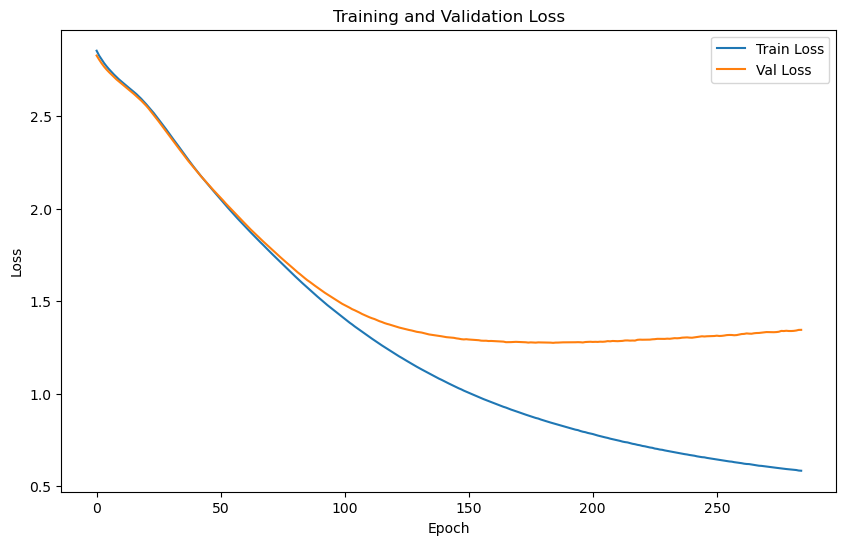

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.4316 | Test Accuracy: 53.43%


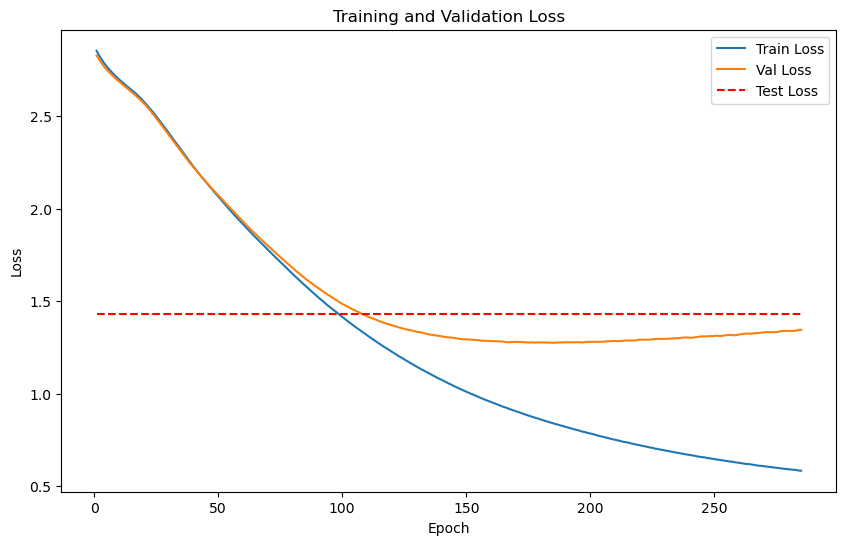

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5303
    Batch [2/2], Val Loss: 0.1760
Epoch [1/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.3532

Validation loss improved from inf to 0.3532. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5016
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5305
    Batch [2/2], Val Loss: 0.1766
Epoch [2/2000], Avg Train Loss: 0.5016, Avg Val Loss: 0.3535

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5305
    Batch [2/2], Val Loss: 0.1771
Epoch [3/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.3538

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4978
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.1776
Epoch [4/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.3540

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5303
    Batch [2/2], Val Loss: 0.1774
Epoch [5/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.3538

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.1765
Epoch [6/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.3530

Validation loss improved from 0.3532 to 0.3530. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.1756
Epoch [7/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.3522

Validation loss improved from 0.3530 to 0.3522. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.1750
Epoch [8/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.3514

Validation loss improved from 0.3522 to 0.3514. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5265
    Batch [2/2], Val Loss: 0.1751
Epoch [9/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.3508

Validation loss improved from 0.3514 to 0.3508. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.1754
Epoch [10/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.3502

Validation loss improved from 0.3508 to 0.3502. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5234
    Batch [2/2], Val Loss: 0.1756
Epoch [11/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.3495

Validation loss improved from 0.3502 to 0.3495. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5220
    Batch [2/2], Val Loss: 0.1754
Epoch [12/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.3487

Validation loss improved from 0.3495 to 0.3487. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.1751
Epoch [13/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.3479

Validation loss improved from 0.3487 to 0.3479. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.1745
Epoch [14/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.3470

Validation loss improved from 0.3479 to 0.3470. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5181
    Batch [2/2], Val Loss: 0.1739
Epoch [15/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.3460

Validation loss improved from 0.3470 to 0.3460. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.1733
Epoch [16/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.3450

Validation loss improved from 0.3460 to 0.3450. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.1727
Epoch [17/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.3442

Validation loss improved from 0.3450 to 0.3442. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.1721
Epoch [18/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.3433

Validation loss improved from 0.3442 to 0.3433. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.1714
Epoch [19/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.3425

Validation loss improved from 0.3433 to 0.3425. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.1709
Epoch [20/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.3416

Validation loss improved from 0.3425 to 0.3416. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.1702
Epoch [21/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.3407

Validation loss improved from 0.3416 to 0.3407. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.1696
Epoch [22/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.3397

Validation loss improved from 0.3407 to 0.3397. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.1690
Epoch [23/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.3389

Validation loss improved from 0.3397 to 0.3389. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.1685
Epoch [24/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.3380

Validation loss improved from 0.3389 to 0.3380. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5064
    Batch [2/2], Val Loss: 0.1679
Epoch [25/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.3371

Validation loss improved from 0.3380 to 0.3371. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.1672
Epoch [26/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.3362

Validation loss improved from 0.3371 to 0.3362. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.1666
Epoch [27/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.3354

Validation loss improved from 0.3362 to 0.3354. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.1660
Epoch [28/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.3345

Validation loss improved from 0.3354 to 0.3345. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5021
    Batch [2/2], Val Loss: 0.1654
Epoch [29/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.3337

Validation loss improved from 0.3345 to 0.3337. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.1648
Epoch [30/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.3330

Validation loss improved from 0.3337 to 0.3330. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.1643
Epoch [31/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.3324

Validation loss improved from 0.3330 to 0.3324. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.1639
Epoch [32/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.3318

Validation loss improved from 0.3324 to 0.3318. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.1634
Epoch [33/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.3313

Validation loss improved from 0.3318 to 0.3313. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.1629
Epoch [34/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.3307

Validation loss improved from 0.3313 to 0.3307. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.1624
Epoch [35/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.3302

Validation loss improved from 0.3307 to 0.3302. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.1620
Epoch [36/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.3297

Validation loss improved from 0.3302 to 0.3297. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.1615
Epoch [37/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.3293

Validation loss improved from 0.3297 to 0.3293. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.1611
Epoch [38/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.3288

Validation loss improved from 0.3293 to 0.3288. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.1606
Epoch [39/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.3284

Validation loss improved from 0.3288 to 0.3284. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.1602
Epoch [40/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.3280

Validation loss improved from 0.3284 to 0.3280. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.1597
Epoch [41/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.3276

Validation loss improved from 0.3280 to 0.3276. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.1592
Epoch [42/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.3272

Validation loss improved from 0.3276 to 0.3272. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.1588
Epoch [43/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.3269

Validation loss improved from 0.3272 to 0.3269. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.1584
Epoch [44/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.3265

Validation loss improved from 0.3269 to 0.3265. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.1579
Epoch [45/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.3262

Validation loss improved from 0.3265 to 0.3262. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.1575
Epoch [46/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.3258

Validation loss improved from 0.3262 to 0.3258. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.1570
Epoch [47/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.3255

Validation loss improved from 0.3258 to 0.3255. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.1565
Epoch [48/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.3251

Validation loss improved from 0.3255 to 0.3251. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.1559
Epoch [49/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.3247

Validation loss improved from 0.3251 to 0.3247. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.1553
Epoch [50/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.3243

Validation loss improved from 0.3247 to 0.3243. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.1547
Epoch [51/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.3239

Validation loss improved from 0.3243 to 0.3239. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.1541
Epoch [52/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.3235

Validation loss improved from 0.3239 to 0.3235. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.1534
Epoch [53/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.3231

Validation loss improved from 0.3235 to 0.3231. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.1528
Epoch [54/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.3227

Validation loss improved from 0.3231 to 0.3227. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.1522
Epoch [55/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.3223

Validation loss improved from 0.3227 to 0.3223. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.1515
Epoch [56/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.3219

Validation loss improved from 0.3223 to 0.3219. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.1509
Epoch [57/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.3214

Validation loss improved from 0.3219 to 0.3214. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.1503
Epoch [58/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.3210

Validation loss improved from 0.3214 to 0.3210. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.1496
Epoch [59/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.3206

Validation loss improved from 0.3210 to 0.3206. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.1489
Epoch [60/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.3202

Validation loss improved from 0.3206 to 0.3202. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.1483
Epoch [61/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.3198

Validation loss improved from 0.3202 to 0.3198. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.1477
Epoch [62/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.3194

Validation loss improved from 0.3198 to 0.3194. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.1471
Epoch [63/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.3190

Validation loss improved from 0.3194 to 0.3190. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.1465
Epoch [64/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.3187

Validation loss improved from 0.3190 to 0.3187. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.1459
Epoch [65/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.3183

Validation loss improved from 0.3187 to 0.3183. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.1454
Epoch [66/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.3180

Validation loss improved from 0.3183 to 0.3180. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.1447
Epoch [67/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.3176

Validation loss improved from 0.3180 to 0.3176. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.1441
Epoch [68/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.3172

Validation loss improved from 0.3176 to 0.3172. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.1434
Epoch [69/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3168

Validation loss improved from 0.3172 to 0.3168. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.1427
Epoch [70/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.3164

Validation loss improved from 0.3168 to 0.3164. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.1420
Epoch [71/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.3160

Validation loss improved from 0.3164 to 0.3160. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.1413
Epoch [72/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.3155

Validation loss improved from 0.3160 to 0.3155. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.1406
Epoch [73/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.3151

Validation loss improved from 0.3155 to 0.3151. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.1400
Epoch [74/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.3147

Validation loss improved from 0.3151 to 0.3147. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.1393
Epoch [75/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3143

Validation loss improved from 0.3147 to 0.3143. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.1387
Epoch [76/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.3139

Validation loss improved from 0.3143 to 0.3139. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.1382
Epoch [77/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.3136

Validation loss improved from 0.3139 to 0.3136. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.1377
Epoch [78/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.3132

Validation loss improved from 0.3136 to 0.3132. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.1371
Epoch [79/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.3128

Validation loss improved from 0.3132 to 0.3128. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.1366
Epoch [80/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.3125

Validation loss improved from 0.3128 to 0.3125. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.1361
Epoch [81/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.3122

Validation loss improved from 0.3125 to 0.3122. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.1357
Epoch [82/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.3119

Validation loss improved from 0.3122 to 0.3119. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.1351
Epoch [83/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.3115

Validation loss improved from 0.3119 to 0.3115. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.1346
Epoch [84/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.3112

Validation loss improved from 0.3115 to 0.3112. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.1341
Epoch [85/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.3109

Validation loss improved from 0.3112 to 0.3109. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.1336
Epoch [86/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.3105

Validation loss improved from 0.3109 to 0.3105. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.1331
Epoch [87/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.3102

Validation loss improved from 0.3105 to 0.3102. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.1326
Epoch [88/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.3099

Validation loss improved from 0.3102 to 0.3099. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4870
    Batch [2/2], Val Loss: 0.1321
Epoch [89/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.3095

Validation loss improved from 0.3099 to 0.3095. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.1316
Epoch [90/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3092

Validation loss improved from 0.3095 to 0.3092. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.1312
Epoch [91/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.3089

Validation loss improved from 0.3092 to 0.3089. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.1308
Epoch [92/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.3086

Validation loss improved from 0.3089 to 0.3086. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.1304
Epoch [93/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3084

Validation loss improved from 0.3086 to 0.3084. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.1300
Epoch [94/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.3081

Validation loss improved from 0.3084 to 0.3081. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.1295
Epoch [95/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.3078

Validation loss improved from 0.3081 to 0.3078. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.1292
Epoch [96/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.3075

Validation loss improved from 0.3078 to 0.3075. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.1288
Epoch [97/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3073

Validation loss improved from 0.3075 to 0.3073. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.1285
Epoch [98/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.3070

Validation loss improved from 0.3073 to 0.3070. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.1282
Epoch [99/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3068

Validation loss improved from 0.3070 to 0.3068. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.1278
Epoch [100/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.3066

Validation loss improved from 0.3068 to 0.3066. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.1275
Epoch [101/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3063

Validation loss improved from 0.3066 to 0.3063. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.1272
Epoch [102/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.3061

Validation loss improved from 0.3063 to 0.3061. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.1268
Epoch [103/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3058

Validation loss improved from 0.3061 to 0.3058. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.1265
Epoch [104/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.3055

Validation loss improved from 0.3058 to 0.3055. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.1261
Epoch [105/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.3052

Validation loss improved from 0.3055 to 0.3052. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.1256
Epoch [106/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.3049

Validation loss improved from 0.3052 to 0.3049. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.1252
Epoch [107/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.3046

Validation loss improved from 0.3049 to 0.3046. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.1248
Epoch [108/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.3043

Validation loss improved from 0.3046 to 0.3043. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.1244
Epoch [109/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.3039

Validation loss improved from 0.3043 to 0.3039. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.1240
Epoch [110/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.3037

Validation loss improved from 0.3039 to 0.3037. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.1236
Epoch [111/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3034

Validation loss improved from 0.3037 to 0.3034. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.1232
Epoch [112/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.3031

Validation loss improved from 0.3034 to 0.3031. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.1228
Epoch [113/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.3028

Validation loss improved from 0.3031 to 0.3028. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.1224
Epoch [114/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.3025

Validation loss improved from 0.3028 to 0.3025. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.1220
Epoch [115/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.3023

Validation loss improved from 0.3025 to 0.3023. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.1216
Epoch [116/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.3020

Validation loss improved from 0.3023 to 0.3020. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.1211
Epoch [117/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.3016

Validation loss improved from 0.3020 to 0.3016. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.1206
Epoch [118/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.3013

Validation loss improved from 0.3016 to 0.3013. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.1201
Epoch [119/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.3010

Validation loss improved from 0.3013 to 0.3010. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.1196
Epoch [120/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.3007

Validation loss improved from 0.3010 to 0.3007. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.1192
Epoch [121/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.3004

Validation loss improved from 0.3007 to 0.3004. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.1187
Epoch [122/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.3001

Validation loss improved from 0.3004 to 0.3001. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.1182
Epoch [123/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.2997

Validation loss improved from 0.3001 to 0.2997. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.1178
Epoch [124/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.2994

Validation loss improved from 0.2997 to 0.2994. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.1174
Epoch [125/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.2992

Validation loss improved from 0.2994 to 0.2992. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.1169
Epoch [126/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.2989

Validation loss improved from 0.2992 to 0.2989. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.1165
Epoch [127/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.2986

Validation loss improved from 0.2989 to 0.2986. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.1161
Epoch [128/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.2983

Validation loss improved from 0.2986 to 0.2983. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.1157
Epoch [129/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.2981

Validation loss improved from 0.2983 to 0.2981. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.1154
Epoch [130/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.2978

Validation loss improved from 0.2981 to 0.2978. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.1150
Epoch [131/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.2976

Validation loss improved from 0.2978 to 0.2976. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.1147
Epoch [132/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.2974

Validation loss improved from 0.2976 to 0.2974. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.1144
Epoch [133/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.2971

Validation loss improved from 0.2974 to 0.2971. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.1141
Epoch [134/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.2969

Validation loss improved from 0.2971 to 0.2969. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.1138
Epoch [135/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.2967

Validation loss improved from 0.2969 to 0.2967. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.1135
Epoch [136/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.2965

Validation loss improved from 0.2967 to 0.2965. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.1133
Epoch [137/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.2963

Validation loss improved from 0.2965 to 0.2963. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.1130
Epoch [138/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.2961

Validation loss improved from 0.2963 to 0.2961. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.1128
Epoch [139/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.2959

Validation loss improved from 0.2961 to 0.2959. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.1127
Epoch [140/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.2958

Validation loss improved from 0.2959 to 0.2958. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.1125
Epoch [141/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.2956

Validation loss improved from 0.2958 to 0.2956. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.1123
Epoch [142/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.2955

Validation loss improved from 0.2956 to 0.2955. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.1122
Epoch [143/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.2953

Validation loss improved from 0.2955 to 0.2953. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.1121
Epoch [144/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.2952

Validation loss improved from 0.2953 to 0.2952. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.1120
Epoch [145/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2951

Validation loss improved from 0.2952 to 0.2951. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.1119
Epoch [146/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.2949

Validation loss improved from 0.2951 to 0.2949. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.1116
Epoch [147/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.2947

Validation loss improved from 0.2949 to 0.2947. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.1113
Epoch [148/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.2945

Validation loss improved from 0.2947 to 0.2945. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.1110
Epoch [149/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.2942

Validation loss improved from 0.2945 to 0.2942. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.1106
Epoch [150/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.2939

Validation loss improved from 0.2942 to 0.2939. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.1102
Epoch [151/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.2937

Validation loss improved from 0.2939 to 0.2937. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.1098
Epoch [152/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.2934

Validation loss improved from 0.2937 to 0.2934. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.1094
Epoch [153/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2932

Validation loss improved from 0.2934 to 0.2932. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.1090
Epoch [154/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.2929

Validation loss improved from 0.2932 to 0.2929. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.1086
Epoch [155/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.2926

Validation loss improved from 0.2929 to 0.2926. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.1082
Epoch [156/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.2923

Validation loss improved from 0.2926 to 0.2923. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.1077
Epoch [157/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.2920

Validation loss improved from 0.2923 to 0.2920. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.1073
Epoch [158/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.2918

Validation loss improved from 0.2920 to 0.2918. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.1069
Epoch [159/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.2915

Validation loss improved from 0.2918 to 0.2915. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.1065
Epoch [160/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.2912

Validation loss improved from 0.2915 to 0.2912. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.1060
Epoch [161/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.2909

Validation loss improved from 0.2912 to 0.2909. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.1056
Epoch [162/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.2906

Validation loss improved from 0.2909 to 0.2906. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.1052
Epoch [163/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.2903

Validation loss improved from 0.2906 to 0.2903. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.1049
Epoch [164/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2900

Validation loss improved from 0.2903 to 0.2900. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.1046
Epoch [165/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.2898

Validation loss improved from 0.2900 to 0.2898. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.1043
Epoch [166/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.2896

Validation loss improved from 0.2898 to 0.2896. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.1039
Epoch [167/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.2893

Validation loss improved from 0.2896 to 0.2893. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.1036
Epoch [168/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2891

Validation loss improved from 0.2893 to 0.2891. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.1032
Epoch [169/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.2889

Validation loss improved from 0.2891 to 0.2889. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.1029
Epoch [170/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.2887

Validation loss improved from 0.2889 to 0.2887. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.1027
Epoch [171/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2885

Validation loss improved from 0.2887 to 0.2885. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.1024
Epoch [172/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.2883

Validation loss improved from 0.2885 to 0.2883. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.1021
Epoch [173/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.2881

Validation loss improved from 0.2883 to 0.2881. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.1017
Epoch [174/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.2879

Validation loss improved from 0.2881 to 0.2879. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.1015
Epoch [175/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.2878

Validation loss improved from 0.2879 to 0.2878. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.1012
Epoch [176/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.2876

Validation loss improved from 0.2878 to 0.2876. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.1010
Epoch [177/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.2874

Validation loss improved from 0.2876 to 0.2874. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.1008
Epoch [178/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.2873

Validation loss improved from 0.2874 to 0.2873. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.1006
Epoch [179/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.2871

Validation loss improved from 0.2873 to 0.2871. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.1003
Epoch [180/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.2869

Validation loss improved from 0.2871 to 0.2869. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.1001
Epoch [181/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.2867

Validation loss improved from 0.2869 to 0.2867. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.0998
Epoch [182/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.2866

Validation loss improved from 0.2867 to 0.2866. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.0995
Epoch [183/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.2864

Validation loss improved from 0.2866 to 0.2864. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.0993
Epoch [184/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.2862

Validation loss improved from 0.2864 to 0.2862. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.0991
Epoch [185/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.2861

Validation loss improved from 0.2862 to 0.2861. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.0989
Epoch [186/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.2859

Validation loss improved from 0.2861 to 0.2859. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.0986
Epoch [187/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2858

Validation loss improved from 0.2859 to 0.2858. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.0984
Epoch [188/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.2857

Validation loss improved from 0.2858 to 0.2857. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.0982
Epoch [189/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.2855

Validation loss improved from 0.2857 to 0.2855. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.0980
Epoch [190/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2854

Validation loss improved from 0.2855 to 0.2854. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.0978
Epoch [191/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2852

Validation loss improved from 0.2854 to 0.2852. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.0976
Epoch [192/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.2851

Validation loss improved from 0.2852 to 0.2851. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.0974
Epoch [193/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2849

Validation loss improved from 0.2851 to 0.2849. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.0971
Epoch [194/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2847

Validation loss improved from 0.2849 to 0.2847. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.0968
Epoch [195/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.2845

Validation loss improved from 0.2847 to 0.2845. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.0965
Epoch [196/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.2844

Validation loss improved from 0.2845 to 0.2844. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.0963
Epoch [197/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.2842

Validation loss improved from 0.2844 to 0.2842. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.0961
Epoch [198/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.2840

Validation loss improved from 0.2842 to 0.2840. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.0959
Epoch [199/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2839

Validation loss improved from 0.2840 to 0.2839. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.0957
Epoch [200/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2838

Validation loss improved from 0.2839 to 0.2838. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.0955
Epoch [201/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2836

Validation loss improved from 0.2838 to 0.2836. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.0953
Epoch [202/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2835

Validation loss improved from 0.2836 to 0.2835. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.0952
Epoch [203/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2834

Validation loss improved from 0.2835 to 0.2834. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.0950
Epoch [204/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.2832

Validation loss improved from 0.2834 to 0.2832. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.0947
Epoch [205/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2830

Validation loss improved from 0.2832 to 0.2830. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.0945
Epoch [206/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.2828

Validation loss improved from 0.2830 to 0.2828. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.0942
Epoch [207/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2826

Validation loss improved from 0.2828 to 0.2826. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.0939
Epoch [208/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.2823

Validation loss improved from 0.2826 to 0.2823. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.0937
Epoch [209/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.2820

Validation loss improved from 0.2823 to 0.2820. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.0934
Epoch [210/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2818

Validation loss improved from 0.2820 to 0.2818. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.0932
Epoch [211/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.2816

Validation loss improved from 0.2818 to 0.2816. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.0930
Epoch [212/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2814

Validation loss improved from 0.2816 to 0.2814. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.0927
Epoch [213/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2812

Validation loss improved from 0.2814 to 0.2812. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.0925
Epoch [214/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2811

Validation loss improved from 0.2812 to 0.2811. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.0923
Epoch [215/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.2809

Validation loss improved from 0.2811 to 0.2809. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.0920
Epoch [216/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2807

Validation loss improved from 0.2809 to 0.2807. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.0917
Epoch [217/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.2805

Validation loss improved from 0.2807 to 0.2805. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.0914
Epoch [218/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2803

Validation loss improved from 0.2805 to 0.2803. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.0912
Epoch [219/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2801

Validation loss improved from 0.2803 to 0.2801. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.0910
Epoch [220/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.2800

Validation loss improved from 0.2801 to 0.2800. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.0908
Epoch [221/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2799

Validation loss improved from 0.2800 to 0.2799. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.0906
Epoch [222/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.2797

Validation loss improved from 0.2799 to 0.2797. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.0903
Epoch [223/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2796

Validation loss improved from 0.2797 to 0.2796. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.0901
Epoch [224/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2794

Validation loss improved from 0.2796 to 0.2794. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.0898
Epoch [225/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2791

Validation loss improved from 0.2794 to 0.2791. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.0894
Epoch [226/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.2789

Validation loss improved from 0.2791 to 0.2789. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.0891
Epoch [227/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2786

Validation loss improved from 0.2789 to 0.2786. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.0887
Epoch [228/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2784

Validation loss improved from 0.2786 to 0.2784. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.0884
Epoch [229/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2781

Validation loss improved from 0.2784 to 0.2781. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.0881
Epoch [230/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.2779

Validation loss improved from 0.2781 to 0.2779. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.0878
Epoch [231/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2777

Validation loss improved from 0.2779 to 0.2777. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.0875
Epoch [232/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2774

Validation loss improved from 0.2777 to 0.2774. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.0872
Epoch [233/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2772

Validation loss improved from 0.2774 to 0.2772. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.0870
Epoch [234/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.2770

Validation loss improved from 0.2772 to 0.2770. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.0867
Epoch [235/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.2768

Validation loss improved from 0.2770 to 0.2768. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.0865
Epoch [236/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2766

Validation loss improved from 0.2768 to 0.2766. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.0862
Epoch [237/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2764

Validation loss improved from 0.2766 to 0.2764. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.0860
Epoch [238/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2762

Validation loss improved from 0.2764 to 0.2762. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.0858
Epoch [239/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.2761

Validation loss improved from 0.2762 to 0.2761. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.0856
Epoch [240/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2759

Validation loss improved from 0.2761 to 0.2759. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.0854
Epoch [241/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2758

Validation loss improved from 0.2759 to 0.2758. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.0853
Epoch [242/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2757

Validation loss improved from 0.2758 to 0.2757. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.0852
Epoch [243/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2756

Validation loss improved from 0.2757 to 0.2756. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.0851
Epoch [244/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2755

Validation loss improved from 0.2756 to 0.2755. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.0850
Epoch [245/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2755

Validation loss improved from 0.2755 to 0.2755. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0850
Epoch [246/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.2754

Validation loss improved from 0.2755 to 0.2754. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0849
Epoch [247/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2754

Validation loss improved from 0.2754 to 0.2754. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.0849
Epoch [248/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.2753

Validation loss improved from 0.2754 to 0.2753. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.0848
Epoch [249/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2752

Validation loss improved from 0.2753 to 0.2752. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.0847
Epoch [250/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2751

Validation loss improved from 0.2752 to 0.2751. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.0845
Epoch [251/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2750

Validation loss improved from 0.2751 to 0.2750. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.0844
Epoch [252/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2748

Validation loss improved from 0.2750 to 0.2748. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.0842
Epoch [253/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2747

Validation loss improved from 0.2748 to 0.2747. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.0841
Epoch [254/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2746

Validation loss improved from 0.2747 to 0.2746. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.0840
Epoch [255/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2745

Validation loss improved from 0.2746 to 0.2745. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4649
    Batch [2/2], Val Loss: 0.0838
Epoch [256/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2743

Validation loss improved from 0.2745 to 0.2743. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.0836
Epoch [257/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2742

Validation loss improved from 0.2743 to 0.2742. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.0834
Epoch [258/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2740

Validation loss improved from 0.2742 to 0.2740. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.0832
Epoch [259/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2739

Validation loss improved from 0.2740 to 0.2739. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.0830
Epoch [260/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2737

Validation loss improved from 0.2739 to 0.2737. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.0827
Epoch [261/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2736

Validation loss improved from 0.2737 to 0.2736. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.0824
Epoch [262/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.2734

Validation loss improved from 0.2736 to 0.2734. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.0821
Epoch [263/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2732

Validation loss improved from 0.2734 to 0.2732. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.0818
Epoch [264/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.2730

Validation loss improved from 0.2732 to 0.2730. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.0816
Epoch [265/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2728

Validation loss improved from 0.2730 to 0.2728. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.0814
Epoch [266/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2727

Validation loss improved from 0.2728 to 0.2727. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.0813
Epoch [267/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2726

Validation loss improved from 0.2727 to 0.2726. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.0811
Epoch [268/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2724

Validation loss improved from 0.2726 to 0.2724. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.0809
Epoch [269/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2723

Validation loss improved from 0.2724 to 0.2723. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.0808
Epoch [270/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2722

Validation loss improved from 0.2723 to 0.2722. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.0807
Epoch [271/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2720

Validation loss improved from 0.2722 to 0.2720. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.0806
Epoch [272/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.0804
Epoch [273/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2718

Validation loss improved from 0.2719 to 0.2718. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.0803
Epoch [274/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2717

Validation loss improved from 0.2718 to 0.2717. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.0803
Epoch [275/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2717

Validation loss improved from 0.2717 to 0.2717. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.0803
Epoch [276/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.0801
Epoch [277/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2715

Validation loss improved from 0.2716 to 0.2715. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.0800
Epoch [278/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.0798
Epoch [279/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.2712

Validation loss improved from 0.2714 to 0.2712. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.0796
Epoch [280/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.0794
Epoch [281/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2709

Validation loss improved from 0.2711 to 0.2709. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.0792
Epoch [282/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2707

Validation loss improved from 0.2709 to 0.2707. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.0790
Epoch [283/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.2705

Validation loss improved from 0.2707 to 0.2705. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.0788
Epoch [284/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2703

Validation loss improved from 0.2705 to 0.2703. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.0785
Epoch [285/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2700

Validation loss improved from 0.2703 to 0.2700. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.0783
Epoch [286/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2698

Validation loss improved from 0.2700 to 0.2698. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.0780
Epoch [287/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2695

Validation loss improved from 0.2698 to 0.2695. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.0777
Epoch [288/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2692

Validation loss improved from 0.2695 to 0.2692. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.0775
Epoch [289/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2690

Validation loss improved from 0.2692 to 0.2690. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.0773
Epoch [290/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2688

Validation loss improved from 0.2690 to 0.2688. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.0770
Epoch [291/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2686

Validation loss improved from 0.2688 to 0.2686. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.0767
Epoch [292/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2683

Validation loss improved from 0.2686 to 0.2683. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.0764
Epoch [293/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2681

Validation loss improved from 0.2683 to 0.2681. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.0760
Epoch [294/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2679

Validation loss improved from 0.2681 to 0.2679. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.0757
Epoch [295/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2676

Validation loss improved from 0.2679 to 0.2676. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.0754
Epoch [296/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.0751
Epoch [297/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2672

Validation loss improved from 0.2674 to 0.2672. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.0749
Epoch [298/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2671

Validation loss improved from 0.2672 to 0.2671. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.0747
Epoch [299/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2669

Validation loss improved from 0.2671 to 0.2669. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.0745
Epoch [300/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2669

Validation loss improved from 0.2669 to 0.2669. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.0743
Epoch [301/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.0742
Epoch [302/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2667

Validation loss improved from 0.2668 to 0.2667. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.0742
Epoch [303/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2667

Validation loss improved from 0.2667 to 0.2667. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.0741
Epoch [304/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.0741
Epoch [305/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.0741
Epoch [306/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2665

Validation loss improved from 0.2666 to 0.2665. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.0741
Epoch [307/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2664

Validation loss improved from 0.2665 to 0.2664. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.0741
Epoch [308/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2664

Validation loss improved from 0.2664 to 0.2664. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.0741
Epoch [309/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2663

Validation loss improved from 0.2664 to 0.2663. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.0740
Epoch [310/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2661

Validation loss improved from 0.2663 to 0.2661. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.0740
Epoch [311/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.0740
Epoch [312/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.2660

Validation loss improved from 0.2661 to 0.2660. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.0741
Epoch [313/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2659

Validation loss improved from 0.2660 to 0.2659. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.0741
Epoch [314/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.0740
Epoch [315/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.0739
Epoch [316/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2656

Validation loss improved from 0.2657 to 0.2656. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.0737
Epoch [317/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2654

Validation loss improved from 0.2656 to 0.2654. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.0736
Epoch [318/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.0734
Epoch [319/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2651

Validation loss improved from 0.2653 to 0.2651. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.0733
Epoch [320/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.0732
Epoch [321/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.0732
Epoch [322/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2649

Validation loss improved from 0.2649 to 0.2649. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.0732
Epoch [323/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.0733
Epoch [324/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.2648

Validation loss improved from 0.2648 to 0.2648. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.0735
Epoch [325/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2648

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.0736
Epoch [326/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.0737
Epoch [327/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.0739
Epoch [328/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2650

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.0740
Epoch [329/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2650

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.0741
Epoch [330/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2650

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.0741
Epoch [331/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2650

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4558
    Batch [2/2], Val Loss: 0.0741
Epoch [332/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2650

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.0741
Epoch [333/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.0741
Epoch [334/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.0742
Epoch [335/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4556
    Batch [2/2], Val Loss: 0.0742
Epoch [336/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.0741
Epoch [337/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2648

Validation loss improved from 0.2648 to 0.2648. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.0740
Epoch [338/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.0738
Epoch [339/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2645

Validation loss improved from 0.2647 to 0.2645. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.0736
Epoch [340/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2644

Validation loss improved from 0.2645 to 0.2644. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.0734
Epoch [341/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2642

Validation loss improved from 0.2644 to 0.2642. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.0731
Epoch [342/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2639

Validation loss improved from 0.2642 to 0.2639. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.0728
Epoch [343/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2637

Validation loss improved from 0.2639 to 0.2637. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.0725
Epoch [344/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.0722
Epoch [345/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2632

Validation loss improved from 0.2635 to 0.2632. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.0719
Epoch [346/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2630

Validation loss improved from 0.2632 to 0.2630. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.0717
Epoch [347/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.0715
Epoch [348/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2627

Validation loss improved from 0.2629 to 0.2627. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.0713
Epoch [349/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.0711
Epoch [350/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2625

Validation loss improved from 0.2626 to 0.2625. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.0709
Epoch [351/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.0707
Epoch [352/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2623

Validation loss improved from 0.2624 to 0.2623. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.0705
Epoch [353/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2622

Validation loss improved from 0.2623 to 0.2622. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.0703
Epoch [354/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2621

Validation loss improved from 0.2622 to 0.2621. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.0702
Epoch [355/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2620

Validation loss improved from 0.2621 to 0.2620. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.0700
Epoch [356/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2620

Validation loss improved from 0.2620 to 0.2620. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.0699
Epoch [357/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2619

Validation loss improved from 0.2620 to 0.2619. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.0698
Epoch [358/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2619

Validation loss improved from 0.2619 to 0.2619. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.0697
Epoch [359/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2619

Validation loss improved from 0.2619 to 0.2619. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.0696
Epoch [360/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2619

Validation loss improved from 0.2619 to 0.2619. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.0694
Epoch [361/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2618

Validation loss improved from 0.2619 to 0.2618. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.0692
Epoch [362/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.0690
Epoch [363/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2617

Validation loss improved from 0.2617 to 0.2617. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.0688
Epoch [364/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2615

Validation loss improved from 0.2617 to 0.2615. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.0686
Epoch [365/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.0684
Epoch [366/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.0682
Epoch [367/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2611

Validation loss improved from 0.2613 to 0.2611. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.0680
Epoch [368/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.0679
Epoch [369/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2609

Validation loss improved from 0.2610 to 0.2609. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.0678
Epoch [370/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2608

Validation loss improved from 0.2609 to 0.2608. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.0677
Epoch [371/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.0677
Epoch [372/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.0677
Epoch [373/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2605

Validation loss improved from 0.2606 to 0.2605. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.0676
Epoch [374/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.0675
Epoch [375/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.0674
Epoch [376/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.0672
Epoch [377/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.0670
Epoch [378/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2601

Validation loss improved from 0.2601 to 0.2601. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.0669
Epoch [379/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.0666
Epoch [380/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2599

Validation loss improved from 0.2600 to 0.2599. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.0665
Epoch [381/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.0663
Epoch [382/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.0662
Epoch [383/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.0661
Epoch [384/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.0661
Epoch [385/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2595

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.0661
Epoch [386/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2596

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.0661
Epoch [387/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2596

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.0661
Epoch [388/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.0660
Epoch [389/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.0660
Epoch [390/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.0660
Epoch [391/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.0660
Epoch [392/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.0660
Epoch [393/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.0660
Epoch [394/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.0660
Epoch [395/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.0660
Epoch [396/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.0661
Epoch [397/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2599

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.0662
Epoch [398/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2599

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.0662
Epoch [399/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.0662
Epoch [400/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.0661
Epoch [401/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2595

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.0660
Epoch [402/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2593

Validation loss improved from 0.2595 to 0.2593. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.0659
Epoch [403/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2590

Validation loss improved from 0.2593 to 0.2590. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.0657
Epoch [404/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2588

Validation loss improved from 0.2590 to 0.2588. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.0655
Epoch [405/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2586

Validation loss improved from 0.2588 to 0.2586. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.0653
Epoch [406/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2584

Validation loss improved from 0.2586 to 0.2584. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.0652
Epoch [407/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2582

Validation loss improved from 0.2584 to 0.2582. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.0651
Epoch [408/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.0650
Epoch [409/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.0650
Epoch [410/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.0650
Epoch [411/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.0650
Epoch [412/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.0650
Epoch [413/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.0650
Epoch [414/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.0650
Epoch [415/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.0650
Epoch [416/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.0650
Epoch [417/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.0649
Epoch [418/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.0647
Epoch [419/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.0645
Epoch [420/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.0644
Epoch [421/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2572

Validation loss improved from 0.2572 to 0.2572. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.0642
Epoch [422/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.0639
Epoch [423/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2569

Validation loss improved from 0.2571 to 0.2569. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.0636
Epoch [424/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2567

Validation loss improved from 0.2569 to 0.2567. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.0634
Epoch [425/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.0631
Epoch [426/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2564

Validation loss improved from 0.2566 to 0.2564. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.0629
Epoch [427/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.0626
Epoch [428/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.0623
Epoch [429/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2560

Validation loss improved from 0.2562 to 0.2560. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.0621
Epoch [430/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2559

Validation loss improved from 0.2560 to 0.2559. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.0620
Epoch [431/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2558

Validation loss improved from 0.2559 to 0.2558. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.0619
Epoch [432/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.0617
Epoch [433/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.0616
Epoch [434/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.0616
Epoch [435/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.0616
Epoch [436/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2555

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.0617
Epoch [437/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.0618
Epoch [438/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.0620
Epoch [439/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.0621
Epoch [440/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2558

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.0623
Epoch [441/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.0624
Epoch [442/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.0625
Epoch [443/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.0626
Epoch [444/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.0626
Epoch [445/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.0626
Epoch [446/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2562

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.0627
Epoch [447/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.0626
Epoch [448/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2564

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.0627
Epoch [449/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.0626
Epoch [450/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2564

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.0625
Epoch [451/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2564

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.0623
Epoch [452/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.0622
Epoch [453/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2562

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.0621
Epoch [454/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2562

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.0620
Epoch [455/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.0620
Epoch [456/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.0619
Epoch [457/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2557

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.0618
Epoch [458/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2555

Validation loss improved from 0.2555 to 0.2555. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.0615
Epoch [459/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2552

Validation loss improved from 0.2555 to 0.2552. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.0614
Epoch [460/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2550

Validation loss improved from 0.2552 to 0.2550. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.0612
Epoch [461/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2548

Validation loss improved from 0.2550 to 0.2548. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0611
Epoch [462/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2546

Validation loss improved from 0.2548 to 0.2546. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.0610
Epoch [463/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2544

Validation loss improved from 0.2546 to 0.2544. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.0609
Epoch [464/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.0609
Epoch [465/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.0609
Epoch [466/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.0610
Epoch [467/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.0611
Epoch [468/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2543

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.0611
Epoch [469/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2543

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.0611
Epoch [470/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.0612
Epoch [471/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0611
Epoch [472/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.0612
Epoch [473/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.0613
Epoch [474/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.0614
Epoch [475/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.0614
Epoch [476/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.0614
Epoch [477/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.0614
Epoch [478/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.0614
Epoch [479/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2552

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.0614
Epoch [480/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.0614
Epoch [481/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.0615
Epoch [482/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.0614
Epoch [483/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.0614
Epoch [484/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.0613
Epoch [485/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2552

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.0612
Epoch [486/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2552

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.0610
Epoch [487/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.0608
Epoch [488/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.0605
Epoch [489/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2546

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.0602
Epoch [490/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.0600
Epoch [491/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.0598
Epoch [492/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.0598
Epoch [493/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.0597
Epoch [494/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.0597
Epoch [495/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.0597
Epoch [496/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.0597
Epoch [497/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.0597
Epoch [498/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.0597
Epoch [499/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [500/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [501/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [502/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [503/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [504/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [505/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [506/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [507/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [508/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [509/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [510/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [511/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [512/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [513/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [514/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0596
Epoch [515/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [516/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [517/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [518/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [519/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [520/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [521/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [522/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.0597
Epoch [523/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [524/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [525/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [526/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [527/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [528/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [529/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [530/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [531/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [532/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [533/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [534/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0597
Epoch [535/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0597
Epoch [536/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0597
Epoch [537/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [538/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [539/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [540/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [541/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [542/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [543/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [544/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [545/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [546/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [547/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [548/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [549/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [550/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [551/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [552/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [553/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [554/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [555/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [556/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [557/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [558/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [559/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [560/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [561/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [562/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [563/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [564/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [565/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [566/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [567/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0598
Epoch [568/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [569/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [570/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [571/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [572/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [573/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [574/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [575/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [576/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [577/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [578/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [579/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [580/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [581/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [582/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [583/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [584/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [585/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [586/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [587/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [588/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [589/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [590/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [591/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [592/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [593/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [594/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [595/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [596/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [597/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [598/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [599/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [600/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [601/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [602/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [603/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [604/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [605/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0598
Epoch [606/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 606!!
No improvement for 100 epochs


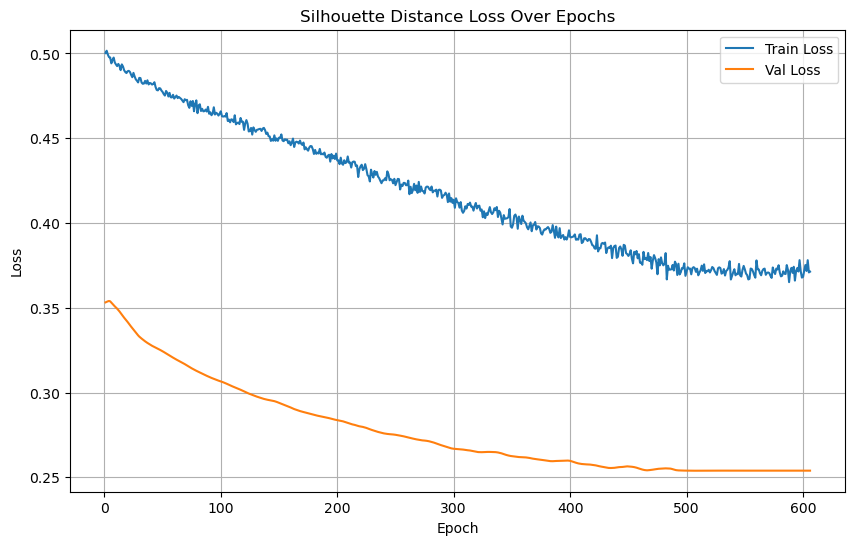

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/150], Loss: 0.2392


Test Batch [20/150], Loss: 0.2640
Test Batch [30/150], Loss: 0.3595


Test Batch [40/150], Loss: 0.4292


Test Batch [50/150], Loss: 0.4242
Test Batch [60/150], Loss: 0.3682


Test Batch [70/150], Loss: 0.2314
Test Batch [80/150], Loss: 0.3473


Test Batch [90/150], Loss: 0.2005
Test Batch [100/150], Loss: 0.1760
Test Batch [110/150], Loss: 0.2519


Test Batch [120/150], Loss: 0.1042


Test Batch [130/150], Loss: 0.3820
Test Batch [140/150], Loss: 0.3064


Test Batch [150/150], Loss: 0.1904

Test Loss: 0.3069


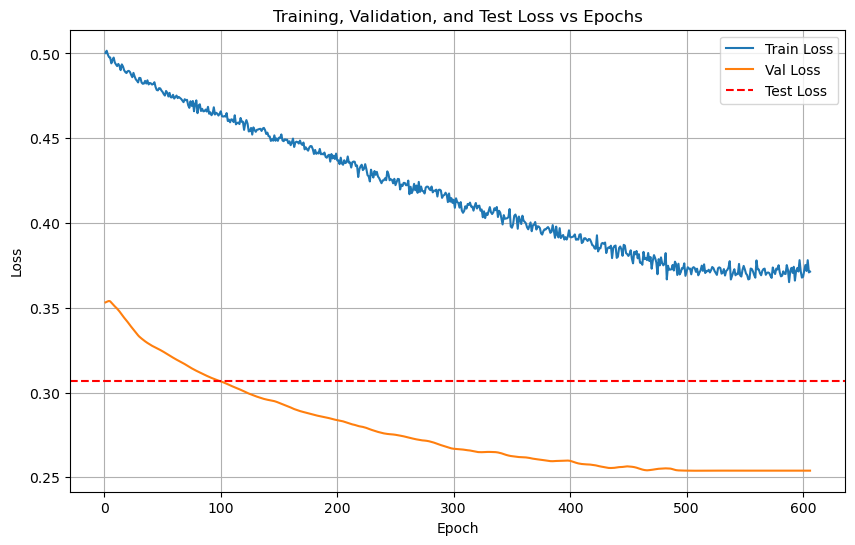

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/150 for test dataset.


  Processed batch 20/150 for test dataset.


  Processed batch 30/150 for test dataset.
  Processed batch 40/150 for test dataset.


  Processed batch 50/150 for test dataset.


  Processed batch 60/150 for test dataset.
  Processed batch 70/150 for test dataset.
  Processed batch 80/150 for test dataset.


  Processed batch 90/150 for test dataset.


  Processed batch 100/150 for test dataset.
  Processed batch 110/150 for test dataset.
  Processed batch 120/150 for test dataset.


  Processed batch 130/150 for test dataset.


  Processed batch 140/150 for test dataset.
  Processed batch 150/150 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 61.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.25      0.20      0.22         5
           2       0.50      0.20      0.29         5
           3       0.83      1.00      0.91         5
           4       1.00      0.40      0.57         5
           5       0.50      0.40      0.44         5
           7       0.60      0.60      0.60         5
           9       0.75      0.60      0.67         5
          10       0.40      0.40      0.40         5
          11       0.30      0.60      0.40         5
          12       0.83      1.00      0.91         5
          13       0.80      0.80      0.80         5
          14       0.40      0.40      0.40         5
          15       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8368  |  Val Loss: 2.8532
Validation loss improved from inf to 2.8532.
[Epoch 2/1000] Train Loss: 2.8037  |  Val Loss: 2.8189
Validation loss improved from 2.8532 to 2.8189.
[Epoch 3/1000] Train Loss: 2.7727  |  Val Loss: 2.7904
Validation loss improved from 2.8189 to 2.7904.
[Epoch 4/1000] Train Loss: 2.7426  |  Val Loss: 2.7637
Validation loss improved from 2.7904 to 2.7637.
[Epoch 5/1000] Train Loss: 2.7158  |  Val Loss: 2.7402
Validation loss improved from 2.7637 to 2.7402.


[Epoch 6/1000] Train Loss: 2.6925  |  Val Loss: 2.7182
Validation loss improved from 2.7402 to 2.7182.
[Epoch 7/1000] Train Loss: 2.6696  |  Val Loss: 2.6976
Validation loss improved from 2.7182 to 2.6976.
[Epoch 8/1000] Train Loss: 2.6484  |  Val Loss: 2.6789
Validation loss improved from 2.6976 to 2.6789.
[Epoch 9/1000] Train Loss: 2.6294  |  Val Loss: 2.6624
Validation loss improved from 2.6789 to 2.6624.
[Epoch 10/1000] Train Loss: 2.6115  |  Val Loss: 2.6478
Validation loss improved from 2.6624 to 2.6478.
[Epoch 11/1000] Train Loss: 2.5945  |  Val Loss: 2.6347
Validation loss improved from 2.6478 to 2.6347.
[Epoch 12/1000] Train Loss: 2.5787  |  Val Loss: 2.6218
Validation loss improved from 2.6347 to 2.6218.
[Epoch 13/1000] Train Loss: 2.5643  |  Val Loss: 2.6090
Validation loss improved from 2.6218 to 2.6090.
[Epoch 14/1000] Train Loss: 2.5495  |  Val Loss: 2.5965
Validation loss improved from 2.6090 to 2.5965.


[Epoch 15/1000] Train Loss: 2.5355  |  Val Loss: 2.5845
Validation loss improved from 2.5965 to 2.5845.
[Epoch 16/1000] Train Loss: 2.5210  |  Val Loss: 2.5727
Validation loss improved from 2.5845 to 2.5727.
[Epoch 17/1000] Train Loss: 2.5076  |  Val Loss: 2.5612
Validation loss improved from 2.5727 to 2.5612.
[Epoch 18/1000] Train Loss: 2.4932  |  Val Loss: 2.5500
Validation loss improved from 2.5612 to 2.5500.
[Epoch 19/1000] Train Loss: 2.4798  |  Val Loss: 2.5386
Validation loss improved from 2.5500 to 2.5386.


[Epoch 20/1000] Train Loss: 2.4662  |  Val Loss: 2.5271
Validation loss improved from 2.5386 to 2.5271.
[Epoch 21/1000] Train Loss: 2.4524  |  Val Loss: 2.5155
Validation loss improved from 2.5271 to 2.5155.
[Epoch 22/1000] Train Loss: 2.4393  |  Val Loss: 2.5036
Validation loss improved from 2.5155 to 2.5036.
[Epoch 23/1000] Train Loss: 2.4254  |  Val Loss: 2.4918
Validation loss improved from 2.5036 to 2.4918.
[Epoch 24/1000] Train Loss: 2.4116  |  Val Loss: 2.4799
Validation loss improved from 2.4918 to 2.4799.


[Epoch 25/1000] Train Loss: 2.3973  |  Val Loss: 2.4680
Validation loss improved from 2.4799 to 2.4680.
[Epoch 26/1000] Train Loss: 2.3829  |  Val Loss: 2.4555
Validation loss improved from 2.4680 to 2.4555.
[Epoch 27/1000] Train Loss: 2.3687  |  Val Loss: 2.4430
Validation loss improved from 2.4555 to 2.4430.
[Epoch 28/1000] Train Loss: 2.3539  |  Val Loss: 2.4309
Validation loss improved from 2.4430 to 2.4309.
[Epoch 29/1000] Train Loss: 2.3393  |  Val Loss: 2.4184
Validation loss improved from 2.4309 to 2.4184.
[Epoch 30/1000] Train Loss: 2.3239  |  Val Loss: 2.4057
Validation loss improved from 2.4184 to 2.4057.
[Epoch 31/1000] Train Loss: 2.3085  |  Val Loss: 2.3927
Validation loss improved from 2.4057 to 2.3927.
[Epoch 32/1000] Train Loss: 2.2927  |  Val Loss: 2.3795
Validation loss improved from 2.3927 to 2.3795.
[Epoch 33/1000] Train Loss: 2.2769  |  Val Loss: 2.3662
Validation loss improved from 2.3795 to 2.3662.


[Epoch 34/1000] Train Loss: 2.2606  |  Val Loss: 2.3518
Validation loss improved from 2.3662 to 2.3518.
[Epoch 35/1000] Train Loss: 2.2436  |  Val Loss: 2.3374
Validation loss improved from 2.3518 to 2.3374.
[Epoch 36/1000] Train Loss: 2.2272  |  Val Loss: 2.3230
Validation loss improved from 2.3374 to 2.3230.


[Epoch 37/1000] Train Loss: 2.2100  |  Val Loss: 2.3093
Validation loss improved from 2.3230 to 2.3093.
[Epoch 38/1000] Train Loss: 2.1928  |  Val Loss: 2.2950
Validation loss improved from 2.3093 to 2.2950.
[Epoch 39/1000] Train Loss: 2.1755  |  Val Loss: 2.2801
Validation loss improved from 2.2950 to 2.2801.
[Epoch 40/1000] Train Loss: 2.1575  |  Val Loss: 2.2656
Validation loss improved from 2.2801 to 2.2656.
[Epoch 41/1000] Train Loss: 2.1397  |  Val Loss: 2.2511
Validation loss improved from 2.2656 to 2.2511.
[Epoch 42/1000] Train Loss: 2.1218  |  Val Loss: 2.2368
Validation loss improved from 2.2511 to 2.2368.


[Epoch 43/1000] Train Loss: 2.1042  |  Val Loss: 2.2225
Validation loss improved from 2.2368 to 2.2225.
[Epoch 44/1000] Train Loss: 2.0865  |  Val Loss: 2.2080
Validation loss improved from 2.2225 to 2.2080.
[Epoch 45/1000] Train Loss: 2.0687  |  Val Loss: 2.1939
Validation loss improved from 2.2080 to 2.1939.
[Epoch 46/1000] Train Loss: 2.0503  |  Val Loss: 2.1795
Validation loss improved from 2.1939 to 2.1795.
[Epoch 47/1000] Train Loss: 2.0323  |  Val Loss: 2.1651
Validation loss improved from 2.1795 to 2.1651.
[Epoch 48/1000] Train Loss: 2.0142  |  Val Loss: 2.1513
Validation loss improved from 2.1651 to 2.1513.
[Epoch 49/1000] Train Loss: 1.9965  |  Val Loss: 2.1372
Validation loss improved from 2.1513 to 2.1372.
[Epoch 50/1000] Train Loss: 1.9778  |  Val Loss: 2.1227
Validation loss improved from 2.1372 to 2.1227.
[Epoch 51/1000] Train Loss: 1.9595  |  Val Loss: 2.1097
Validation loss improved from 2.1227 to 2.1097.


[Epoch 52/1000] Train Loss: 1.9416  |  Val Loss: 2.0954
Validation loss improved from 2.1097 to 2.0954.
[Epoch 53/1000] Train Loss: 1.9230  |  Val Loss: 2.0817
Validation loss improved from 2.0954 to 2.0817.
[Epoch 54/1000] Train Loss: 1.9041  |  Val Loss: 2.0683
Validation loss improved from 2.0817 to 2.0683.
[Epoch 55/1000] Train Loss: 1.8858  |  Val Loss: 2.0551
Validation loss improved from 2.0683 to 2.0551.
[Epoch 56/1000] Train Loss: 1.8673  |  Val Loss: 2.0420
Validation loss improved from 2.0551 to 2.0420.


[Epoch 57/1000] Train Loss: 1.8488  |  Val Loss: 2.0290
Validation loss improved from 2.0420 to 2.0290.
[Epoch 58/1000] Train Loss: 1.8302  |  Val Loss: 2.0156
Validation loss improved from 2.0290 to 2.0156.
[Epoch 59/1000] Train Loss: 1.8115  |  Val Loss: 2.0033
Validation loss improved from 2.0156 to 2.0033.
[Epoch 60/1000] Train Loss: 1.7929  |  Val Loss: 1.9903
Validation loss improved from 2.0033 to 1.9903.
[Epoch 61/1000] Train Loss: 1.7739  |  Val Loss: 1.9780
Validation loss improved from 1.9903 to 1.9780.
[Epoch 62/1000] Train Loss: 1.7553  |  Val Loss: 1.9650
Validation loss improved from 1.9780 to 1.9650.


[Epoch 63/1000] Train Loss: 1.7365  |  Val Loss: 1.9521
Validation loss improved from 1.9650 to 1.9521.
[Epoch 64/1000] Train Loss: 1.7177  |  Val Loss: 1.9388
Validation loss improved from 1.9521 to 1.9388.
[Epoch 65/1000] Train Loss: 1.6986  |  Val Loss: 1.9256
Validation loss improved from 1.9388 to 1.9256.
[Epoch 66/1000] Train Loss: 1.6800  |  Val Loss: 1.9122
Validation loss improved from 1.9256 to 1.9122.
[Epoch 67/1000] Train Loss: 1.6608  |  Val Loss: 1.8986
Validation loss improved from 1.9122 to 1.8986.
[Epoch 68/1000] Train Loss: 1.6426  |  Val Loss: 1.8856
Validation loss improved from 1.8986 to 1.8856.
[Epoch 69/1000] Train Loss: 1.6235  |  Val Loss: 1.8715
Validation loss improved from 1.8856 to 1.8715.
[Epoch 70/1000] Train Loss: 1.6052  |  Val Loss: 1.8571
Validation loss improved from 1.8715 to 1.8571.


[Epoch 71/1000] Train Loss: 1.5863  |  Val Loss: 1.8430
Validation loss improved from 1.8571 to 1.8430.
[Epoch 72/1000] Train Loss: 1.5685  |  Val Loss: 1.8304
Validation loss improved from 1.8430 to 1.8304.
[Epoch 73/1000] Train Loss: 1.5499  |  Val Loss: 1.8168
Validation loss improved from 1.8304 to 1.8168.
[Epoch 74/1000] Train Loss: 1.5316  |  Val Loss: 1.8033
Validation loss improved from 1.8168 to 1.8033.
[Epoch 75/1000] Train Loss: 1.5129  |  Val Loss: 1.7903
Validation loss improved from 1.8033 to 1.7903.


[Epoch 76/1000] Train Loss: 1.4953  |  Val Loss: 1.7765
Validation loss improved from 1.7903 to 1.7765.
[Epoch 77/1000] Train Loss: 1.4770  |  Val Loss: 1.7645
Validation loss improved from 1.7765 to 1.7645.
[Epoch 78/1000] Train Loss: 1.4587  |  Val Loss: 1.7521
Validation loss improved from 1.7645 to 1.7521.
[Epoch 79/1000] Train Loss: 1.4408  |  Val Loss: 1.7398
Validation loss improved from 1.7521 to 1.7398.
[Epoch 80/1000] Train Loss: 1.4237  |  Val Loss: 1.7274
Validation loss improved from 1.7398 to 1.7274.
[Epoch 81/1000] Train Loss: 1.4058  |  Val Loss: 1.7167
Validation loss improved from 1.7274 to 1.7167.


[Epoch 82/1000] Train Loss: 1.3882  |  Val Loss: 1.7049
Validation loss improved from 1.7167 to 1.7049.
[Epoch 83/1000] Train Loss: 1.3712  |  Val Loss: 1.6933
Validation loss improved from 1.7049 to 1.6933.
[Epoch 84/1000] Train Loss: 1.3540  |  Val Loss: 1.6813
Validation loss improved from 1.6933 to 1.6813.
[Epoch 85/1000] Train Loss: 1.3375  |  Val Loss: 1.6707
Validation loss improved from 1.6813 to 1.6707.
[Epoch 86/1000] Train Loss: 1.3202  |  Val Loss: 1.6591
Validation loss improved from 1.6707 to 1.6591.
[Epoch 87/1000] Train Loss: 1.3039  |  Val Loss: 1.6481
Validation loss improved from 1.6591 to 1.6481.
[Epoch 88/1000] Train Loss: 1.2872  |  Val Loss: 1.6356
Validation loss improved from 1.6481 to 1.6356.
[Epoch 89/1000] Train Loss: 1.2717  |  Val Loss: 1.6237
Validation loss improved from 1.6356 to 1.6237.
[Epoch 90/1000] Train Loss: 1.2554  |  Val Loss: 1.6132
Validation loss improved from 1.6237 to 1.6132.


[Epoch 91/1000] Train Loss: 1.2397  |  Val Loss: 1.6024
Validation loss improved from 1.6132 to 1.6024.
[Epoch 92/1000] Train Loss: 1.2245  |  Val Loss: 1.5911
Validation loss improved from 1.6024 to 1.5911.
[Epoch 93/1000] Train Loss: 1.2088  |  Val Loss: 1.5805
Validation loss improved from 1.5911 to 1.5805.
[Epoch 94/1000] Train Loss: 1.1941  |  Val Loss: 1.5693
Validation loss improved from 1.5805 to 1.5693.
[Epoch 95/1000] Train Loss: 1.1788  |  Val Loss: 1.5571
Validation loss improved from 1.5693 to 1.5571.
[Epoch 96/1000] Train Loss: 1.1640  |  Val Loss: 1.5461
Validation loss improved from 1.5571 to 1.5461.


[Epoch 97/1000] Train Loss: 1.1492  |  Val Loss: 1.5354
Validation loss improved from 1.5461 to 1.5354.
[Epoch 98/1000] Train Loss: 1.1349  |  Val Loss: 1.5243
Validation loss improved from 1.5354 to 1.5243.
[Epoch 99/1000] Train Loss: 1.1206  |  Val Loss: 1.5134
Validation loss improved from 1.5243 to 1.5134.
[Epoch 100/1000] Train Loss: 1.1062  |  Val Loss: 1.5030
Validation loss improved from 1.5134 to 1.5030.
[Epoch 101/1000] Train Loss: 1.0926  |  Val Loss: 1.4935
Validation loss improved from 1.5030 to 1.4935.
[Epoch 102/1000] Train Loss: 1.0785  |  Val Loss: 1.4835
Validation loss improved from 1.4935 to 1.4835.


[Epoch 103/1000] Train Loss: 1.0654  |  Val Loss: 1.4719
Validation loss improved from 1.4835 to 1.4719.
[Epoch 104/1000] Train Loss: 1.0513  |  Val Loss: 1.4618
Validation loss improved from 1.4719 to 1.4618.
[Epoch 105/1000] Train Loss: 1.0387  |  Val Loss: 1.4530
Validation loss improved from 1.4618 to 1.4530.
[Epoch 106/1000] Train Loss: 1.0258  |  Val Loss: 1.4456
Validation loss improved from 1.4530 to 1.4456.
[Epoch 107/1000] Train Loss: 1.0127  |  Val Loss: 1.4362
Validation loss improved from 1.4456 to 1.4362.
[Epoch 108/1000] Train Loss: 1.0004  |  Val Loss: 1.4270
Validation loss improved from 1.4362 to 1.4270.
[Epoch 109/1000] Train Loss: 0.9880  |  Val Loss: 1.4190
Validation loss improved from 1.4270 to 1.4190.
[Epoch 110/1000] Train Loss: 0.9762  |  Val Loss: 1.4106
Validation loss improved from 1.4190 to 1.4106.
[Epoch 111/1000] Train Loss: 0.9640  |  Val Loss: 1.4015
Validation loss improved from 1.4106 to 1.4015.


[Epoch 112/1000] Train Loss: 0.9520  |  Val Loss: 1.3939
Validation loss improved from 1.4015 to 1.3939.
[Epoch 113/1000] Train Loss: 0.9405  |  Val Loss: 1.3862
Validation loss improved from 1.3939 to 1.3862.
[Epoch 114/1000] Train Loss: 0.9291  |  Val Loss: 1.3785
Validation loss improved from 1.3862 to 1.3785.
[Epoch 115/1000] Train Loss: 0.9174  |  Val Loss: 1.3696
Validation loss improved from 1.3785 to 1.3696.
[Epoch 116/1000] Train Loss: 0.9062  |  Val Loss: 1.3620
Validation loss improved from 1.3696 to 1.3620.


[Epoch 117/1000] Train Loss: 0.8959  |  Val Loss: 1.3543
Validation loss improved from 1.3620 to 1.3543.
[Epoch 118/1000] Train Loss: 0.8846  |  Val Loss: 1.3468
Validation loss improved from 1.3543 to 1.3468.
[Epoch 119/1000] Train Loss: 0.8738  |  Val Loss: 1.3386
Validation loss improved from 1.3468 to 1.3386.
[Epoch 120/1000] Train Loss: 0.8637  |  Val Loss: 1.3320
Validation loss improved from 1.3386 to 1.3320.
[Epoch 121/1000] Train Loss: 0.8530  |  Val Loss: 1.3238
Validation loss improved from 1.3320 to 1.3238.
[Epoch 122/1000] Train Loss: 0.8426  |  Val Loss: 1.3159
Validation loss improved from 1.3238 to 1.3159.


[Epoch 123/1000] Train Loss: 0.8325  |  Val Loss: 1.3094
Validation loss improved from 1.3159 to 1.3094.
[Epoch 124/1000] Train Loss: 0.8226  |  Val Loss: 1.3019
Validation loss improved from 1.3094 to 1.3019.
[Epoch 125/1000] Train Loss: 0.8131  |  Val Loss: 1.2951
Validation loss improved from 1.3019 to 1.2951.
[Epoch 126/1000] Train Loss: 0.8032  |  Val Loss: 1.2891
Validation loss improved from 1.2951 to 1.2891.
[Epoch 127/1000] Train Loss: 0.7939  |  Val Loss: 1.2830
Validation loss improved from 1.2891 to 1.2830.
[Epoch 128/1000] Train Loss: 0.7842  |  Val Loss: 1.2784
Validation loss improved from 1.2830 to 1.2784.
[Epoch 129/1000] Train Loss: 0.7757  |  Val Loss: 1.2722
Validation loss improved from 1.2784 to 1.2722.
[Epoch 130/1000] Train Loss: 0.7664  |  Val Loss: 1.2652
Validation loss improved from 1.2722 to 1.2652.


[Epoch 131/1000] Train Loss: 0.7573  |  Val Loss: 1.2574
Validation loss improved from 1.2652 to 1.2574.
[Epoch 132/1000] Train Loss: 0.7486  |  Val Loss: 1.2504
Validation loss improved from 1.2574 to 1.2504.
[Epoch 133/1000] Train Loss: 0.7402  |  Val Loss: 1.2447
Validation loss improved from 1.2504 to 1.2447.


[Epoch 134/1000] Train Loss: 0.7319  |  Val Loss: 1.2400
Validation loss improved from 1.2447 to 1.2400.
[Epoch 135/1000] Train Loss: 0.7235  |  Val Loss: 1.2363
Validation loss improved from 1.2400 to 1.2363.
[Epoch 136/1000] Train Loss: 0.7157  |  Val Loss: 1.2337
Validation loss improved from 1.2363 to 1.2337.
[Epoch 137/1000] Train Loss: 0.7078  |  Val Loss: 1.2297
Validation loss improved from 1.2337 to 1.2297.
[Epoch 138/1000] Train Loss: 0.7003  |  Val Loss: 1.2263
Validation loss improved from 1.2297 to 1.2263.
[Epoch 139/1000] Train Loss: 0.6923  |  Val Loss: 1.2230
Validation loss improved from 1.2263 to 1.2230.
[Epoch 140/1000] Train Loss: 0.6851  |  Val Loss: 1.2207
Validation loss improved from 1.2230 to 1.2207.
[Epoch 141/1000] Train Loss: 0.6779  |  Val Loss: 1.2175
Validation loss improved from 1.2207 to 1.2175.
[Epoch 142/1000] Train Loss: 0.6711  |  Val Loss: 1.2132
Validation loss improved from 1.2175 to 1.2132.
[Epoch 143/1000] Train Loss: 0.6637  |  Val Loss: 1.211

[Epoch 144/1000] Train Loss: 0.6568  |  Val Loss: 1.2100
Validation loss improved from 1.2111 to 1.2100.
[Epoch 145/1000] Train Loss: 0.6500  |  Val Loss: 1.2064
Validation loss improved from 1.2100 to 1.2064.
[Epoch 146/1000] Train Loss: 0.6437  |  Val Loss: 1.2045
Validation loss improved from 1.2064 to 1.2045.
[Epoch 147/1000] Train Loss: 0.6366  |  Val Loss: 1.2026
Validation loss improved from 1.2045 to 1.2026.
[Epoch 148/1000] Train Loss: 0.6299  |  Val Loss: 1.2010
Validation loss improved from 1.2026 to 1.2010.
[Epoch 149/1000] Train Loss: 0.6238  |  Val Loss: 1.2001
Validation loss improved from 1.2010 to 1.2001.
[Epoch 150/1000] Train Loss: 0.6174  |  Val Loss: 1.1987
Validation loss improved from 1.2001 to 1.1987.
[Epoch 151/1000] Train Loss: 0.6112  |  Val Loss: 1.1971
Validation loss improved from 1.1987 to 1.1971.


[Epoch 152/1000] Train Loss: 0.6058  |  Val Loss: 1.1970
Validation loss improved from 1.1971 to 1.1970.


[Epoch 153/1000] Train Loss: 0.5996  |  Val Loss: 1.1959
Validation loss improved from 1.1970 to 1.1959.
[Epoch 154/1000] Train Loss: 0.5941  |  Val Loss: 1.1956
Validation loss improved from 1.1959 to 1.1956.
[Epoch 155/1000] Train Loss: 0.5883  |  Val Loss: 1.1948
Validation loss improved from 1.1956 to 1.1948.
[Epoch 156/1000] Train Loss: 0.5830  |  Val Loss: 1.1927
Validation loss improved from 1.1948 to 1.1927.
[Epoch 157/1000] Train Loss: 0.5776  |  Val Loss: 1.1925
Validation loss improved from 1.1927 to 1.1925.
[Epoch 158/1000] Train Loss: 0.5724  |  Val Loss: 1.1932
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 159/1000] Train Loss: 0.5675  |  Val Loss: 1.1949
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 160/1000] Train Loss: 0.5625  |  Val Loss: 1.1943
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 161/1000] Train Loss: 0.5576  |  Val Loss: 1.1936
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 162/1000] Train Loss: 0.

[Epoch 164/1000] Train Loss: 0.5438  |  Val Loss: 1.1973
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 165/1000] Train Loss: 0.5389  |  Val Loss: 1.1974
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 166/1000] Train Loss: 0.5347  |  Val Loss: 1.1972
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 167/1000] Train Loss: 0.5304  |  Val Loss: 1.1980
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 168/1000] Train Loss: 0.5263  |  Val Loss: 1.1991
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 169/1000] Train Loss: 0.5221  |  Val Loss: 1.2001
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 170/1000] Train Loss: 0.5180  |  Val Loss: 1.2011
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 171/1000] Train Loss: 0.5138  |  Val Loss: 1.2027
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 172/1000] Train Loss: 0.5098  |  Val Loss: 1.2020
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 173/1000] Train Loss: 0.5061  |  Val Loss: 1.2040
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 174/1000] Train Loss: 0.5020  |  Val Loss: 1.2048
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 175/1000] Train Loss: 0.4984  |  Val Loss: 1.2069
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 176/1000] Train Loss: 0.4947  |  Val Loss: 1.2090
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 177/1000] Train Loss: 0.4909  |  Val Loss: 1.2100
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 178/1000] Train Loss: 0.4876  |  Val Loss: 1.2105
!! Validation loss did NOT improve !! Patience:

[Epoch 185/1000] Train Loss: 0.4643  |  Val Loss: 1.2185
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 186/1000] Train Loss: 0.4613  |  Val Loss: 1.2201
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 187/1000] Train Loss: 0.4584  |  Val Loss: 1.2216
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 188/1000] Train Loss: 0.4555  |  Val Loss: 1.2217
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 189/1000] Train Loss: 0.4525  |  Val Loss: 1.2238
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 190/1000] Train Loss: 0.4496  |  Val Loss: 1.2240
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 191/1000] Train Loss: 0.4469  |  Val Loss: 1.2260
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 192/1000] Train Loss: 0.4442  |  Val Loss: 1.2266
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 193/1000] Train Loss: 0.4414  |  Val Loss: 1.2273
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 194/1000] Train Loss: 0.4386  |  Val Loss: 1.2272
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 195/1000] Train Loss: 0.4362  |  Val Loss: 1.2273
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 196/1000] Train Loss: 0.4335  |  Val Loss: 1.2291
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 197/1000] Train Loss: 0.4309  |  Val Loss: 1.2322
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 198/1000] Train Loss: 0.4284  |  Val Loss: 1.2334
!! Validation loss did NOT improve !! Patience:

[Epoch 202/1000] Train Loss: 0.4189  |  Val Loss: 1.2346
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 203/1000] Train Loss: 0.4163  |  Val Loss: 1.2362
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 204/1000] Train Loss: 0.4140  |  Val Loss: 1.2377
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 205/1000] Train Loss: 0.4118  |  Val Loss: 1.2397
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 206/1000] Train Loss: 0.4096  |  Val Loss: 1.2394
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 207/1000] Train Loss: 0.4073  |  Val Loss: 1.2405
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 208/1000] Train Loss: 0.4050  |  Val Loss: 1.2418
!! Validation loss did NOT improve !! Patience: 51/100


[Epoch 209/1000] Train Loss: 0.4027  |  Val Loss: 1.2411
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 210/1000] Train Loss: 0.4008  |  Val Loss: 1.2425
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 211/1000] Train Loss: 0.3988  |  Val Loss: 1.2431
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 212/1000] Train Loss: 0.3967  |  Val Loss: 1.2449
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 213/1000] Train Loss: 0.3946  |  Val Loss: 1.2455
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 214/1000] Train Loss: 0.3923  |  Val Loss: 1.2461
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 215/1000] Train Loss: 0.3909  |  Val Loss: 1.2481
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 216/1000] Train Loss: 0.3884  |  Val Loss: 1.2495
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 217/1000] Train Loss: 0.3869  |  Val Loss: 1.2498
!! Validation loss did NOT improve !! Patience:

[Epoch 221/1000] Train Loss: 0.3788  |  Val Loss: 1.2580
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 222/1000] Train Loss: 0.3770  |  Val Loss: 1.2586
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 223/1000] Train Loss: 0.3752  |  Val Loss: 1.2579
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 224/1000] Train Loss: 0.3733  |  Val Loss: 1.2578
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 225/1000] Train Loss: 0.3719  |  Val Loss: 1.2587
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 226/1000] Train Loss: 0.3700  |  Val Loss: 1.2637
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 227/1000] Train Loss: 0.3679  |  Val Loss: 1.2687
!! Validation loss did NOT improve !! Patience: 70/100


[Epoch 228/1000] Train Loss: 0.3665  |  Val Loss: 1.2690
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 229/1000] Train Loss: 0.3643  |  Val Loss: 1.2705
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 230/1000] Train Loss: 0.3629  |  Val Loss: 1.2711
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 231/1000] Train Loss: 0.3609  |  Val Loss: 1.2719
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 232/1000] Train Loss: 0.3592  |  Val Loss: 1.2741
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 233/1000] Train Loss: 0.3576  |  Val Loss: 1.2745
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 234/1000] Train Loss: 0.3560  |  Val Loss: 1.2755
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 235/1000] Train Loss: 0.3543  |  Val Loss: 1.2773
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 236/1000] Train Loss: 0.3527  |  Val Loss: 1.2794
!! Validation loss did NOT improve !! Patience:

[Epoch 241/1000] Train Loss: 0.3452  |  Val Loss: 1.2868
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 242/1000] Train Loss: 0.3436  |  Val Loss: 1.2891
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 243/1000] Train Loss: 0.3420  |  Val Loss: 1.2918
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 244/1000] Train Loss: 0.3409  |  Val Loss: 1.2907
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 245/1000] Train Loss: 0.3391  |  Val Loss: 1.2930
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 246/1000] Train Loss: 0.3382  |  Val Loss: 1.2977
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 247/1000] Train Loss: 0.3364  |  Val Loss: 1.2974
!! Validation loss did NOT improve !! Patience: 90/100


[Epoch 248/1000] Train Loss: 0.3350  |  Val Loss: 1.2979
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 249/1000] Train Loss: 0.3337  |  Val Loss: 1.2991
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 250/1000] Train Loss: 0.3323  |  Val Loss: 1.2990
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 251/1000] Train Loss: 0.3309  |  Val Loss: 1.2999
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 252/1000] Train Loss: 0.3296  |  Val Loss: 1.3022
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 253/1000] Train Loss: 0.3281  |  Val Loss: 1.3036
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 254/1000] Train Loss: 0.3273  |  Val Loss: 1.3063
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 255/1000] Train Loss: 0.3259  |  Val Loss: 1.3072
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 256/1000] Train Loss: 0.3246  |  Val Loss: 1.3081
!! Validation loss did NOT improve !! Patience:

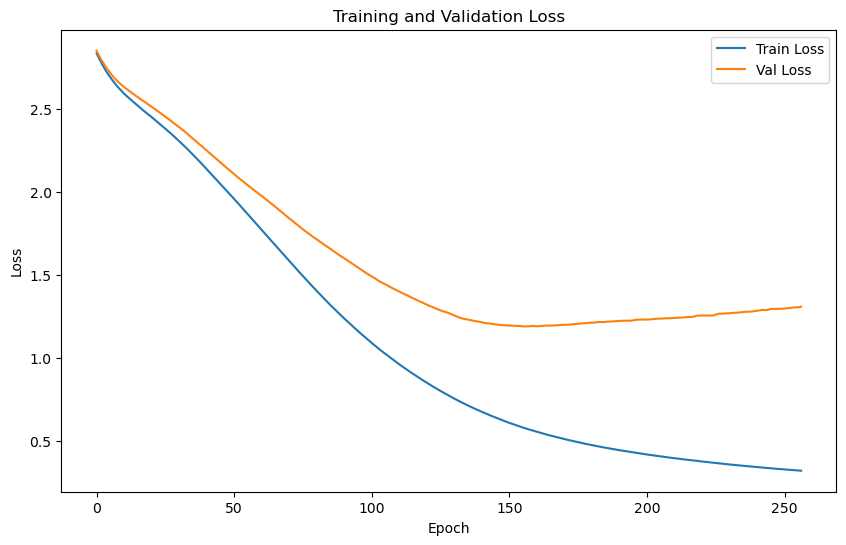

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.7462 | Test Accuracy: 52.99%


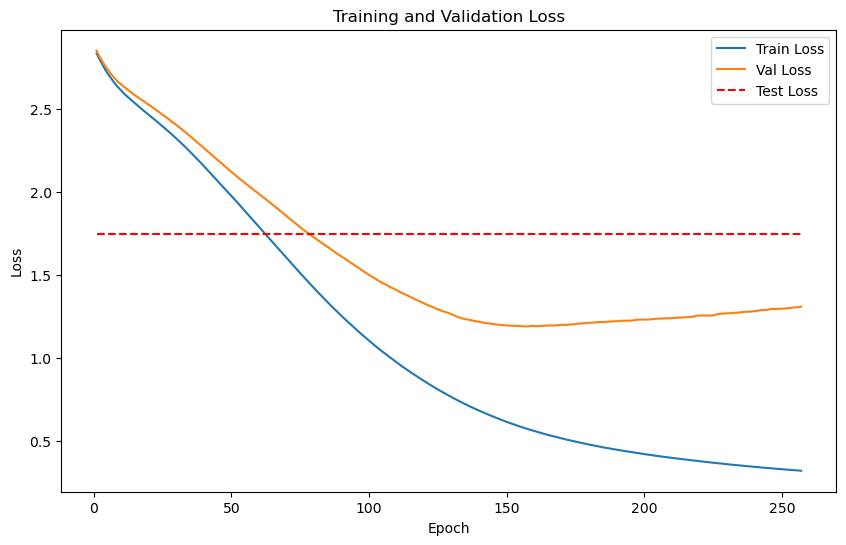

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_24456\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


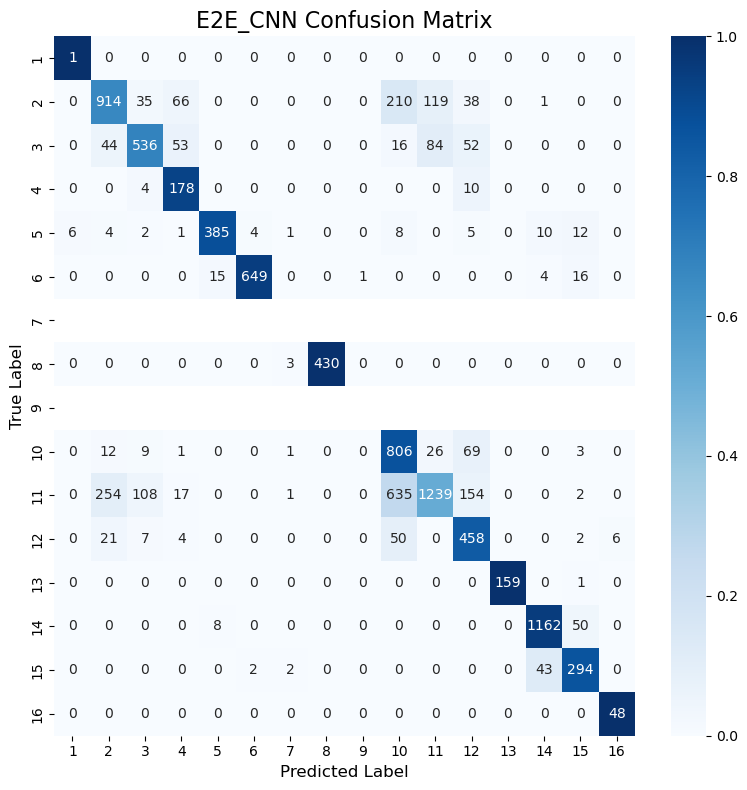

Classification Accuracy: 75.84%


C:\Users\vella\AppData\Local\Temp\ipykernel_24456\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


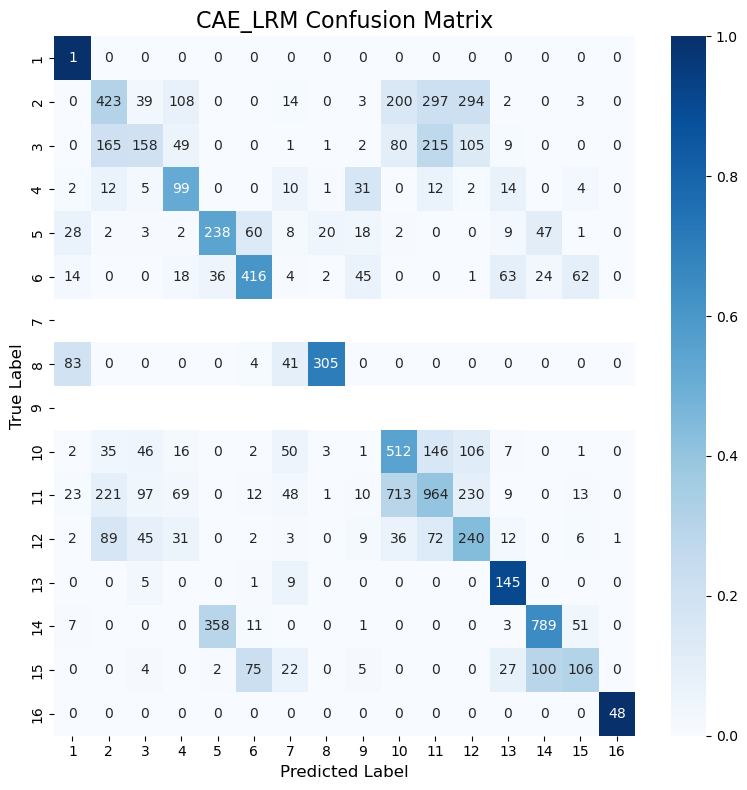

Classification Accuracy: 46.43%


C:\Users\vella\AppData\Local\Temp\ipykernel_24456\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


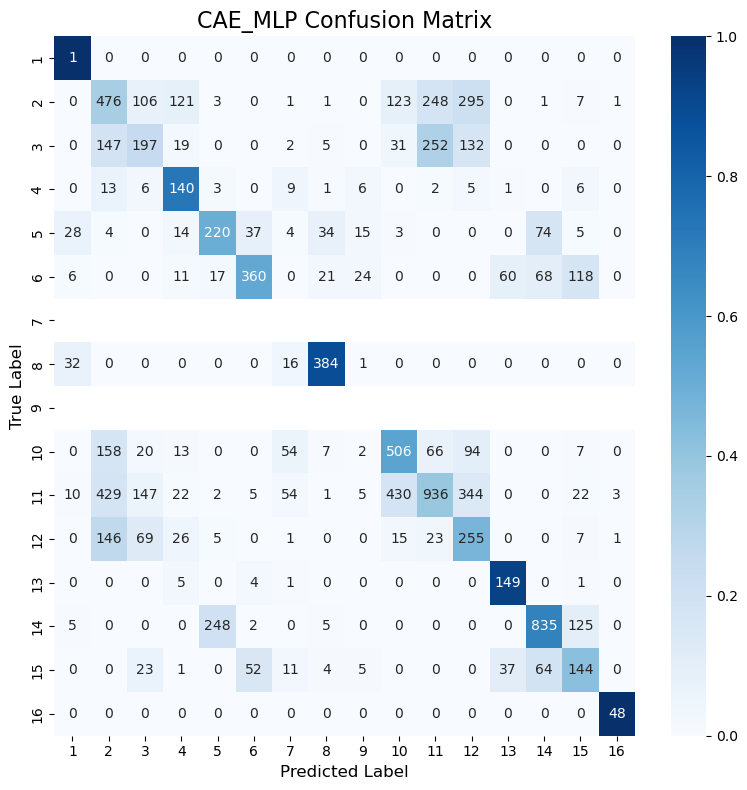

Classification Accuracy: 48.59%


C:\Users\vella\AppData\Local\Temp\ipykernel_24456\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


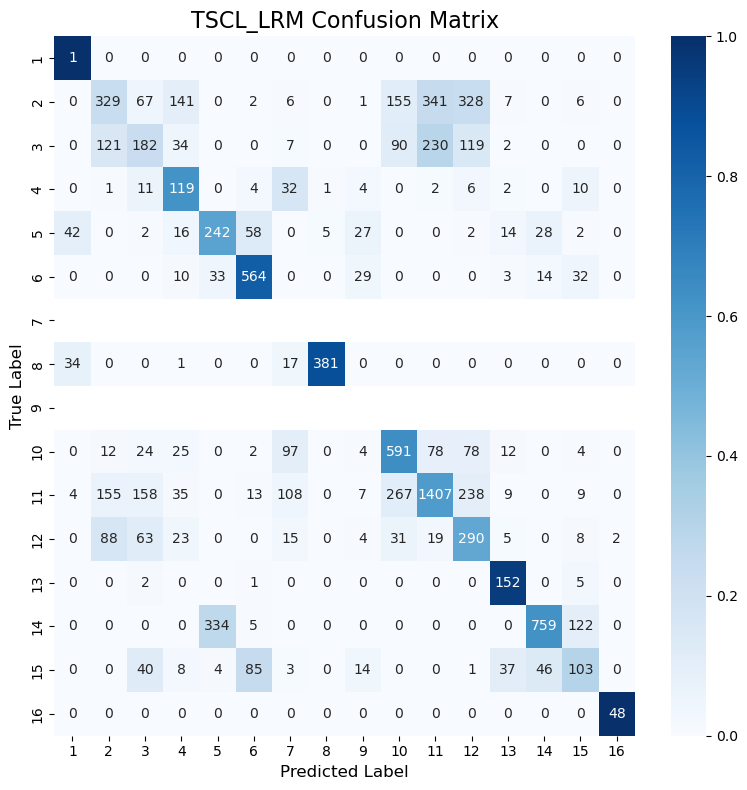

Classification Accuracy: 54.00%


C:\Users\vella\AppData\Local\Temp\ipykernel_24456\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


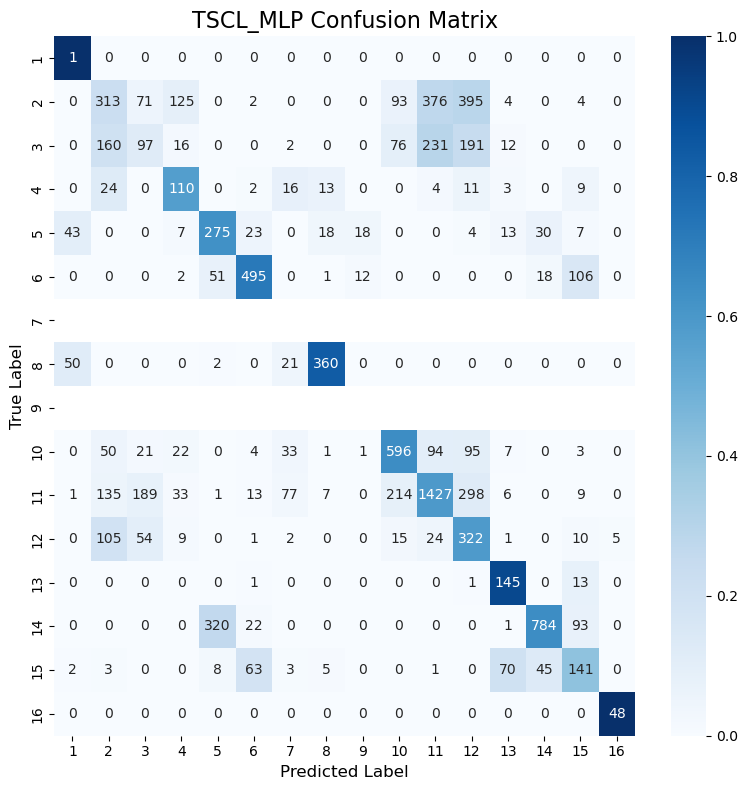

Classification Accuracy: 53.43%


C:\Users\vella\AppData\Local\Temp\ipykernel_24456\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


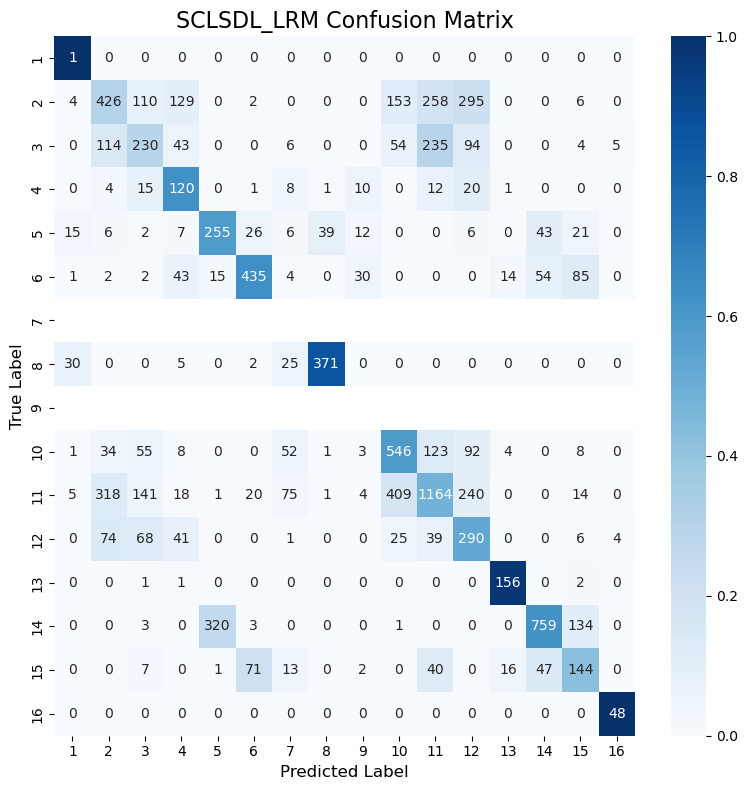

Classification Accuracy: 51.67%


C:\Users\vella\AppData\Local\Temp\ipykernel_24456\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


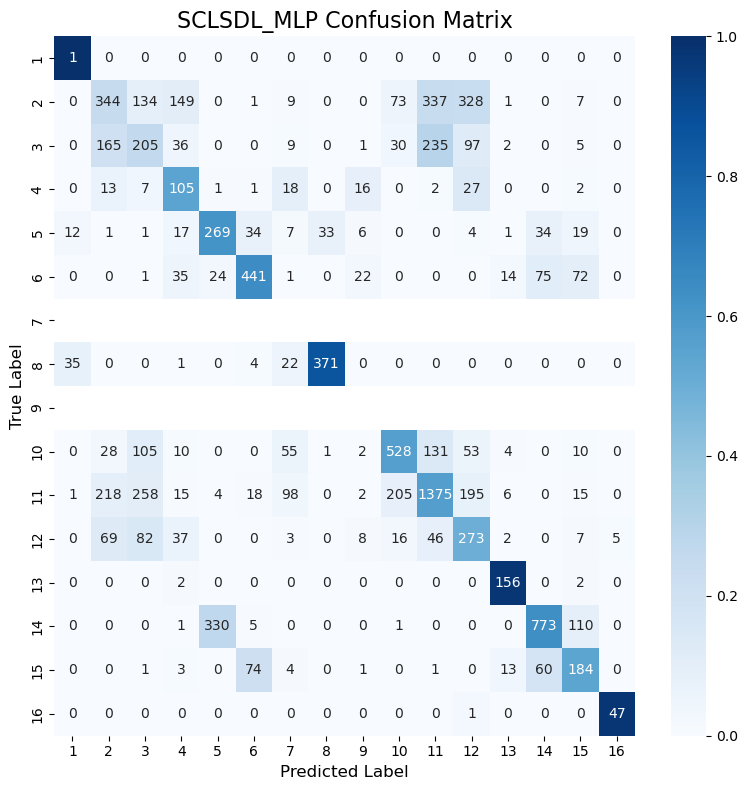

Classification Accuracy: 52.99%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          75.84
1    LRM (CAE)          46.43
2    MLP (CAE)          48.59
3     TSCL LRM          54.00
4     TSCL MLP          53.43
5  SCL_SDL LRM          51.67
6  SCL_SDL MLP          52.99

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          75.84
3     TSCL LRM          54.00
4     TSCL MLP          53.43
6  SCL_SDL MLP          52.99
5  SCL_SDL LRM          51.67
2    MLP (CAE)          48.59
1    LRM (CAE)          46.43
